## End to End PNNL Surrogate Model Training and Testing

Important parameters:

channel = 1 or 2 # do others later

gridsize = 128 or 512 

w = 10 # anything from 1 to 499 (simLen) is okay. 

latentDim = 16 

## Imports

In [1]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.pnnlDatasets import CCSI_2D

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, create_movie, convertSimToImage, \
                                    pkl_save, pkl_load, create_1_channel_movie

from surrogates4sims.models import Generator, Encoder, AE_no_P, AE_xhat_z, AE_xhat_zV2

import numpy as np
from tqdm import tqdm
from copy import deepcopy
from glob import glob

## Settings

In [2]:
# data 
eval_only=False
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "pnnl_end2end_plateau_train"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "2"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
channel = 2
gridsize = 128
dataDirec = '/data/ccsi/pnnl_liquid_inlet/channel_{}/gridsize_{}'.format(channel,gridsize)
preprocess = False # keep this as false until using the long runtime loader
testSplit = .2 # don't change this for now. 
AE = False
numWorkers = 2
physicsDim = 2 # inlet velocity and time sample

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = False  

# LIN parameters
hiddenLayers = [128,128]
activation = nn.ELU()

# hyper-params
seed = 1234
np.random.seed(seed)
bz = 3
numSamplesToKeep = 1 #if not debugging
latentDim = 16
window_size = 5
filters = 128
num_conv = 4 # breaks when less than 2
simLen = 6
stack = True
simVizIndex = 0 # sim in the test set to visualize
createStreamFcn = False
doJacobian = False
repeat = 0
skip_connection = False
norm_layer = [torch.nn.Identity][0]
patience = 1
if DEBUG:
    epochs = 10000
    numSamplesToKeep = 2 # 1 simulation
    
versionName = versionName + '_channel{}_gridsize{}_latentDim{}'.format(channel, gridsize, latentDim)
versionName

'pnnl_end2end_plateau_train_GPUs2_channel2_gridsize128_latentDim16'

## Select GPUs

In [3]:
!nvidia-smi

Wed Nov  4 12:39:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 46%   72C    P2   200W / 250W |   6097MiB / 12196MiB |     79%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 51%   80C    P2   215W / 250W |   6055MiB / 12196MiB |     77%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [6]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN Xp


In [7]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Wed Nov  4 12:39:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 46%   72C    P2    96W / 250W |   6097MiB / 12196MiB |     82%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 51%   79C    P2    94W / 250W |   6055MiB / 12196MiB |     79%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Datasets & Loaders

In [8]:
sims = glob(os.path.join(dataDirec,'*.pkl'))
numSims = len(sims)
idx = int(testSplit*numSims)
testInds = np.linspace(1,numSims-2,idx).astype('int')
trainInds = list(set(np.arange(0,numSims)).difference(set(testInds)))
# perm = np.random.permutation(numSims)
# testInds = perm[:idx]
# trainInds = perm[idx:]
testSimFiles = [sims[idx] for idx in testInds]
trainSimFiles = [sims[idx] for idx in trainInds]
len(testSimFiles), len(trainSimFiles)

(10, 40)

In [9]:
## change the CCSI_2D class in 01_pnnl with this one later
from torch.utils.data import Dataset
class CCSI_2D(Dataset):
    def __init__(self, 
                 dataFiles,
                 txtFile = '/data/ccsi/pnnl_liquid_inlet/liquid_inlet_velocity.txt',
                 channel=1,
                 gridSize=128,
                 simLen = 500,
                 w = 10, # this is the length of the Y output to predict
                 AE = False, # this only return x,x, i.e. no y.
                 numToKeep=np.infty,doPreprocess=False): 
        
        self.dataFiles = dataFiles
        if numToKeep < len(self.dataFiles):
            self.dataFiles = self.dataFiles[:numToKeep]

        self.channel = channel
        self.gridSize = gridSize
        self.numToKeep = numToKeep
        self.simLen = 6
        self.t = np.linspace(0,1,simLen).astype('float32')
        self.w = w
        self.AE = AE
        self.doPreprocess = doPreprocess
        
        # Get the inlet velocity
        with open(txtFile) as fid:
            txt = fid.read().splitlines()
        inletVelocity = np.array(list(map(float,txt[1:]))).astype('float32')
        self.inletMx = np.max(inletVelocity)
        self.inletMn = np.min(inletVelocity)
        
        data = []
        for fn in self.dataFiles:
            idx = int(fn.split('/')[-1].replace('.pkl','')) - 1
            D = pkl_load(fn)
            data.append((D[:6],inletVelocity[idx]))
               
        self.data = data
    
    def __len__(self):
        return len(self.simLen*self.data)

    def __getitem__(self, idx):
        if len(self.data) == 1:
            q = 0
            r_idx = 0
        else:
            q,r = np.divmod(idx,self.simLen)
            r_idx = np.random.randint(0,self.simLen-self.w)
            
        X,p = self.data[q]
        x = X[r_idx:r_idx+1]
        #print(x.shape)
        y = X[r_idx+1:r_idx+self.w+1]
        #print(y.shape)
        if self.doPreprocess:
            x = self.preprocessFcn(x)
            y = self.preprocessFcn(y)
        
        y = np.expand_dims(y,1)
        p_x = np.hstack([p,self.t[r_idx]])
        p_y = np.vstack([p*np.ones((self.w,)),self.t[r_idx+1:r_idx+self.w+1]]).T
        X = x.astype('float32')
        Y = y.astype('float32')
        if self.AE:
            return X,X # this allows LR_finder to work
        else:
            return X, Y, p_x, p_y


In [10]:
testDataset = CCSI_2D(testSimFiles,doPreprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel,AE=AE,
                      w=window_size)
trainDataset = CCSI_2D(trainSimFiles,doPreprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel,AE=AE,
                      w=window_size)
testDataset = trainDataset
len(testDataset), len(trainDataset)

(6, 6)

In [11]:
trainDataset[0][0].shape, trainDataset[0][1].shape, trainDataset[0][2].shape, trainDataset[0][3].shape

((1, 128, 128), (5, 1, 128, 128), (2,), (5, 2))

In [12]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True, 
                             num_workers=numWorkers, pin_memory=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz, num_workers=numWorkers, pin_memory=True)
len(trainDataLoader), len(testDataLoader)

(2, 2)

In [13]:
for i, x in enumerate(trainDataLoader):
    print(i, x[0].shape)

0 torch.Size([3, 1, 128, 128])
1 torch.Size([3, 1, 128, 128])


In [14]:
X,Y,p_x, p_y = next(iter(trainDataLoader))
print(X.shape,Y.shape,p_x.shape, p_y.shape)

torch.Size([3, 1, 128, 128]) torch.Size([3, 5, 1, 128, 128]) torch.Size([3, 2]) torch.Size([3, 5, 2])


## Model

In [15]:
X = X.to(device)
AE_model = AE_xhat_zV2(X, filters, latentDim, num_conv, repeat, 
                 skip_connection, stack, conv_k=3, last_k=3, 
                 act=nn.LeakyReLU(), return_z=True, stream=createStreamFcn, device=device, norm=norm_layer)

AE_model = nn.DataParallel(AE_model)

[128, 8, 8]


/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [16]:
printNumModelParams(AE_model)

90 layers require gradients (unfrozen) out of 90 layers
8,753,169 parameters require gradients (unfrozen) out of 8,753,169 parameters


In [17]:
Xhat,z = AE_model(X)
Xhat.shape, z.shape

(torch.Size([3, 1, 128, 128]), torch.Size([3, 16]))

In [18]:
AE_model.load_state_dict(torch.load(os.path.join('/home/bartoldson1/surrogates4sims/cps',
 'pnnl_plateau_train_GPUs23_channel1_gridsize128_latentDim16_filters128_bz16_numConv4_jacobianFalse_norm_layerIdentity_epochs1000_stackTrue_lr0.0001')))

In [19]:
# LIN Model
class MLP(nn.Module):
    def __init__(self, X, hiddenLayerSizes = [1024], activation=nn.ELU()):
        super(MLP,self).__init__()
        
        self.activation = activation
        self.inputSize = X.shape[1:]
        self.modules = []
        self.modules.append(nn.Linear(np.prod(self.inputSize),hiddenLayerSizes[0]))
        self.modules.append(self.activation)
        for idx,sz in enumerate(hiddenLayerSizes[:-1]):
            self.modules.append(nn.Linear(hiddenLayerSizes[idx],hiddenLayerSizes[idx+1]))
            self.modules.append(self.activation)
                               
        self.modules.append(nn.Linear(hiddenLayerSizes[-1],np.prod(self.inputSize)))
        self.layers = nn.Sequential(*self.modules)
                                
        
    def forward(self,x):
        x = self.layers(x)
        return x

In [20]:
LIN_model = MLP(z, hiddenLayerSizes=hiddenLayers, activation=activation)
LIN_model

MLP(
  (activation): ELU(alpha=1.0)
  (layers): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=16, bias=True)
  )
)

In [21]:
# surrogate class
class Surrogate(nn.Module):
    
    def __init__(self, window,
                 z_size, p_size,
                LIN, encoder, decoder):
        super(Surrogate, self).__init__()
        self.window = window
        self.z_size = z_size # this does not include the size of p
        self.p_size = p_size
        self.c_size = z_size + p_size # this does include the size of p
        self.LIN = LIN
        self.encoder = encoder
        self.decoder = decoder
        
    def encode(self, U):
        
        return self.encoder(U)
        
    def decode(self, encoding):
        
        return self.decoder(encoding)
        
    def predict_next_w_encodings(self, encoding, p_y, window):
        '''
        use the LIN to predict the next w encodings for each 
        encoded U in the batch
        '''
            
        predicted_encodings = []
            
        # given a batch of encodings, advance each encoding window time steps.
        # save the result at each time step
        for i in range(window):
            encoding = self.LIN(encoding) + encoding # use LIN to predict delta in encoding
            # this was encoding[:,:,-self.p_size:] in 09_manta..., why the extra dimension?
            encoding[:,-self.p_size:] = p_y[:, i]
            predicted_encodings.append(encoding)
            
            
        return torch.stack(predicted_encodings)
    
    def forward(self, U, p_x, p_y, window = None):
        
        if window == None:
            window = self.window
        assert p_y.size(1) == window
            
        encoding = self.encode(U)
        encoding[:,-self.p_size:] = p_x # added this on 10/27/2020
        encoding_w = self.predict_next_w_encodings(encoding, p_y, window)
        # want to have this agree with U_y, which is [batch_size, window_size, channels, nx, ny]
        # right now, it's [window_size, batch_size, c_size], so transpose dimensions 0 and 1
        #print(encoding_w.shape)
        U = torch.stack([self.decode(encoding_i) for encoding_i in encoding_w])
        return U.transpose(0,1)
    

In [22]:
surrogate = Surrogate(window_size, latentDim - physicsDim, physicsDim, LIN_model, AE_model.module.encoder, 
                      AE_model.module.generator)

In [23]:
surrogate = surrogate.to(device)

In [24]:
encoding = surrogate.encode(X)
encoding.shape

torch.Size([3, 16])

In [25]:
decoding = surrogate.decode(encoding)
decoding.shape

torch.Size([3, 1, 128, 128])

In [26]:
assert surrogate.c_size == latentDim
assert surrogate.p_size == physicsDim
assert encoding.shape[-1] == surrogate.c_size
assert decoding.shape == X.shape

In [27]:
Xhat = surrogate.forward(X, p_x, p_y)
Xhat.shape

torch.Size([3, 5, 1, 128, 128])

In [28]:
del surrogate, encoding, decoding, X, Y

surrogate = Surrogate(window_size, latentDim - physicsDim, physicsDim, LIN_model, 
                      AE_model.module.encoder, AE_model.module.generator).to(device)

if len(gpu_ids.split(',')) > 1:
    surrogate = nn.DataParallel(surrogate)

In [29]:
max_lr = .0001
start_lr = 5*max_lr/10
#opt = create_opt(max_lr,model)
#lr_scheduler = create_one_cycle(opt,max_lr,epochs,trainDataLoader)
opt = torch.optim.Adam(surrogate.parameters(),lr=max_lr,betas=(.5,.999))
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=patience)

In [30]:
def L1_loss(pred, target):
    return torch.norm(pred - target)/torch.norm(target)


def jacobian_loss(pred, target, device='cpu'):
    return L1_loss(jacobian(pred, device), jacobian(target, device))


def curl_loss(pred, target, device):
    return L1_loss(curl(pred, device), curl(target, device))


L = nn.MSELoss()


def p_loss(pred, target):
    return L(pred[:, -target.shape[1]:], target)


def loss(pred, target, device):
    
    if createStreamFcn:
        pred = stream2uv(pred, device)
        
    L1 = L1_loss(pred, target)
    Lj = 0
    if doJacobian:
        Lj = jacobian_loss(pred, target, device)
        
    return L1 + Lj

In [31]:
def trainEpoch(myDataLoader, tensorboard_writer, model, opt, p_loss, loss,
               metric, lr_scheduler, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    total_loss = 0.0
    running_ploss = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        
        # gpu
        U_x, U_y, p_x, p_y = sampleBatch
        U_x = U_x.to(device)
        p_x = p_x.to(device)
        U_y = U_y.to(device)
        p_y = p_y.to(device)
            

        # zero the parameter gradients
        opt.zero_grad()

        U_hat = model(U_x, p_x, p_y)
        pl = 0
        ll = loss(U_hat, U_y, device)
        combined_loss = pl + ll
        combined_loss.backward()
        opt.step()
        
        # loss
        batch_loss = combined_loss.item()
        running_loss += batch_loss
        total_loss += batch_loss
        
        batch_ploss = pl
        running_ploss += batch_ploss

        # --- Metrics Recording ---

        # metrics
        r = metric(U_hat, U_y)
        running_rmse += r

        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="LR", scalar_value=opt.param_groups[0]['lr'], global_step=total_steps)
        #lr_scheduler.step()

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            avg_running_ploss = running_ploss/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag="p_loss", scalar_value=avg_running_ploss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0
            running_ploss = 0.0
            tensorboard_writer.flush()

    return total_loss/len(myDataLoader), tensorboard_recorder_step, total_steps

In [32]:
def validEpoch(myDataLoader, tensorboard_writer, model, p_loss, loss, metric,
               device, tensorboard_recorder_step):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Metrics Recording ---

        # gpu
        U_x, U_y, p_x, p_y = sampleBatch
        U_x = U_x.to(device) # only squeeze away the window dimension (because batch size = 1)
        p_x = p_x.to(device) # only squeeze away the window dimension (because batch size = 1)
        U_y = U_y.to(device)
        p_y = p_y.to(device)
        
        perc = len(U_x)/len(myDataLoader.dataset)

        # forward, no gradient calculations
        with torch.no_grad():
            U_hat = model(U_x, p_x, p_y, window = window_size)

        # loss
        combined_loss = loss(U_hat, U_y, device)
        
        running_loss += perc*(combined_loss.item())

        # metrics
        r = metric(U_hat, U_y)
        running_rmse += perc*r

    avg_running_loss = running_loss
    avg_running_rmse = running_rmse
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
    tensorboard_writer.flush()
    
    return running_loss

In [33]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")
    
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

checkpoints directory already exists :)


In [34]:
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty

if not eval_only:
    for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times

        writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)

        surrogate.train()
        trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                       train_writer, surrogate,
                                                                       opt, p_loss, loss,
                                                                       rmse, lr_scheduler, 
                                                                       tensorboard_rate, device,
                                                                       tensorboard_recorder_step, total_steps)

        writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
        writeMessage("LR: {:.4e}".format(opt.param_groups[0]['lr']),versionName)
#         if trainLoss < bestLoss:
#             bestLoss = trainLoss
#             writeMessage("Better trainLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
#             torch.save(surrogate.state_dict(), os.path.join(cps,versionName))

        surrogate.eval()
        valLoss = validEpoch(testDataLoader, test_writer, surrogate, p_loss, loss, rmse, device, tensorboard_recorder_step)
        writeMessage("valLoss: {:.4e}".format(valLoss),versionName)

        # checkpoint progress
        if valLoss < bestLoss:
            bestLoss = valLoss
            writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
            torch.save(surrogate.state_dict(), os.path.join(cps,versionName))

        lr_scheduler.step(trainLoss)

        if opt.param_groups[0]['lr'] < 5e-8:
            break
    writeMessage('---------- Finished Training ----------', versionName)

  0%|          | 0/1000 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/1000 ---


/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


trainLoss: 1.4562e+00
LR: 1.0000e-04


  0%|          | 1/1000 [00:01<24:03,  1.45s/it]

valLoss: 1.2850e+00
Better valLoss: 1.2850e+00, Saving models...
--- Epoch 2/1000 ---
trainLoss: 1.2480e+00
LR: 1.0000e-04


  0%|          | 2/1000 [00:02<21:11,  1.27s/it]

valLoss: 1.1584e+00
Better valLoss: 1.1584e+00, Saving models...
--- Epoch 3/1000 ---
trainLoss: 1.1393e+00
LR: 1.0000e-04


  0%|          | 3/1000 [00:03<18:46,  1.13s/it]

valLoss: 1.0896e+00
Better valLoss: 1.0896e+00, Saving models...
--- Epoch 4/1000 ---
trainLoss: 1.0750e+00
LR: 1.0000e-04


  0%|          | 4/1000 [00:03<17:04,  1.03s/it]

valLoss: 1.0304e+00
Better valLoss: 1.0304e+00, Saving models...
--- Epoch 5/1000 ---
trainLoss: 1.0160e+00
LR: 1.0000e-04


  0%|          | 5/1000 [00:04<15:59,  1.04it/s]

valLoss: 9.7677e-01
Better valLoss: 9.7677e-01, Saving models...
--- Epoch 6/1000 ---
trainLoss: 9.8201e-01
LR: 1.0000e-04


  1%|          | 6/1000 [00:05<14:27,  1.15it/s]

valLoss: 1.0597e+00
--- Epoch 7/1000 ---
trainLoss: 9.9912e-01
LR: 1.0000e-04


  1%|          | 7/1000 [00:06<14:15,  1.16it/s]

valLoss: 9.5979e-01
Better valLoss: 9.5979e-01, Saving models...
--- Epoch 8/1000 ---
trainLoss: 9.4065e-01
LR: 1.0000e-04


  1%|          | 8/1000 [00:06<13:51,  1.19it/s]

valLoss: 9.1665e-01
Better valLoss: 9.1665e-01, Saving models...
--- Epoch 9/1000 ---
trainLoss: 9.0675e-01
LR: 1.0000e-04
valLoss: 8.8479e-01
Better valLoss: 8.8479e-01, Saving models...


  1%|          | 9/1000 [00:07<14:03,  1.18it/s]

--- Epoch 10/1000 ---
trainLoss: 8.7719e-01
LR: 1.0000e-04


  1%|          | 10/1000 [00:08<14:03,  1.17it/s]

valLoss: 8.5420e-01
Better valLoss: 8.5420e-01, Saving models...
--- Epoch 11/1000 ---
trainLoss: 8.4750e-01
LR: 1.0000e-04
valLoss: 8.2881e-01
Better valLoss: 8.2881e-01, Saving models...


  1%|          | 11/1000 [00:09<14:11,  1.16it/s]

--- Epoch 12/1000 ---
trainLoss: 8.2381e-01
LR: 1.0000e-04


  1%|          | 12/1000 [00:10<14:04,  1.17it/s]

valLoss: 8.1718e-01
Better valLoss: 8.1718e-01, Saving models...
--- Epoch 13/1000 ---
trainLoss: 8.2927e-01
LR: 1.0000e-04


  1%|▏         | 13/1000 [00:11<12:57,  1.27it/s]

valLoss: 8.6452e-01
--- Epoch 14/1000 ---
trainLoss: 8.2935e-01
LR: 1.0000e-04


  1%|▏         | 14/1000 [00:11<13:06,  1.25it/s]

valLoss: 7.8833e-01
Better valLoss: 7.8833e-01, Saving models...
--- Epoch 15/1000 ---
trainLoss: 7.8648e-01
LR: 1.0000e-05


  2%|▏         | 15/1000 [00:12<13:00,  1.26it/s]

valLoss: 7.8086e-01
Better valLoss: 7.8086e-01, Saving models...
--- Epoch 16/1000 ---
trainLoss: 7.7958e-01
LR: 1.0000e-05


  2%|▏         | 16/1000 [00:13<13:05,  1.25it/s]

valLoss: 7.7683e-01
Better valLoss: 7.7683e-01, Saving models...
--- Epoch 17/1000 ---
trainLoss: 7.7636e-01
LR: 1.0000e-05


  2%|▏         | 17/1000 [00:14<13:17,  1.23it/s]

valLoss: 7.7512e-01
Better valLoss: 7.7512e-01, Saving models...
--- Epoch 18/1000 ---
trainLoss: 7.7474e-01
LR: 1.0000e-05


  2%|▏         | 18/1000 [00:15<13:15,  1.24it/s]

valLoss: 7.7358e-01
Better valLoss: 7.7358e-01, Saving models...
--- Epoch 19/1000 ---
trainLoss: 7.7320e-01
LR: 1.0000e-05


  2%|▏         | 19/1000 [00:15<13:07,  1.25it/s]

valLoss: 7.7209e-01
Better valLoss: 7.7209e-01, Saving models...
--- Epoch 20/1000 ---
trainLoss: 7.7174e-01
LR: 1.0000e-05


  2%|▏         | 20/1000 [00:16<13:25,  1.22it/s]

valLoss: 7.7069e-01
Better valLoss: 7.7069e-01, Saving models...
--- Epoch 21/1000 ---
trainLoss: 7.7035e-01
LR: 1.0000e-05


  2%|▏         | 21/1000 [00:17<13:12,  1.24it/s]

valLoss: 7.6934e-01
Better valLoss: 7.6934e-01, Saving models...
--- Epoch 22/1000 ---
trainLoss: 7.6900e-01
LR: 1.0000e-05


  2%|▏         | 22/1000 [00:18<13:05,  1.25it/s]

valLoss: 7.6800e-01
Better valLoss: 7.6800e-01, Saving models...
--- Epoch 23/1000 ---
trainLoss: 7.6767e-01
LR: 1.0000e-05
valLoss: 7.6669e-01
Better valLoss: 7.6669e-01, Saving models...


  2%|▏         | 23/1000 [00:19<13:21,  1.22it/s]

--- Epoch 24/1000 ---
trainLoss: 7.6636e-01
LR: 1.0000e-05
valLoss: 7.6538e-01
Better valLoss: 7.6538e-01, Saving models...


  2%|▏         | 24/1000 [00:20<13:48,  1.18it/s]

--- Epoch 25/1000 ---
trainLoss: 7.6506e-01
LR: 1.0000e-05


  2%|▎         | 25/1000 [00:20<13:35,  1.20it/s]

valLoss: 7.6409e-01
Better valLoss: 7.6409e-01, Saving models...
--- Epoch 26/1000 ---
trainLoss: 7.6377e-01
LR: 1.0000e-05


  3%|▎         | 26/1000 [00:21<13:43,  1.18it/s]

valLoss: 7.6281e-01
Better valLoss: 7.6281e-01, Saving models...
--- Epoch 27/1000 ---
trainLoss: 7.6248e-01
LR: 1.0000e-05


  3%|▎         | 27/1000 [00:22<13:43,  1.18it/s]

valLoss: 7.6152e-01
Better valLoss: 7.6152e-01, Saving models...
--- Epoch 28/1000 ---
trainLoss: 7.6120e-01
LR: 1.0000e-05


  3%|▎         | 28/1000 [00:23<13:34,  1.19it/s]

valLoss: 7.6023e-01
Better valLoss: 7.6023e-01, Saving models...
--- Epoch 29/1000 ---
trainLoss: 7.5991e-01
LR: 1.0000e-05


  3%|▎         | 29/1000 [00:24<13:18,  1.22it/s]

valLoss: 7.5894e-01
Better valLoss: 7.5894e-01, Saving models...
--- Epoch 30/1000 ---
trainLoss: 7.5862e-01
LR: 1.0000e-05


  3%|▎         | 30/1000 [00:25<13:32,  1.19it/s]

valLoss: 7.5765e-01
Better valLoss: 7.5765e-01, Saving models...
--- Epoch 31/1000 ---
trainLoss: 7.5732e-01
LR: 1.0000e-05


  3%|▎         | 31/1000 [00:26<13:36,  1.19it/s]

valLoss: 7.5635e-01
Better valLoss: 7.5635e-01, Saving models...
--- Epoch 32/1000 ---
trainLoss: 7.5602e-01
LR: 1.0000e-05


  3%|▎         | 32/1000 [00:26<13:35,  1.19it/s]

valLoss: 7.5505e-01
Better valLoss: 7.5505e-01, Saving models...
--- Epoch 33/1000 ---
trainLoss: 7.5472e-01
LR: 1.0000e-05


  3%|▎         | 33/1000 [00:27<13:46,  1.17it/s]

valLoss: 7.5374e-01
Better valLoss: 7.5374e-01, Saving models...
--- Epoch 34/1000 ---
trainLoss: 7.5341e-01
LR: 1.0000e-05


  3%|▎         | 34/1000 [00:28<13:31,  1.19it/s]

valLoss: 7.5242e-01
Better valLoss: 7.5242e-01, Saving models...
--- Epoch 35/1000 ---
trainLoss: 7.5209e-01
LR: 1.0000e-05


  4%|▎         | 35/1000 [00:29<13:28,  1.19it/s]

valLoss: 7.5110e-01
Better valLoss: 7.5110e-01, Saving models...
--- Epoch 36/1000 ---
trainLoss: 7.5077e-01
LR: 1.0000e-05


  4%|▎         | 36/1000 [00:30<13:45,  1.17it/s]

valLoss: 7.4977e-01
Better valLoss: 7.4977e-01, Saving models...
--- Epoch 37/1000 ---
trainLoss: 7.4943e-01
LR: 1.0000e-05


  4%|▎         | 37/1000 [00:31<13:35,  1.18it/s]

valLoss: 7.4842e-01
Better valLoss: 7.4842e-01, Saving models...
--- Epoch 38/1000 ---
trainLoss: 7.4808e-01
LR: 1.0000e-05


  4%|▍         | 38/1000 [00:31<13:37,  1.18it/s]

valLoss: 7.4705e-01
Better valLoss: 7.4705e-01, Saving models...
--- Epoch 39/1000 ---
trainLoss: 7.4671e-01
LR: 1.0000e-05


  4%|▍         | 39/1000 [00:32<13:36,  1.18it/s]

valLoss: 7.4568e-01
Better valLoss: 7.4568e-01, Saving models...
--- Epoch 40/1000 ---
trainLoss: 7.4533e-01
LR: 1.0000e-05


  4%|▍         | 40/1000 [00:33<13:48,  1.16it/s]

valLoss: 7.4428e-01
Better valLoss: 7.4428e-01, Saving models...
--- Epoch 41/1000 ---
trainLoss: 7.4393e-01
LR: 1.0000e-05


  4%|▍         | 41/1000 [00:34<13:40,  1.17it/s]

valLoss: 7.4287e-01
Better valLoss: 7.4287e-01, Saving models...
--- Epoch 42/1000 ---
trainLoss: 7.4251e-01
LR: 1.0000e-05


  4%|▍         | 42/1000 [00:35<13:39,  1.17it/s]

valLoss: 7.4144e-01
Better valLoss: 7.4144e-01, Saving models...
--- Epoch 43/1000 ---
trainLoss: 7.4108e-01
LR: 1.0000e-05


  4%|▍         | 43/1000 [00:36<13:47,  1.16it/s]

valLoss: 7.3999e-01
Better valLoss: 7.3999e-01, Saving models...
--- Epoch 44/1000 ---
trainLoss: 7.3962e-01
LR: 1.0000e-05
valLoss: 7.3851e-01
Better valLoss: 7.3851e-01, Saving models...


  4%|▍         | 44/1000 [00:37<13:41,  1.16it/s]

--- Epoch 45/1000 ---
trainLoss: 7.3814e-01
LR: 1.0000e-05


  4%|▍         | 45/1000 [00:37<13:39,  1.17it/s]

valLoss: 7.3701e-01
Better valLoss: 7.3701e-01, Saving models...
--- Epoch 46/1000 ---
trainLoss: 7.3663e-01
LR: 1.0000e-05


  5%|▍         | 46/1000 [00:38<13:17,  1.20it/s]

valLoss: 7.3548e-01
Better valLoss: 7.3548e-01, Saving models...
--- Epoch 47/1000 ---
trainLoss: 7.3509e-01
LR: 1.0000e-05


  5%|▍         | 47/1000 [00:39<13:15,  1.20it/s]

valLoss: 7.3393e-01
Better valLoss: 7.3393e-01, Saving models...
--- Epoch 48/1000 ---
trainLoss: 7.3353e-01
LR: 1.0000e-05
valLoss: 7.3234e-01
Better valLoss: 7.3234e-01, Saving models...


  5%|▍         | 48/1000 [00:40<13:28,  1.18it/s]

--- Epoch 49/1000 ---
trainLoss: 7.3194e-01
LR: 1.0000e-05
valLoss: 7.3073e-01
Better valLoss: 7.3073e-01, Saving models...


  5%|▍         | 49/1000 [00:41<13:20,  1.19it/s]

--- Epoch 50/1000 ---
trainLoss: 7.3032e-01
LR: 1.0000e-05


  5%|▌         | 50/1000 [00:42<13:21,  1.19it/s]

valLoss: 7.2908e-01
Better valLoss: 7.2908e-01, Saving models...
--- Epoch 51/1000 ---
trainLoss: 7.2867e-01
LR: 1.0000e-05


  5%|▌         | 51/1000 [00:42<13:19,  1.19it/s]

valLoss: 7.2741e-01
Better valLoss: 7.2741e-01, Saving models...
--- Epoch 52/1000 ---
trainLoss: 7.2698e-01
LR: 1.0000e-05


  5%|▌         | 52/1000 [00:43<13:24,  1.18it/s]

valLoss: 7.2570e-01
Better valLoss: 7.2570e-01, Saving models...
--- Epoch 53/1000 ---
trainLoss: 7.2526e-01
LR: 1.0000e-05


  5%|▌         | 53/1000 [00:44<13:18,  1.19it/s]

valLoss: 7.2395e-01
Better valLoss: 7.2395e-01, Saving models...
--- Epoch 54/1000 ---
trainLoss: 7.2351e-01
LR: 1.0000e-05


  5%|▌         | 54/1000 [00:45<13:03,  1.21it/s]

valLoss: 7.2216e-01
Better valLoss: 7.2216e-01, Saving models...
--- Epoch 55/1000 ---
trainLoss: 7.2171e-01
LR: 1.0000e-05


  6%|▌         | 55/1000 [00:46<13:15,  1.19it/s]

valLoss: 7.2033e-01
Better valLoss: 7.2033e-01, Saving models...
--- Epoch 56/1000 ---
trainLoss: 7.1986e-01
LR: 1.0000e-05


  6%|▌         | 56/1000 [00:47<13:05,  1.20it/s]

valLoss: 7.1845e-01
Better valLoss: 7.1845e-01, Saving models...
--- Epoch 57/1000 ---
trainLoss: 7.1797e-01
LR: 1.0000e-05


  6%|▌         | 57/1000 [00:47<12:51,  1.22it/s]

valLoss: 7.1651e-01
Better valLoss: 7.1651e-01, Saving models...
--- Epoch 58/1000 ---
trainLoss: 7.1601e-01
LR: 1.0000e-05


  6%|▌         | 58/1000 [00:48<12:37,  1.24it/s]

valLoss: 7.1452e-01
Better valLoss: 7.1452e-01, Saving models...
--- Epoch 59/1000 ---
trainLoss: 7.1401e-01
LR: 1.0000e-05


  6%|▌         | 59/1000 [00:49<12:37,  1.24it/s]

valLoss: 7.1247e-01
Better valLoss: 7.1247e-01, Saving models...
--- Epoch 60/1000 ---
trainLoss: 7.1195e-01
LR: 1.0000e-05


  6%|▌         | 60/1000 [00:50<12:45,  1.23it/s]

valLoss: 7.1037e-01
Better valLoss: 7.1037e-01, Saving models...
--- Epoch 61/1000 ---
trainLoss: 7.0983e-01
LR: 1.0000e-05


  6%|▌         | 61/1000 [00:51<12:50,  1.22it/s]

valLoss: 7.0820e-01
Better valLoss: 7.0820e-01, Saving models...
--- Epoch 62/1000 ---
trainLoss: 7.0765e-01
LR: 1.0000e-05


  6%|▌         | 62/1000 [00:52<12:51,  1.22it/s]

valLoss: 7.0597e-01
Better valLoss: 7.0597e-01, Saving models...
--- Epoch 63/1000 ---
trainLoss: 7.0539e-01
LR: 1.0000e-05


  6%|▋         | 63/1000 [00:52<12:52,  1.21it/s]

valLoss: 7.0366e-01
Better valLoss: 7.0366e-01, Saving models...
--- Epoch 64/1000 ---
trainLoss: 7.0306e-01
LR: 1.0000e-05


  6%|▋         | 64/1000 [00:53<12:48,  1.22it/s]

valLoss: 7.0127e-01
Better valLoss: 7.0127e-01, Saving models...
--- Epoch 65/1000 ---
trainLoss: 7.0065e-01
LR: 1.0000e-05


  6%|▋         | 65/1000 [00:54<12:58,  1.20it/s]

valLoss: 6.9879e-01
Better valLoss: 6.9879e-01, Saving models...
--- Epoch 66/1000 ---
trainLoss: 6.9815e-01
LR: 1.0000e-05
valLoss: 6.9623e-01
Better valLoss: 6.9623e-01, Saving models...


  7%|▋         | 66/1000 [00:55<13:04,  1.19it/s]

--- Epoch 67/1000 ---
trainLoss: 6.9557e-01
LR: 1.0000e-05


  7%|▋         | 67/1000 [00:56<13:08,  1.18it/s]

valLoss: 6.9358e-01
Better valLoss: 6.9358e-01, Saving models...
--- Epoch 68/1000 ---
trainLoss: 6.9290e-01
LR: 1.0000e-05


  7%|▋         | 68/1000 [00:57<12:57,  1.20it/s]

valLoss: 6.9084e-01
Better valLoss: 6.9084e-01, Saving models...
--- Epoch 69/1000 ---
trainLoss: 6.9014e-01
LR: 1.0000e-05


  7%|▋         | 69/1000 [00:57<12:53,  1.20it/s]

valLoss: 6.8800e-01
Better valLoss: 6.8800e-01, Saving models...
--- Epoch 70/1000 ---
trainLoss: 6.8727e-01
LR: 1.0000e-05


  7%|▋         | 70/1000 [00:58<12:45,  1.22it/s]

valLoss: 6.8505e-01
Better valLoss: 6.8505e-01, Saving models...
--- Epoch 71/1000 ---
trainLoss: 6.8429e-01
LR: 1.0000e-05


  7%|▋         | 71/1000 [00:59<12:47,  1.21it/s]

valLoss: 6.8199e-01
Better valLoss: 6.8199e-01, Saving models...
--- Epoch 72/1000 ---
trainLoss: 6.8120e-01
LR: 1.0000e-05


  7%|▋         | 72/1000 [01:00<12:51,  1.20it/s]

valLoss: 6.7882e-01
Better valLoss: 6.7882e-01, Saving models...
--- Epoch 73/1000 ---
trainLoss: 6.7800e-01
LR: 1.0000e-05


  7%|▋         | 73/1000 [01:01<12:55,  1.20it/s]

valLoss: 6.7552e-01
Better valLoss: 6.7552e-01, Saving models...
--- Epoch 74/1000 ---
trainLoss: 6.7466e-01
LR: 1.0000e-05


  7%|▋         | 74/1000 [01:01<12:34,  1.23it/s]

valLoss: 6.7205e-01
Better valLoss: 6.7205e-01, Saving models...
--- Epoch 75/1000 ---
trainLoss: 6.7116e-01
LR: 1.0000e-05
valLoss: 6.6842e-01
Better valLoss: 6.6842e-01, Saving models...


  8%|▊         | 75/1000 [01:02<12:51,  1.20it/s]

--- Epoch 76/1000 ---
trainLoss: 6.6748e-01
LR: 1.0000e-05


  8%|▊         | 76/1000 [01:03<12:47,  1.20it/s]

valLoss: 6.6462e-01
Better valLoss: 6.6462e-01, Saving models...
--- Epoch 77/1000 ---
trainLoss: 6.6364e-01
LR: 1.0000e-05
valLoss: 6.6065e-01
Better valLoss: 6.6065e-01, Saving models...


  8%|▊         | 77/1000 [01:04<13:01,  1.18it/s]

--- Epoch 78/1000 ---
trainLoss: 6.5963e-01
LR: 1.0000e-05
valLoss: 6.5650e-01
Better valLoss: 6.5650e-01, Saving models...


  8%|▊         | 78/1000 [01:05<13:11,  1.16it/s]

--- Epoch 79/1000 ---
trainLoss: 6.5542e-01
LR: 1.0000e-05


  8%|▊         | 79/1000 [01:06<12:47,  1.20it/s]

valLoss: 6.5214e-01
Better valLoss: 6.5214e-01, Saving models...
--- Epoch 80/1000 ---
trainLoss: 6.5101e-01
LR: 1.0000e-05


  8%|▊         | 80/1000 [01:07<12:41,  1.21it/s]

valLoss: 6.4758e-01
Better valLoss: 6.4758e-01, Saving models...
--- Epoch 81/1000 ---
trainLoss: 6.4640e-01
LR: 1.0000e-05
valLoss: 6.4283e-01
Better valLoss: 6.4283e-01, Saving models...


  8%|▊         | 81/1000 [01:07<12:55,  1.18it/s]

--- Epoch 82/1000 ---
trainLoss: 6.4160e-01
LR: 1.0000e-05


  8%|▊         | 82/1000 [01:08<12:42,  1.20it/s]

valLoss: 6.3787e-01
Better valLoss: 6.3787e-01, Saving models...
--- Epoch 83/1000 ---
trainLoss: 6.3659e-01
LR: 1.0000e-05


  8%|▊         | 83/1000 [01:09<12:26,  1.23it/s]

valLoss: 6.3270e-01
Better valLoss: 6.3270e-01, Saving models...
--- Epoch 84/1000 ---
trainLoss: 6.3137e-01
LR: 1.0000e-05


  8%|▊         | 84/1000 [01:10<12:13,  1.25it/s]

valLoss: 6.2731e-01
Better valLoss: 6.2731e-01, Saving models...
--- Epoch 85/1000 ---
trainLoss: 6.2591e-01
LR: 1.0000e-05


  8%|▊         | 85/1000 [01:11<12:24,  1.23it/s]

valLoss: 6.2166e-01
Better valLoss: 6.2166e-01, Saving models...
--- Epoch 86/1000 ---
trainLoss: 6.2020e-01
LR: 1.0000e-05


  9%|▊         | 86/1000 [01:11<12:23,  1.23it/s]

valLoss: 6.1573e-01
Better valLoss: 6.1573e-01, Saving models...
--- Epoch 87/1000 ---
trainLoss: 6.1419e-01
LR: 1.0000e-05


  9%|▊         | 87/1000 [01:12<12:24,  1.23it/s]

valLoss: 6.0952e-01
Better valLoss: 6.0952e-01, Saving models...
--- Epoch 88/1000 ---
trainLoss: 6.0791e-01
LR: 1.0000e-05


  9%|▉         | 88/1000 [01:13<12:18,  1.24it/s]

valLoss: 6.0303e-01
Better valLoss: 6.0303e-01, Saving models...
--- Epoch 89/1000 ---
trainLoss: 6.0135e-01
LR: 1.0000e-05


  9%|▉         | 89/1000 [01:14<11:56,  1.27it/s]

valLoss: 5.9625e-01
Better valLoss: 5.9625e-01, Saving models...
--- Epoch 90/1000 ---
trainLoss: 5.9451e-01
LR: 1.0000e-05


  9%|▉         | 90/1000 [01:15<12:17,  1.23it/s]

valLoss: 5.8923e-01
Better valLoss: 5.8923e-01, Saving models...
--- Epoch 91/1000 ---
trainLoss: 5.8742e-01
LR: 1.0000e-05


  9%|▉         | 91/1000 [01:15<12:13,  1.24it/s]

valLoss: 5.8192e-01
Better valLoss: 5.8192e-01, Saving models...
--- Epoch 92/1000 ---
trainLoss: 5.8003e-01
LR: 1.0000e-05


  9%|▉         | 92/1000 [01:16<12:10,  1.24it/s]

valLoss: 5.7428e-01
Better valLoss: 5.7428e-01, Saving models...
--- Epoch 93/1000 ---
trainLoss: 5.7231e-01
LR: 1.0000e-05


  9%|▉         | 93/1000 [01:17<12:10,  1.24it/s]

valLoss: 5.6634e-01
Better valLoss: 5.6634e-01, Saving models...
--- Epoch 94/1000 ---
trainLoss: 5.6431e-01
LR: 1.0000e-05


  9%|▉         | 94/1000 [01:18<12:11,  1.24it/s]

valLoss: 5.5817e-01
Better valLoss: 5.5817e-01, Saving models...
--- Epoch 95/1000 ---
trainLoss: 5.5609e-01
LR: 1.0000e-05


 10%|▉         | 95/1000 [01:19<12:27,  1.21it/s]

valLoss: 5.4980e-01
Better valLoss: 5.4980e-01, Saving models...
--- Epoch 96/1000 ---
trainLoss: 5.4769e-01
LR: 1.0000e-05


 10%|▉         | 96/1000 [01:20<12:18,  1.22it/s]

valLoss: 5.4136e-01
Better valLoss: 5.4136e-01, Saving models...
--- Epoch 97/1000 ---
trainLoss: 5.3930e-01
LR: 1.0000e-05


 10%|▉         | 97/1000 [01:20<12:21,  1.22it/s]

valLoss: 5.3323e-01
Better valLoss: 5.3323e-01, Saving models...
--- Epoch 98/1000 ---
trainLoss: 5.3126e-01
LR: 1.0000e-05


 10%|▉         | 98/1000 [01:21<12:05,  1.24it/s]

valLoss: 5.2528e-01
Better valLoss: 5.2528e-01, Saving models...
--- Epoch 99/1000 ---
trainLoss: 5.2318e-01
LR: 1.0000e-05


 10%|▉         | 99/1000 [01:22<12:22,  1.21it/s]

valLoss: 5.1679e-01
Better valLoss: 5.1679e-01, Saving models...
--- Epoch 100/1000 ---
trainLoss: 5.1462e-01
LR: 1.0000e-05


 10%|█         | 100/1000 [01:23<12:26,  1.21it/s]

valLoss: 5.0825e-01
Better valLoss: 5.0825e-01, Saving models...
--- Epoch 101/1000 ---
trainLoss: 5.0622e-01
LR: 1.0000e-05


 10%|█         | 101/1000 [01:24<12:23,  1.21it/s]

valLoss: 5.0026e-01
Better valLoss: 5.0026e-01, Saving models...
--- Epoch 102/1000 ---
trainLoss: 4.9834e-01
LR: 1.0000e-05


 10%|█         | 102/1000 [01:24<12:28,  1.20it/s]

valLoss: 4.9268e-01
Better valLoss: 4.9268e-01, Saving models...
--- Epoch 103/1000 ---
trainLoss: 4.9088e-01
LR: 1.0000e-05


 10%|█         | 103/1000 [01:25<12:24,  1.21it/s]

valLoss: 4.8565e-01
Better valLoss: 4.8565e-01, Saving models...
--- Epoch 104/1000 ---
trainLoss: 4.8408e-01
LR: 1.0000e-05


 10%|█         | 104/1000 [01:26<12:27,  1.20it/s]

valLoss: 4.7975e-01
Better valLoss: 4.7975e-01, Saving models...
--- Epoch 105/1000 ---
trainLoss: 4.7860e-01
LR: 1.0000e-05


 10%|█         | 105/1000 [01:27<12:09,  1.23it/s]

valLoss: 4.7520e-01
Better valLoss: 4.7520e-01, Saving models...
--- Epoch 106/1000 ---
trainLoss: 4.7371e-01
LR: 1.0000e-05


 11%|█         | 106/1000 [01:28<12:18,  1.21it/s]

valLoss: 4.6796e-01
Better valLoss: 4.6796e-01, Saving models...
--- Epoch 107/1000 ---
trainLoss: 4.6582e-01
LR: 1.0000e-05


 11%|█         | 107/1000 [01:29<11:59,  1.24it/s]

valLoss: 4.5994e-01
Better valLoss: 4.5994e-01, Saving models...
--- Epoch 108/1000 ---
trainLoss: 4.5838e-01
LR: 1.0000e-05


 11%|█         | 108/1000 [01:29<12:01,  1.24it/s]

valLoss: 4.5396e-01
Better valLoss: 4.5396e-01, Saving models...
--- Epoch 109/1000 ---
trainLoss: 4.5258e-01
LR: 1.0000e-05


 11%|█         | 109/1000 [01:30<12:08,  1.22it/s]

valLoss: 4.4846e-01
Better valLoss: 4.4846e-01, Saving models...
--- Epoch 110/1000 ---
trainLoss: 4.4711e-01
LR: 1.0000e-05


 11%|█         | 110/1000 [01:31<12:04,  1.23it/s]

valLoss: 4.4310e-01
Better valLoss: 4.4310e-01, Saving models...
--- Epoch 111/1000 ---
trainLoss: 4.4180e-01
LR: 1.0000e-05


 11%|█         | 111/1000 [01:32<12:03,  1.23it/s]

valLoss: 4.3793e-01
Better valLoss: 4.3793e-01, Saving models...
--- Epoch 112/1000 ---
trainLoss: 4.3668e-01
LR: 1.0000e-05


 11%|█         | 112/1000 [01:33<12:05,  1.22it/s]

valLoss: 4.3300e-01
Better valLoss: 4.3300e-01, Saving models...
--- Epoch 113/1000 ---
trainLoss: 4.3183e-01
LR: 1.0000e-05
valLoss: 4.2849e-01
Better valLoss: 4.2849e-01, Saving models...


 11%|█▏        | 113/1000 [01:34<12:39,  1.17it/s]

--- Epoch 114/1000 ---
trainLoss: 4.2752e-01
LR: 1.0000e-05


 11%|█▏        | 114/1000 [01:34<12:32,  1.18it/s]

valLoss: 4.2506e-01
Better valLoss: 4.2506e-01, Saving models...
--- Epoch 115/1000 ---
trainLoss: 4.2450e-01
LR: 1.0000e-05


 12%|█▏        | 115/1000 [01:35<12:22,  1.19it/s]

valLoss: 4.2322e-01
Better valLoss: 4.2322e-01, Saving models...
--- Epoch 116/1000 ---
trainLoss: 4.2222e-01
LR: 1.0000e-05


 12%|█▏        | 116/1000 [01:36<12:20,  1.19it/s]

valLoss: 4.1817e-01
Better valLoss: 4.1817e-01, Saving models...
--- Epoch 117/1000 ---
trainLoss: 4.1615e-01
LR: 1.0000e-05


 12%|█▏        | 117/1000 [01:37<12:15,  1.20it/s]

valLoss: 4.1083e-01
Better valLoss: 4.1083e-01, Saving models...
--- Epoch 118/1000 ---
trainLoss: 4.0958e-01
LR: 1.0000e-05


 12%|█▏        | 118/1000 [01:38<12:20,  1.19it/s]

valLoss: 4.0625e-01
Better valLoss: 4.0625e-01, Saving models...
--- Epoch 119/1000 ---
trainLoss: 4.0526e-01
LR: 1.0000e-05


 12%|█▏        | 119/1000 [01:39<12:36,  1.16it/s]

valLoss: 4.0230e-01
Better valLoss: 4.0230e-01, Saving models...
--- Epoch 120/1000 ---
trainLoss: 4.0132e-01
LR: 1.0000e-05


 12%|█▏        | 120/1000 [01:39<12:21,  1.19it/s]

valLoss: 3.9838e-01
Better valLoss: 3.9838e-01, Saving models...
--- Epoch 121/1000 ---
trainLoss: 3.9741e-01
LR: 1.0000e-05


 12%|█▏        | 121/1000 [01:40<12:13,  1.20it/s]

valLoss: 3.9453e-01
Better valLoss: 3.9453e-01, Saving models...
--- Epoch 122/1000 ---
trainLoss: 3.9358e-01
LR: 1.0000e-05
valLoss: 3.9078e-01
Better valLoss: 3.9078e-01, Saving models...


 12%|█▏        | 122/1000 [01:41<12:19,  1.19it/s]

--- Epoch 123/1000 ---
trainLoss: 3.8986e-01
LR: 1.0000e-05


 12%|█▏        | 123/1000 [01:42<12:19,  1.19it/s]

valLoss: 3.8713e-01
Better valLoss: 3.8713e-01, Saving models...
--- Epoch 124/1000 ---
trainLoss: 3.8625e-01
LR: 1.0000e-05


 12%|█▏        | 124/1000 [01:43<12:19,  1.19it/s]

valLoss: 3.8366e-01
Better valLoss: 3.8366e-01, Saving models...
--- Epoch 125/1000 ---
trainLoss: 3.8286e-01
LR: 1.0000e-05


 12%|█▎        | 125/1000 [01:44<12:22,  1.18it/s]

valLoss: 3.8063e-01
Better valLoss: 3.8063e-01, Saving models...
--- Epoch 126/1000 ---
trainLoss: 3.8009e-01
LR: 1.0000e-05


 13%|█▎        | 126/1000 [01:44<12:03,  1.21it/s]

valLoss: 3.7891e-01
Better valLoss: 3.7891e-01, Saving models...
--- Epoch 127/1000 ---
trainLoss: 3.7901e-01
LR: 1.0000e-05


 13%|█▎        | 127/1000 [01:45<11:06,  1.31it/s]

valLoss: 3.7898e-01
--- Epoch 128/1000 ---
trainLoss: 3.7862e-01
LR: 1.0000e-05


 13%|█▎        | 128/1000 [01:46<11:25,  1.27it/s]

valLoss: 3.7463e-01
Better valLoss: 3.7463e-01, Saving models...
--- Epoch 129/1000 ---
trainLoss: 3.7273e-01
LR: 1.0000e-05


 13%|█▎        | 129/1000 [01:47<11:51,  1.22it/s]

valLoss: 3.6768e-01
Better valLoss: 3.6768e-01, Saving models...
--- Epoch 130/1000 ---
trainLoss: 3.6666e-01
LR: 1.0000e-05


 13%|█▎        | 130/1000 [01:48<11:51,  1.22it/s]

valLoss: 3.6411e-01
Better valLoss: 3.6411e-01, Saving models...
--- Epoch 131/1000 ---
trainLoss: 3.6340e-01
LR: 1.0000e-05


 13%|█▎        | 131/1000 [01:48<12:00,  1.21it/s]

valLoss: 3.6128e-01
Better valLoss: 3.6128e-01, Saving models...
--- Epoch 132/1000 ---
trainLoss: 3.6056e-01
LR: 1.0000e-05


 13%|█▎        | 132/1000 [01:49<11:51,  1.22it/s]

valLoss: 3.5843e-01
Better valLoss: 3.5843e-01, Saving models...
--- Epoch 133/1000 ---
trainLoss: 3.5773e-01
LR: 1.0000e-05


 13%|█▎        | 133/1000 [01:50<11:48,  1.22it/s]

valLoss: 3.5567e-01
Better valLoss: 3.5567e-01, Saving models...
--- Epoch 134/1000 ---
trainLoss: 3.5499e-01
LR: 1.0000e-05
valLoss: 3.5299e-01
Better valLoss: 3.5299e-01, Saving models...


 13%|█▎        | 134/1000 [01:51<12:00,  1.20it/s]

--- Epoch 135/1000 ---
trainLoss: 3.5234e-01
LR: 1.0000e-05


 14%|█▎        | 135/1000 [01:52<12:03,  1.20it/s]

valLoss: 3.5042e-01
Better valLoss: 3.5042e-01, Saving models...
--- Epoch 136/1000 ---
trainLoss: 3.4979e-01
LR: 1.0000e-05


 14%|█▎        | 136/1000 [01:53<12:04,  1.19it/s]

valLoss: 3.4796e-01
Better valLoss: 3.4796e-01, Saving models...
--- Epoch 137/1000 ---
trainLoss: 3.4739e-01
LR: 1.0000e-05


 14%|█▎        | 137/1000 [01:53<12:05,  1.19it/s]

valLoss: 3.4575e-01
Better valLoss: 3.4575e-01, Saving models...
--- Epoch 138/1000 ---
trainLoss: 3.4529e-01
LR: 1.0000e-05


 14%|█▍        | 138/1000 [01:54<12:16,  1.17it/s]

valLoss: 3.4421e-01
Better valLoss: 3.4421e-01, Saving models...
--- Epoch 139/1000 ---
trainLoss: 3.4409e-01
LR: 1.0000e-05


 14%|█▍        | 139/1000 [01:55<11:26,  1.25it/s]

valLoss: 3.4453e-01
--- Epoch 140/1000 ---
trainLoss: 3.4489e-01
LR: 1.0000e-05


 14%|█▍        | 140/1000 [01:56<10:59,  1.30it/s]

valLoss: 3.4620e-01
--- Epoch 141/1000 ---
trainLoss: 3.4520e-01
LR: 1.0000e-05


 14%|█▍        | 141/1000 [01:57<11:18,  1.27it/s]

valLoss: 3.4125e-01
Better valLoss: 3.4125e-01, Saving models...
--- Epoch 142/1000 ---
trainLoss: 3.4053e-01
LR: 1.0000e-06


 14%|█▍        | 142/1000 [01:57<11:35,  1.23it/s]

valLoss: 3.3782e-01
Better valLoss: 3.3782e-01, Saving models...
--- Epoch 143/1000 ---
trainLoss: 3.3726e-01
LR: 1.0000e-06


 14%|█▍        | 143/1000 [01:58<11:57,  1.19it/s]

valLoss: 3.3634e-01
Better valLoss: 3.3634e-01, Saving models...
--- Epoch 144/1000 ---
trainLoss: 3.3631e-01
LR: 1.0000e-06


 14%|█▍        | 144/1000 [01:59<12:13,  1.17it/s]

valLoss: 3.3621e-01
Better valLoss: 3.3621e-01, Saving models...
--- Epoch 145/1000 ---
trainLoss: 3.3615e-01
LR: 1.0000e-06


 14%|█▍        | 145/1000 [02:00<12:01,  1.19it/s]

valLoss: 3.3597e-01
Better valLoss: 3.3597e-01, Saving models...
--- Epoch 146/1000 ---
trainLoss: 3.3591e-01
LR: 1.0000e-06


 15%|█▍        | 146/1000 [02:01<11:56,  1.19it/s]

valLoss: 3.3575e-01
Better valLoss: 3.3575e-01, Saving models...
--- Epoch 147/1000 ---
trainLoss: 3.3570e-01
LR: 1.0000e-06


 15%|█▍        | 147/1000 [02:02<12:05,  1.18it/s]

valLoss: 3.3556e-01
Better valLoss: 3.3556e-01, Saving models...
--- Epoch 148/1000 ---
trainLoss: 3.3551e-01
LR: 1.0000e-06


 15%|█▍        | 148/1000 [02:03<11:56,  1.19it/s]

valLoss: 3.3537e-01
Better valLoss: 3.3537e-01, Saving models...
--- Epoch 149/1000 ---
trainLoss: 3.3532e-01
LR: 1.0000e-06


 15%|█▍        | 149/1000 [02:03<11:42,  1.21it/s]

valLoss: 3.3517e-01
Better valLoss: 3.3517e-01, Saving models...
--- Epoch 150/1000 ---
trainLoss: 3.3513e-01
LR: 1.0000e-06


 15%|█▌        | 150/1000 [02:04<11:38,  1.22it/s]

valLoss: 3.3498e-01
Better valLoss: 3.3498e-01, Saving models...
--- Epoch 151/1000 ---
trainLoss: 3.3494e-01
LR: 1.0000e-06


 15%|█▌        | 151/1000 [02:05<11:39,  1.21it/s]

valLoss: 3.3479e-01
Better valLoss: 3.3479e-01, Saving models...
--- Epoch 152/1000 ---
trainLoss: 3.3475e-01
LR: 1.0000e-06


 15%|█▌        | 152/1000 [02:06<11:45,  1.20it/s]

valLoss: 3.3460e-01
Better valLoss: 3.3460e-01, Saving models...
--- Epoch 153/1000 ---
trainLoss: 3.3456e-01
LR: 1.0000e-06
valLoss: 3.3442e-01
Better valLoss: 3.3442e-01, Saving models...


 15%|█▌        | 153/1000 [02:07<12:02,  1.17it/s]

--- Epoch 154/1000 ---
trainLoss: 3.3437e-01
LR: 1.0000e-06


 15%|█▌        | 154/1000 [02:08<12:02,  1.17it/s]

valLoss: 3.3423e-01
Better valLoss: 3.3423e-01, Saving models...
--- Epoch 155/1000 ---
trainLoss: 3.3418e-01
LR: 1.0000e-06


 16%|█▌        | 155/1000 [02:08<11:56,  1.18it/s]

valLoss: 3.3404e-01
Better valLoss: 3.3404e-01, Saving models...
--- Epoch 156/1000 ---
trainLoss: 3.3400e-01
LR: 1.0000e-06


 16%|█▌        | 156/1000 [02:09<11:49,  1.19it/s]

valLoss: 3.3386e-01
Better valLoss: 3.3386e-01, Saving models...
--- Epoch 157/1000 ---
trainLoss: 3.3381e-01
LR: 1.0000e-06


 16%|█▌        | 157/1000 [02:10<11:50,  1.19it/s]

valLoss: 3.3367e-01
Better valLoss: 3.3367e-01, Saving models...
--- Epoch 158/1000 ---
trainLoss: 3.3362e-01
LR: 1.0000e-06


 16%|█▌        | 158/1000 [02:11<12:06,  1.16it/s]

valLoss: 3.3349e-01
Better valLoss: 3.3349e-01, Saving models...
--- Epoch 159/1000 ---
trainLoss: 3.3344e-01
LR: 1.0000e-06


 16%|█▌        | 159/1000 [02:12<11:59,  1.17it/s]

valLoss: 3.3330e-01
Better valLoss: 3.3330e-01, Saving models...
--- Epoch 160/1000 ---
trainLoss: 3.3325e-01
LR: 1.0000e-06


 16%|█▌        | 160/1000 [02:13<11:33,  1.21it/s]

valLoss: 3.3312e-01
Better valLoss: 3.3312e-01, Saving models...
--- Epoch 161/1000 ---
trainLoss: 3.3307e-01
LR: 1.0000e-06


 16%|█▌        | 161/1000 [02:13<11:15,  1.24it/s]

valLoss: 3.3293e-01
Better valLoss: 3.3293e-01, Saving models...
--- Epoch 162/1000 ---
trainLoss: 3.3289e-01
LR: 1.0000e-06


 16%|█▌        | 162/1000 [02:14<11:11,  1.25it/s]

valLoss: 3.3275e-01
Better valLoss: 3.3275e-01, Saving models...
--- Epoch 163/1000 ---
trainLoss: 3.3271e-01
LR: 1.0000e-06
valLoss: 3.3257e-01
Better valLoss: 3.3257e-01, Saving models...


 16%|█▋        | 163/1000 [02:15<11:32,  1.21it/s]

--- Epoch 164/1000 ---
trainLoss: 3.3252e-01
LR: 1.0000e-06


 16%|█▋        | 164/1000 [02:16<11:25,  1.22it/s]

valLoss: 3.3239e-01
Better valLoss: 3.3239e-01, Saving models...
--- Epoch 165/1000 ---
trainLoss: 3.3234e-01
LR: 1.0000e-06
valLoss: 3.3221e-01
Better valLoss: 3.3221e-01, Saving models...


 16%|█▋        | 165/1000 [02:17<11:34,  1.20it/s]

--- Epoch 166/1000 ---
trainLoss: 3.3216e-01
LR: 1.0000e-06


 17%|█▋        | 166/1000 [02:18<11:36,  1.20it/s]

valLoss: 3.3203e-01
Better valLoss: 3.3203e-01, Saving models...
--- Epoch 167/1000 ---
trainLoss: 3.3198e-01
LR: 1.0000e-06


 17%|█▋        | 167/1000 [02:18<11:31,  1.20it/s]

valLoss: 3.3185e-01
Better valLoss: 3.3185e-01, Saving models...
--- Epoch 168/1000 ---
trainLoss: 3.3180e-01
LR: 1.0000e-06
valLoss: 3.3167e-01
Better valLoss: 3.3167e-01, Saving models...


 17%|█▋        | 168/1000 [02:19<11:35,  1.20it/s]

--- Epoch 169/1000 ---
trainLoss: 3.3162e-01
LR: 1.0000e-06


 17%|█▋        | 169/1000 [02:20<11:36,  1.19it/s]

valLoss: 3.3149e-01
Better valLoss: 3.3149e-01, Saving models...
--- Epoch 170/1000 ---
trainLoss: 3.3144e-01
LR: 1.0000e-06


 17%|█▋        | 170/1000 [02:21<11:37,  1.19it/s]

valLoss: 3.3131e-01
Better valLoss: 3.3131e-01, Saving models...
--- Epoch 171/1000 ---
trainLoss: 3.3127e-01
LR: 1.0000e-06


 17%|█▋        | 171/1000 [02:22<11:28,  1.20it/s]

valLoss: 3.3113e-01
Better valLoss: 3.3113e-01, Saving models...
--- Epoch 172/1000 ---
trainLoss: 3.3109e-01
LR: 1.0000e-06


 17%|█▋        | 172/1000 [02:23<11:35,  1.19it/s]

valLoss: 3.3096e-01
Better valLoss: 3.3096e-01, Saving models...
--- Epoch 173/1000 ---
trainLoss: 3.3091e-01
LR: 1.0000e-06


 17%|█▋        | 173/1000 [02:23<11:42,  1.18it/s]

valLoss: 3.3078e-01
Better valLoss: 3.3078e-01, Saving models...
--- Epoch 174/1000 ---
trainLoss: 3.3074e-01
LR: 1.0000e-06


 17%|█▋        | 174/1000 [02:24<11:46,  1.17it/s]

valLoss: 3.3060e-01
Better valLoss: 3.3060e-01, Saving models...
--- Epoch 175/1000 ---
trainLoss: 3.3056e-01
LR: 1.0000e-06


 18%|█▊        | 175/1000 [02:25<11:35,  1.19it/s]

valLoss: 3.3043e-01
Better valLoss: 3.3043e-01, Saving models...
--- Epoch 176/1000 ---
trainLoss: 3.3038e-01
LR: 1.0000e-06


 18%|█▊        | 176/1000 [02:26<11:27,  1.20it/s]

valLoss: 3.3025e-01
Better valLoss: 3.3025e-01, Saving models...
--- Epoch 177/1000 ---
trainLoss: 3.3021e-01
LR: 1.0000e-06


 18%|█▊        | 177/1000 [02:27<11:21,  1.21it/s]

valLoss: 3.3008e-01
Better valLoss: 3.3008e-01, Saving models...
--- Epoch 178/1000 ---
trainLoss: 3.3003e-01
LR: 1.0000e-06


 18%|█▊        | 178/1000 [02:28<11:19,  1.21it/s]

valLoss: 3.2990e-01
Better valLoss: 3.2990e-01, Saving models...
--- Epoch 179/1000 ---
trainLoss: 3.2986e-01
LR: 1.0000e-06


 18%|█▊        | 179/1000 [02:28<11:13,  1.22it/s]

valLoss: 3.2973e-01
Better valLoss: 3.2973e-01, Saving models...
--- Epoch 180/1000 ---
trainLoss: 3.2969e-01
LR: 1.0000e-06
valLoss: 3.2956e-01
Better valLoss: 3.2956e-01, Saving models...


 18%|█▊        | 180/1000 [02:29<11:25,  1.20it/s]

--- Epoch 181/1000 ---
trainLoss: 3.2951e-01
LR: 1.0000e-06


 18%|█▊        | 181/1000 [02:30<11:27,  1.19it/s]

valLoss: 3.2939e-01
Better valLoss: 3.2939e-01, Saving models...
--- Epoch 182/1000 ---
trainLoss: 3.2934e-01
LR: 1.0000e-06


 18%|█▊        | 182/1000 [02:31<11:29,  1.19it/s]

valLoss: 3.2921e-01
Better valLoss: 3.2921e-01, Saving models...
--- Epoch 183/1000 ---
trainLoss: 3.2917e-01
LR: 1.0000e-06


 18%|█▊        | 183/1000 [02:32<11:28,  1.19it/s]

valLoss: 3.2904e-01
Better valLoss: 3.2904e-01, Saving models...
--- Epoch 184/1000 ---
trainLoss: 3.2900e-01
LR: 1.0000e-06


 18%|█▊        | 184/1000 [02:33<11:27,  1.19it/s]

valLoss: 3.2887e-01
Better valLoss: 3.2887e-01, Saving models...
--- Epoch 185/1000 ---
trainLoss: 3.2883e-01
LR: 1.0000e-06


 18%|█▊        | 185/1000 [02:34<11:34,  1.17it/s]

valLoss: 3.2870e-01
Better valLoss: 3.2870e-01, Saving models...
--- Epoch 186/1000 ---
trainLoss: 3.2866e-01
LR: 1.0000e-06


 19%|█▊        | 186/1000 [02:34<11:31,  1.18it/s]

valLoss: 3.2853e-01
Better valLoss: 3.2853e-01, Saving models...
--- Epoch 187/1000 ---
trainLoss: 3.2849e-01
LR: 1.0000e-06


 19%|█▊        | 187/1000 [02:35<11:21,  1.19it/s]

valLoss: 3.2836e-01
Better valLoss: 3.2836e-01, Saving models...
--- Epoch 188/1000 ---
trainLoss: 3.2832e-01
LR: 1.0000e-06
valLoss: 3.2819e-01
Better valLoss: 3.2819e-01, Saving models...


 19%|█▉        | 188/1000 [02:36<11:27,  1.18it/s]

--- Epoch 189/1000 ---
trainLoss: 3.2815e-01
LR: 1.0000e-06


 19%|█▉        | 189/1000 [02:37<11:22,  1.19it/s]

valLoss: 3.2802e-01
Better valLoss: 3.2802e-01, Saving models...
--- Epoch 190/1000 ---
trainLoss: 3.2798e-01
LR: 1.0000e-06


 19%|█▉        | 190/1000 [02:38<11:26,  1.18it/s]

valLoss: 3.2785e-01
Better valLoss: 3.2785e-01, Saving models...
--- Epoch 191/1000 ---
trainLoss: 3.2781e-01
LR: 1.0000e-06


 19%|█▉        | 191/1000 [02:39<11:19,  1.19it/s]

valLoss: 3.2769e-01
Better valLoss: 3.2769e-01, Saving models...
--- Epoch 192/1000 ---
trainLoss: 3.2764e-01
LR: 1.0000e-06


 19%|█▉        | 192/1000 [02:39<11:06,  1.21it/s]

valLoss: 3.2752e-01
Better valLoss: 3.2752e-01, Saving models...
--- Epoch 193/1000 ---
trainLoss: 3.2748e-01
LR: 1.0000e-06


 19%|█▉        | 193/1000 [02:40<11:06,  1.21it/s]

valLoss: 3.2735e-01
Better valLoss: 3.2735e-01, Saving models...
--- Epoch 194/1000 ---
trainLoss: 3.2731e-01
LR: 1.0000e-06


 19%|█▉        | 194/1000 [02:41<11:07,  1.21it/s]

valLoss: 3.2719e-01
Better valLoss: 3.2719e-01, Saving models...
--- Epoch 195/1000 ---
trainLoss: 3.2714e-01
LR: 1.0000e-06


 20%|█▉        | 195/1000 [02:42<11:19,  1.18it/s]

valLoss: 3.2702e-01
Better valLoss: 3.2702e-01, Saving models...
--- Epoch 196/1000 ---
trainLoss: 3.2698e-01
LR: 1.0000e-06


 20%|█▉        | 196/1000 [02:43<11:13,  1.19it/s]

valLoss: 3.2685e-01
Better valLoss: 3.2685e-01, Saving models...
--- Epoch 197/1000 ---
trainLoss: 3.2681e-01
LR: 1.0000e-06


 20%|█▉        | 197/1000 [02:44<11:15,  1.19it/s]

valLoss: 3.2669e-01
Better valLoss: 3.2669e-01, Saving models...
--- Epoch 198/1000 ---
trainLoss: 3.2665e-01
LR: 1.0000e-06


 20%|█▉        | 198/1000 [02:44<11:05,  1.21it/s]

valLoss: 3.2652e-01
Better valLoss: 3.2652e-01, Saving models...
--- Epoch 199/1000 ---
trainLoss: 3.2648e-01
LR: 1.0000e-06


 20%|█▉        | 199/1000 [02:45<11:08,  1.20it/s]

valLoss: 3.2636e-01
Better valLoss: 3.2636e-01, Saving models...
--- Epoch 200/1000 ---
trainLoss: 3.2632e-01
LR: 1.0000e-06


 20%|██        | 200/1000 [02:46<11:11,  1.19it/s]

valLoss: 3.2619e-01
Better valLoss: 3.2619e-01, Saving models...
--- Epoch 201/1000 ---
trainLoss: 3.2615e-01
LR: 1.0000e-06


 20%|██        | 201/1000 [02:47<11:20,  1.17it/s]

valLoss: 3.2603e-01
Better valLoss: 3.2603e-01, Saving models...
--- Epoch 202/1000 ---
trainLoss: 3.2599e-01
LR: 1.0000e-06


 20%|██        | 202/1000 [02:48<10:59,  1.21it/s]

valLoss: 3.2587e-01
Better valLoss: 3.2587e-01, Saving models...
--- Epoch 203/1000 ---
trainLoss: 3.2583e-01
LR: 1.0000e-06


 20%|██        | 203/1000 [02:49<10:51,  1.22it/s]

valLoss: 3.2570e-01
Better valLoss: 3.2570e-01, Saving models...
--- Epoch 204/1000 ---
trainLoss: 3.2566e-01
LR: 1.0000e-06


 20%|██        | 204/1000 [02:49<11:20,  1.17it/s]

valLoss: 3.2554e-01
Better valLoss: 3.2554e-01, Saving models...
--- Epoch 205/1000 ---
trainLoss: 3.2550e-01
LR: 1.0000e-06


 20%|██        | 205/1000 [02:50<11:03,  1.20it/s]

valLoss: 3.2538e-01
Better valLoss: 3.2538e-01, Saving models...
--- Epoch 206/1000 ---
trainLoss: 3.2534e-01
LR: 1.0000e-06


 21%|██        | 206/1000 [02:51<11:00,  1.20it/s]

valLoss: 3.2522e-01
Better valLoss: 3.2522e-01, Saving models...
--- Epoch 207/1000 ---
trainLoss: 3.2518e-01
LR: 1.0000e-06


 21%|██        | 207/1000 [02:52<11:02,  1.20it/s]

valLoss: 3.2506e-01
Better valLoss: 3.2506e-01, Saving models...
--- Epoch 208/1000 ---
trainLoss: 3.2502e-01
LR: 1.0000e-06


 21%|██        | 208/1000 [02:53<11:06,  1.19it/s]

valLoss: 3.2490e-01
Better valLoss: 3.2490e-01, Saving models...
--- Epoch 209/1000 ---
trainLoss: 3.2486e-01
LR: 1.0000e-06


 21%|██        | 209/1000 [02:54<10:43,  1.23it/s]

valLoss: 3.2474e-01
Better valLoss: 3.2474e-01, Saving models...
--- Epoch 210/1000 ---
trainLoss: 3.2470e-01
LR: 1.0000e-06


 21%|██        | 210/1000 [02:54<10:48,  1.22it/s]

valLoss: 3.2458e-01
Better valLoss: 3.2458e-01, Saving models...
--- Epoch 211/1000 ---
trainLoss: 3.2454e-01
LR: 1.0000e-06


 21%|██        | 211/1000 [02:55<10:35,  1.24it/s]

valLoss: 3.2442e-01
Better valLoss: 3.2442e-01, Saving models...
--- Epoch 212/1000 ---
trainLoss: 3.2438e-01
LR: 1.0000e-06


 21%|██        | 212/1000 [02:56<10:38,  1.23it/s]

valLoss: 3.2426e-01
Better valLoss: 3.2426e-01, Saving models...
--- Epoch 213/1000 ---
trainLoss: 3.2422e-01
LR: 1.0000e-06


 21%|██▏       | 213/1000 [02:57<10:30,  1.25it/s]

valLoss: 3.2410e-01
Better valLoss: 3.2410e-01, Saving models...
--- Epoch 214/1000 ---
trainLoss: 3.2406e-01
LR: 1.0000e-06


 21%|██▏       | 214/1000 [02:58<10:42,  1.22it/s]

valLoss: 3.2394e-01
Better valLoss: 3.2394e-01, Saving models...
--- Epoch 215/1000 ---
trainLoss: 3.2390e-01
LR: 1.0000e-06


 22%|██▏       | 215/1000 [02:58<11:06,  1.18it/s]

valLoss: 3.2378e-01
Better valLoss: 3.2378e-01, Saving models...
--- Epoch 216/1000 ---
trainLoss: 3.2374e-01
LR: 1.0000e-06


 22%|██▏       | 216/1000 [02:59<11:05,  1.18it/s]

valLoss: 3.2363e-01
Better valLoss: 3.2363e-01, Saving models...
--- Epoch 217/1000 ---
trainLoss: 3.2359e-01
LR: 1.0000e-06


 22%|██▏       | 217/1000 [03:00<10:56,  1.19it/s]

valLoss: 3.2347e-01
Better valLoss: 3.2347e-01, Saving models...
--- Epoch 218/1000 ---
trainLoss: 3.2343e-01
LR: 1.0000e-06


 22%|██▏       | 218/1000 [03:01<10:48,  1.21it/s]

valLoss: 3.2331e-01
Better valLoss: 3.2331e-01, Saving models...
--- Epoch 219/1000 ---
trainLoss: 3.2327e-01
LR: 1.0000e-06


 22%|██▏       | 219/1000 [03:02<10:38,  1.22it/s]

valLoss: 3.2315e-01
Better valLoss: 3.2315e-01, Saving models...
--- Epoch 220/1000 ---
trainLoss: 3.2312e-01
LR: 1.0000e-06
valLoss: 3.2300e-01
Better valLoss: 3.2300e-01, Saving models...


 22%|██▏       | 220/1000 [03:03<10:51,  1.20it/s]

--- Epoch 221/1000 ---
trainLoss: 3.2296e-01
LR: 1.0000e-06


 22%|██▏       | 221/1000 [03:04<11:04,  1.17it/s]

valLoss: 3.2284e-01
Better valLoss: 3.2284e-01, Saving models...
--- Epoch 222/1000 ---
trainLoss: 3.2280e-01
LR: 1.0000e-06


 22%|██▏       | 222/1000 [03:04<10:55,  1.19it/s]

valLoss: 3.2269e-01
Better valLoss: 3.2269e-01, Saving models...
--- Epoch 223/1000 ---
trainLoss: 3.2265e-01
LR: 1.0000e-06


 22%|██▏       | 223/1000 [03:05<10:38,  1.22it/s]

valLoss: 3.2253e-01
Better valLoss: 3.2253e-01, Saving models...
--- Epoch 224/1000 ---
trainLoss: 3.2249e-01
LR: 1.0000e-06


 22%|██▏       | 224/1000 [03:06<10:28,  1.23it/s]

valLoss: 3.2238e-01
Better valLoss: 3.2238e-01, Saving models...
--- Epoch 225/1000 ---
trainLoss: 3.2234e-01
LR: 1.0000e-06


 22%|██▎       | 225/1000 [03:07<10:23,  1.24it/s]

valLoss: 3.2222e-01
Better valLoss: 3.2222e-01, Saving models...
--- Epoch 226/1000 ---
trainLoss: 3.2219e-01
LR: 1.0000e-06


 23%|██▎       | 226/1000 [03:07<10:22,  1.24it/s]

valLoss: 3.2207e-01
Better valLoss: 3.2207e-01, Saving models...
--- Epoch 227/1000 ---
trainLoss: 3.2203e-01
LR: 1.0000e-06


 23%|██▎       | 227/1000 [03:08<10:20,  1.25it/s]

valLoss: 3.2192e-01
Better valLoss: 3.2192e-01, Saving models...
--- Epoch 228/1000 ---
trainLoss: 3.2188e-01
LR: 1.0000e-06


 23%|██▎       | 228/1000 [03:09<10:10,  1.26it/s]

valLoss: 3.2176e-01
Better valLoss: 3.2176e-01, Saving models...
--- Epoch 229/1000 ---
trainLoss: 3.2172e-01
LR: 1.0000e-06
valLoss: 3.2161e-01
Better valLoss: 3.2161e-01, Saving models...


 23%|██▎       | 229/1000 [03:10<10:27,  1.23it/s]

--- Epoch 230/1000 ---
trainLoss: 3.2157e-01
LR: 1.0000e-06


 23%|██▎       | 230/1000 [03:11<10:38,  1.21it/s]

valLoss: 3.2146e-01
Better valLoss: 3.2146e-01, Saving models...
--- Epoch 231/1000 ---
trainLoss: 3.2142e-01
LR: 1.0000e-06


 23%|██▎       | 231/1000 [03:12<10:50,  1.18it/s]

valLoss: 3.2131e-01
Better valLoss: 3.2131e-01, Saving models...
--- Epoch 232/1000 ---
trainLoss: 3.2127e-01
LR: 1.0000e-06


 23%|██▎       | 232/1000 [03:12<10:44,  1.19it/s]

valLoss: 3.2115e-01
Better valLoss: 3.2115e-01, Saving models...
--- Epoch 233/1000 ---
trainLoss: 3.2112e-01
LR: 1.0000e-06


 23%|██▎       | 233/1000 [03:13<10:53,  1.17it/s]

valLoss: 3.2100e-01
Better valLoss: 3.2100e-01, Saving models...
--- Epoch 234/1000 ---
trainLoss: 3.2097e-01
LR: 1.0000e-06


 23%|██▎       | 234/1000 [03:14<10:54,  1.17it/s]

valLoss: 3.2085e-01
Better valLoss: 3.2085e-01, Saving models...
--- Epoch 235/1000 ---
trainLoss: 3.2082e-01
LR: 1.0000e-06


 24%|██▎       | 235/1000 [03:15<10:50,  1.18it/s]

valLoss: 3.2070e-01
Better valLoss: 3.2070e-01, Saving models...
--- Epoch 236/1000 ---
trainLoss: 3.2067e-01
LR: 1.0000e-06


 24%|██▎       | 236/1000 [03:16<10:34,  1.20it/s]

valLoss: 3.2055e-01
Better valLoss: 3.2055e-01, Saving models...
--- Epoch 237/1000 ---
trainLoss: 3.2052e-01
LR: 1.0000e-06


 24%|██▎       | 237/1000 [03:17<10:26,  1.22it/s]

valLoss: 3.2040e-01
Better valLoss: 3.2040e-01, Saving models...
--- Epoch 238/1000 ---
trainLoss: 3.2037e-01
LR: 1.0000e-06


 24%|██▍       | 238/1000 [03:17<10:19,  1.23it/s]

valLoss: 3.2025e-01
Better valLoss: 3.2025e-01, Saving models...
--- Epoch 239/1000 ---
trainLoss: 3.2022e-01
LR: 1.0000e-06


 24%|██▍       | 239/1000 [03:18<10:05,  1.26it/s]

valLoss: 3.2010e-01
Better valLoss: 3.2010e-01, Saving models...
--- Epoch 240/1000 ---
trainLoss: 3.2007e-01
LR: 1.0000e-06


 24%|██▍       | 240/1000 [03:19<10:12,  1.24it/s]

valLoss: 3.1996e-01
Better valLoss: 3.1996e-01, Saving models...
--- Epoch 241/1000 ---
trainLoss: 3.1992e-01
LR: 1.0000e-06


 24%|██▍       | 241/1000 [03:20<10:12,  1.24it/s]

valLoss: 3.1981e-01
Better valLoss: 3.1981e-01, Saving models...
--- Epoch 242/1000 ---
trainLoss: 3.1977e-01
LR: 1.0000e-06


 24%|██▍       | 242/1000 [03:21<10:11,  1.24it/s]

valLoss: 3.1966e-01
Better valLoss: 3.1966e-01, Saving models...
--- Epoch 243/1000 ---
trainLoss: 3.1962e-01
LR: 1.0000e-06


 24%|██▍       | 243/1000 [03:22<10:32,  1.20it/s]

valLoss: 3.1951e-01
Better valLoss: 3.1951e-01, Saving models...
--- Epoch 244/1000 ---
trainLoss: 3.1948e-01
LR: 1.0000e-06
valLoss: 3.1937e-01
Better valLoss: 3.1937e-01, Saving models...


 24%|██▍       | 244/1000 [03:23<11:08,  1.13it/s]

--- Epoch 245/1000 ---
trainLoss: 3.1933e-01
LR: 1.0000e-06
valLoss: 3.1922e-01
Better valLoss: 3.1922e-01, Saving models...


 24%|██▍       | 245/1000 [03:23<11:07,  1.13it/s]

--- Epoch 246/1000 ---
trainLoss: 3.1918e-01
LR: 1.0000e-06
valLoss: 3.1908e-01
Better valLoss: 3.1908e-01, Saving models...


 25%|██▍       | 246/1000 [03:24<10:57,  1.15it/s]

--- Epoch 247/1000 ---
trainLoss: 3.1904e-01
LR: 1.0000e-06


 25%|██▍       | 247/1000 [03:25<10:56,  1.15it/s]

valLoss: 3.1893e-01
Better valLoss: 3.1893e-01, Saving models...
--- Epoch 248/1000 ---
trainLoss: 3.1889e-01
LR: 1.0000e-06


 25%|██▍       | 248/1000 [03:26<10:42,  1.17it/s]

valLoss: 3.1879e-01
Better valLoss: 3.1879e-01, Saving models...
--- Epoch 249/1000 ---
trainLoss: 3.1875e-01
LR: 1.0000e-06


 25%|██▍       | 249/1000 [03:27<10:32,  1.19it/s]

valLoss: 3.1864e-01
Better valLoss: 3.1864e-01, Saving models...
--- Epoch 250/1000 ---
trainLoss: 3.1860e-01
LR: 1.0000e-06


 25%|██▌       | 250/1000 [03:28<10:26,  1.20it/s]

valLoss: 3.1850e-01
Better valLoss: 3.1850e-01, Saving models...
--- Epoch 251/1000 ---
trainLoss: 3.1846e-01
LR: 1.0000e-06


 25%|██▌       | 251/1000 [03:28<10:17,  1.21it/s]

valLoss: 3.1835e-01
Better valLoss: 3.1835e-01, Saving models...
--- Epoch 252/1000 ---
trainLoss: 3.1832e-01
LR: 1.0000e-06


 25%|██▌       | 252/1000 [03:29<10:04,  1.24it/s]

valLoss: 3.1821e-01
Better valLoss: 3.1821e-01, Saving models...
--- Epoch 253/1000 ---
trainLoss: 3.1817e-01
LR: 1.0000e-06


 25%|██▌       | 253/1000 [03:30<10:03,  1.24it/s]

valLoss: 3.1807e-01
Better valLoss: 3.1807e-01, Saving models...
--- Epoch 254/1000 ---
trainLoss: 3.1803e-01
LR: 1.0000e-06


 25%|██▌       | 254/1000 [03:31<10:06,  1.23it/s]

valLoss: 3.1792e-01
Better valLoss: 3.1792e-01, Saving models...
--- Epoch 255/1000 ---
trainLoss: 3.1789e-01
LR: 1.0000e-06


 26%|██▌       | 255/1000 [03:32<10:03,  1.24it/s]

valLoss: 3.1778e-01
Better valLoss: 3.1778e-01, Saving models...
--- Epoch 256/1000 ---
trainLoss: 3.1775e-01
LR: 1.0000e-06


 26%|██▌       | 256/1000 [03:32<10:08,  1.22it/s]

valLoss: 3.1764e-01
Better valLoss: 3.1764e-01, Saving models...
--- Epoch 257/1000 ---
trainLoss: 3.1760e-01
LR: 1.0000e-06


 26%|██▌       | 257/1000 [03:33<10:27,  1.18it/s]

valLoss: 3.1750e-01
Better valLoss: 3.1750e-01, Saving models...
--- Epoch 258/1000 ---
trainLoss: 3.1746e-01
LR: 1.0000e-06


 26%|██▌       | 258/1000 [03:34<10:33,  1.17it/s]

valLoss: 3.1736e-01
Better valLoss: 3.1736e-01, Saving models...
--- Epoch 259/1000 ---
trainLoss: 3.1732e-01
LR: 1.0000e-06


 26%|██▌       | 259/1000 [03:35<10:24,  1.19it/s]

valLoss: 3.1721e-01
Better valLoss: 3.1721e-01, Saving models...
--- Epoch 260/1000 ---
trainLoss: 3.1718e-01
LR: 1.0000e-06


 26%|██▌       | 260/1000 [03:36<10:20,  1.19it/s]

valLoss: 3.1707e-01
Better valLoss: 3.1707e-01, Saving models...
--- Epoch 261/1000 ---
trainLoss: 3.1704e-01
LR: 1.0000e-06


 26%|██▌       | 261/1000 [03:37<10:27,  1.18it/s]

valLoss: 3.1693e-01
Better valLoss: 3.1693e-01, Saving models...
--- Epoch 262/1000 ---
trainLoss: 3.1690e-01
LR: 1.0000e-06


 26%|██▌       | 262/1000 [03:38<10:20,  1.19it/s]

valLoss: 3.1679e-01
Better valLoss: 3.1679e-01, Saving models...
--- Epoch 263/1000 ---
trainLoss: 3.1676e-01
LR: 1.0000e-06


 26%|██▋       | 263/1000 [03:38<10:15,  1.20it/s]

valLoss: 3.1665e-01
Better valLoss: 3.1665e-01, Saving models...
--- Epoch 264/1000 ---
trainLoss: 3.1662e-01
LR: 1.0000e-06


 26%|██▋       | 264/1000 [03:39<10:04,  1.22it/s]

valLoss: 3.1651e-01
Better valLoss: 3.1651e-01, Saving models...
--- Epoch 265/1000 ---
trainLoss: 3.1648e-01
LR: 1.0000e-06


 26%|██▋       | 265/1000 [03:40<10:05,  1.21it/s]

valLoss: 3.1638e-01
Better valLoss: 3.1638e-01, Saving models...
--- Epoch 266/1000 ---
trainLoss: 3.1634e-01
LR: 1.0000e-06


 27%|██▋       | 266/1000 [03:41<10:05,  1.21it/s]

valLoss: 3.1624e-01
Better valLoss: 3.1624e-01, Saving models...
--- Epoch 267/1000 ---
trainLoss: 3.1620e-01
LR: 1.0000e-06


 27%|██▋       | 267/1000 [03:42<10:11,  1.20it/s]

valLoss: 3.1610e-01
Better valLoss: 3.1610e-01, Saving models...
--- Epoch 268/1000 ---
trainLoss: 3.1606e-01
LR: 1.0000e-06


 27%|██▋       | 268/1000 [03:43<10:11,  1.20it/s]

valLoss: 3.1596e-01
Better valLoss: 3.1596e-01, Saving models...
--- Epoch 269/1000 ---
trainLoss: 3.1593e-01
LR: 1.0000e-06
valLoss: 3.1582e-01
Better valLoss: 3.1582e-01, Saving models...


 27%|██▋       | 269/1000 [03:43<10:28,  1.16it/s]

--- Epoch 270/1000 ---
trainLoss: 3.1579e-01
LR: 1.0000e-06


 27%|██▋       | 270/1000 [03:44<10:29,  1.16it/s]

valLoss: 3.1569e-01
Better valLoss: 3.1569e-01, Saving models...
--- Epoch 271/1000 ---
trainLoss: 3.1565e-01
LR: 1.0000e-06


 27%|██▋       | 271/1000 [03:45<10:32,  1.15it/s]

valLoss: 3.1555e-01
Better valLoss: 3.1555e-01, Saving models...
--- Epoch 272/1000 ---
trainLoss: 3.1551e-01
LR: 1.0000e-06


 27%|██▋       | 272/1000 [03:46<10:38,  1.14it/s]

valLoss: 3.1541e-01
Better valLoss: 3.1541e-01, Saving models...
--- Epoch 273/1000 ---
trainLoss: 3.1538e-01
LR: 1.0000e-06


 27%|██▋       | 273/1000 [03:47<10:15,  1.18it/s]

valLoss: 3.1528e-01
Better valLoss: 3.1528e-01, Saving models...
--- Epoch 274/1000 ---
trainLoss: 3.1524e-01
LR: 1.0000e-06


 27%|██▋       | 274/1000 [03:48<10:00,  1.21it/s]

valLoss: 3.1514e-01
Better valLoss: 3.1514e-01, Saving models...
--- Epoch 275/1000 ---
trainLoss: 3.1511e-01
LR: 1.0000e-06
valLoss: 3.1500e-01
Better valLoss: 3.1500e-01, Saving models...


 28%|██▊       | 275/1000 [03:49<10:04,  1.20it/s]

--- Epoch 276/1000 ---
trainLoss: 3.1497e-01
LR: 1.0000e-06


 28%|██▊       | 276/1000 [03:49<09:46,  1.23it/s]

valLoss: 3.1487e-01
Better valLoss: 3.1487e-01, Saving models...
--- Epoch 277/1000 ---
trainLoss: 3.1483e-01
LR: 1.0000e-06


 28%|██▊       | 277/1000 [03:50<09:42,  1.24it/s]

valLoss: 3.1473e-01
Better valLoss: 3.1473e-01, Saving models...
--- Epoch 278/1000 ---
trainLoss: 3.1470e-01
LR: 1.0000e-06


 28%|██▊       | 278/1000 [03:51<09:41,  1.24it/s]

valLoss: 3.1460e-01
Better valLoss: 3.1460e-01, Saving models...
--- Epoch 279/1000 ---
trainLoss: 3.1456e-01
LR: 1.0000e-06


 28%|██▊       | 279/1000 [03:52<09:48,  1.22it/s]

valLoss: 3.1446e-01
Better valLoss: 3.1446e-01, Saving models...
--- Epoch 280/1000 ---
trainLoss: 3.1443e-01
LR: 1.0000e-06


 28%|██▊       | 280/1000 [03:53<10:02,  1.19it/s]

valLoss: 3.1433e-01
Better valLoss: 3.1433e-01, Saving models...
--- Epoch 281/1000 ---
trainLoss: 3.1430e-01
LR: 1.0000e-06


 28%|██▊       | 281/1000 [03:53<09:56,  1.20it/s]

valLoss: 3.1420e-01
Better valLoss: 3.1420e-01, Saving models...
--- Epoch 282/1000 ---
trainLoss: 3.1416e-01
LR: 1.0000e-06


 28%|██▊       | 282/1000 [03:54<09:35,  1.25it/s]

valLoss: 3.1406e-01
Better valLoss: 3.1406e-01, Saving models...
--- Epoch 283/1000 ---
trainLoss: 3.1403e-01
LR: 1.0000e-06


 28%|██▊       | 283/1000 [03:55<09:25,  1.27it/s]

valLoss: 3.1393e-01
Better valLoss: 3.1393e-01, Saving models...
--- Epoch 284/1000 ---
trainLoss: 3.1390e-01
LR: 1.0000e-06


 28%|██▊       | 284/1000 [03:56<09:45,  1.22it/s]

valLoss: 3.1380e-01
Better valLoss: 3.1380e-01, Saving models...
--- Epoch 285/1000 ---
trainLoss: 3.1376e-01
LR: 1.0000e-06


 28%|██▊       | 285/1000 [03:57<09:59,  1.19it/s]

valLoss: 3.1366e-01
Better valLoss: 3.1366e-01, Saving models...
--- Epoch 286/1000 ---
trainLoss: 3.1363e-01
LR: 1.0000e-06


 29%|██▊       | 286/1000 [03:57<09:56,  1.20it/s]

valLoss: 3.1353e-01
Better valLoss: 3.1353e-01, Saving models...
--- Epoch 287/1000 ---
trainLoss: 3.1350e-01
LR: 1.0000e-06
valLoss: 3.1340e-01
Better valLoss: 3.1340e-01, Saving models...


 29%|██▊       | 287/1000 [03:58<10:06,  1.18it/s]

--- Epoch 288/1000 ---
trainLoss: 3.1337e-01
LR: 1.0000e-06


 29%|██▉       | 288/1000 [03:59<10:07,  1.17it/s]

valLoss: 3.1327e-01
Better valLoss: 3.1327e-01, Saving models...
--- Epoch 289/1000 ---
trainLoss: 3.1324e-01
LR: 1.0000e-06


 29%|██▉       | 289/1000 [04:00<10:00,  1.18it/s]

valLoss: 3.1314e-01
Better valLoss: 3.1314e-01, Saving models...
--- Epoch 290/1000 ---
trainLoss: 3.1310e-01
LR: 1.0000e-06


 29%|██▉       | 290/1000 [04:01<10:08,  1.17it/s]

valLoss: 3.1301e-01
Better valLoss: 3.1301e-01, Saving models...
--- Epoch 291/1000 ---
trainLoss: 3.1297e-01
LR: 1.0000e-06


 29%|██▉       | 291/1000 [04:02<10:04,  1.17it/s]

valLoss: 3.1287e-01
Better valLoss: 3.1287e-01, Saving models...
--- Epoch 292/1000 ---
trainLoss: 3.1284e-01
LR: 1.0000e-06


 29%|██▉       | 292/1000 [04:03<09:44,  1.21it/s]

valLoss: 3.1274e-01
Better valLoss: 3.1274e-01, Saving models...
--- Epoch 293/1000 ---
trainLoss: 3.1271e-01
LR: 1.0000e-06


 29%|██▉       | 293/1000 [04:03<09:37,  1.22it/s]

valLoss: 3.1261e-01
Better valLoss: 3.1261e-01, Saving models...
--- Epoch 294/1000 ---
trainLoss: 3.1258e-01
LR: 1.0000e-06


 29%|██▉       | 294/1000 [04:04<09:41,  1.22it/s]

valLoss: 3.1248e-01
Better valLoss: 3.1248e-01, Saving models...
--- Epoch 295/1000 ---
trainLoss: 3.1245e-01
LR: 1.0000e-06


 30%|██▉       | 295/1000 [04:05<09:31,  1.23it/s]

valLoss: 3.1235e-01
Better valLoss: 3.1235e-01, Saving models...
--- Epoch 296/1000 ---
trainLoss: 3.1232e-01
LR: 1.0000e-06


 30%|██▉       | 296/1000 [04:06<09:15,  1.27it/s]

valLoss: 3.1223e-01
Better valLoss: 3.1223e-01, Saving models...
--- Epoch 297/1000 ---
trainLoss: 3.1219e-01
LR: 1.0000e-06
valLoss: 3.1210e-01
Better valLoss: 3.1210e-01, Saving models...


 30%|██▉       | 297/1000 [04:07<09:35,  1.22it/s]

--- Epoch 298/1000 ---
trainLoss: 3.1206e-01
LR: 1.0000e-06


 30%|██▉       | 298/1000 [04:07<09:40,  1.21it/s]

valLoss: 3.1197e-01
Better valLoss: 3.1197e-01, Saving models...
--- Epoch 299/1000 ---
trainLoss: 3.1194e-01
LR: 1.0000e-06


 30%|██▉       | 299/1000 [04:08<09:36,  1.22it/s]

valLoss: 3.1184e-01
Better valLoss: 3.1184e-01, Saving models...
--- Epoch 300/1000 ---
trainLoss: 3.1181e-01
LR: 1.0000e-06
valLoss: 3.1171e-01
Better valLoss: 3.1171e-01, Saving models...


 30%|███       | 300/1000 [04:09<09:52,  1.18it/s]

--- Epoch 301/1000 ---
trainLoss: 3.1168e-01
LR: 1.0000e-06


 30%|███       | 301/1000 [04:10<09:46,  1.19it/s]

valLoss: 3.1158e-01
Better valLoss: 3.1158e-01, Saving models...
--- Epoch 302/1000 ---
trainLoss: 3.1155e-01
LR: 1.0000e-06


 30%|███       | 302/1000 [04:11<09:36,  1.21it/s]

valLoss: 3.1146e-01
Better valLoss: 3.1146e-01, Saving models...
--- Epoch 303/1000 ---
trainLoss: 3.1142e-01
LR: 1.0000e-06


 30%|███       | 303/1000 [04:12<09:39,  1.20it/s]

valLoss: 3.1133e-01
Better valLoss: 3.1133e-01, Saving models...
--- Epoch 304/1000 ---
trainLoss: 3.1130e-01
LR: 1.0000e-06


 30%|███       | 304/1000 [04:12<09:30,  1.22it/s]

valLoss: 3.1120e-01
Better valLoss: 3.1120e-01, Saving models...
--- Epoch 305/1000 ---
trainLoss: 3.1117e-01
LR: 1.0000e-06


 30%|███       | 305/1000 [04:13<09:37,  1.20it/s]

valLoss: 3.1108e-01
Better valLoss: 3.1108e-01, Saving models...
--- Epoch 306/1000 ---
trainLoss: 3.1104e-01
LR: 1.0000e-06


 31%|███       | 306/1000 [04:14<09:31,  1.21it/s]

valLoss: 3.1095e-01
Better valLoss: 3.1095e-01, Saving models...
--- Epoch 307/1000 ---
trainLoss: 3.1092e-01
LR: 1.0000e-06
valLoss: 3.1082e-01
Better valLoss: 3.1082e-01, Saving models...


 31%|███       | 307/1000 [04:15<09:46,  1.18it/s]

--- Epoch 308/1000 ---
trainLoss: 3.1079e-01
LR: 1.0000e-06


 31%|███       | 308/1000 [04:16<09:47,  1.18it/s]

valLoss: 3.1070e-01
Better valLoss: 3.1070e-01, Saving models...
--- Epoch 309/1000 ---
trainLoss: 3.1067e-01
LR: 1.0000e-06


 31%|███       | 309/1000 [04:17<09:26,  1.22it/s]

valLoss: 3.1057e-01
Better valLoss: 3.1057e-01, Saving models...
--- Epoch 310/1000 ---
trainLoss: 3.1054e-01
LR: 1.0000e-06


 31%|███       | 310/1000 [04:17<09:09,  1.26it/s]

valLoss: 3.1045e-01
Better valLoss: 3.1045e-01, Saving models...
--- Epoch 311/1000 ---
trainLoss: 3.1042e-01
LR: 1.0000e-06


 31%|███       | 311/1000 [04:18<09:15,  1.24it/s]

valLoss: 3.1032e-01
Better valLoss: 3.1032e-01, Saving models...
--- Epoch 312/1000 ---
trainLoss: 3.1029e-01
LR: 1.0000e-06


 31%|███       | 312/1000 [04:19<09:13,  1.24it/s]

valLoss: 3.1020e-01
Better valLoss: 3.1020e-01, Saving models...
--- Epoch 313/1000 ---
trainLoss: 3.1017e-01
LR: 1.0000e-06


 31%|███▏      | 313/1000 [04:20<09:25,  1.22it/s]

valLoss: 3.1007e-01
Better valLoss: 3.1007e-01, Saving models...
--- Epoch 314/1000 ---
trainLoss: 3.1004e-01
LR: 1.0000e-06


 31%|███▏      | 314/1000 [04:21<09:23,  1.22it/s]

valLoss: 3.0995e-01
Better valLoss: 3.0995e-01, Saving models...
--- Epoch 315/1000 ---
trainLoss: 3.0992e-01
LR: 1.0000e-06


 32%|███▏      | 315/1000 [04:21<09:27,  1.21it/s]

valLoss: 3.0983e-01
Better valLoss: 3.0983e-01, Saving models...
--- Epoch 316/1000 ---
trainLoss: 3.0979e-01
LR: 1.0000e-06


 32%|███▏      | 316/1000 [04:22<09:35,  1.19it/s]

valLoss: 3.0970e-01
Better valLoss: 3.0970e-01, Saving models...
--- Epoch 317/1000 ---
trainLoss: 3.0967e-01
LR: 1.0000e-06


 32%|███▏      | 317/1000 [04:23<09:26,  1.21it/s]

valLoss: 3.0958e-01
Better valLoss: 3.0958e-01, Saving models...
--- Epoch 318/1000 ---
trainLoss: 3.0955e-01
LR: 1.0000e-06


 32%|███▏      | 318/1000 [04:24<09:14,  1.23it/s]

valLoss: 3.0946e-01
Better valLoss: 3.0946e-01, Saving models...
--- Epoch 319/1000 ---
trainLoss: 3.0943e-01
LR: 1.0000e-06


 32%|███▏      | 319/1000 [04:25<09:03,  1.25it/s]

valLoss: 3.0933e-01
Better valLoss: 3.0933e-01, Saving models...
--- Epoch 320/1000 ---
trainLoss: 3.0930e-01
LR: 1.0000e-06


 32%|███▏      | 320/1000 [04:25<09:02,  1.25it/s]

valLoss: 3.0921e-01
Better valLoss: 3.0921e-01, Saving models...
--- Epoch 321/1000 ---
trainLoss: 3.0918e-01
LR: 1.0000e-06
valLoss: 3.0909e-01
Better valLoss: 3.0909e-01, Saving models...


 32%|███▏      | 321/1000 [04:26<09:09,  1.24it/s]

--- Epoch 322/1000 ---
trainLoss: 3.0906e-01
LR: 1.0000e-06
valLoss: 3.0897e-01
Better valLoss: 3.0897e-01, Saving models...


 32%|███▏      | 322/1000 [04:28<11:10,  1.01it/s]

--- Epoch 323/1000 ---
trainLoss: 3.0894e-01
LR: 1.0000e-06


 32%|███▏      | 323/1000 [04:29<10:38,  1.06it/s]

valLoss: 3.0884e-01
Better valLoss: 3.0884e-01, Saving models...
--- Epoch 324/1000 ---
trainLoss: 3.0881e-01
LR: 1.0000e-06
valLoss: 3.0872e-01
Better valLoss: 3.0872e-01, Saving models...


 32%|███▏      | 324/1000 [04:29<10:28,  1.08it/s]

--- Epoch 325/1000 ---
trainLoss: 3.0869e-01
LR: 1.0000e-06


 32%|███▎      | 325/1000 [04:30<10:13,  1.10it/s]

valLoss: 3.0860e-01
Better valLoss: 3.0860e-01, Saving models...
--- Epoch 326/1000 ---
trainLoss: 3.0857e-01
LR: 1.0000e-06


 33%|███▎      | 326/1000 [04:31<10:06,  1.11it/s]

valLoss: 3.0848e-01
Better valLoss: 3.0848e-01, Saving models...
--- Epoch 327/1000 ---
trainLoss: 3.0845e-01
LR: 1.0000e-06


 33%|███▎      | 327/1000 [04:32<10:05,  1.11it/s]

valLoss: 3.0836e-01
Better valLoss: 3.0836e-01, Saving models...
--- Epoch 328/1000 ---
trainLoss: 3.0833e-01
LR: 1.0000e-06


 33%|███▎      | 328/1000 [04:33<09:55,  1.13it/s]

valLoss: 3.0824e-01
Better valLoss: 3.0824e-01, Saving models...
--- Epoch 329/1000 ---
trainLoss: 3.0821e-01
LR: 1.0000e-06


 33%|███▎      | 329/1000 [04:34<09:51,  1.13it/s]

valLoss: 3.0812e-01
Better valLoss: 3.0812e-01, Saving models...
--- Epoch 330/1000 ---
trainLoss: 3.0809e-01
LR: 1.0000e-06


 33%|███▎      | 330/1000 [04:35<09:50,  1.14it/s]

valLoss: 3.0800e-01
Better valLoss: 3.0800e-01, Saving models...
--- Epoch 331/1000 ---
trainLoss: 3.0797e-01
LR: 1.0000e-06
valLoss: 3.0788e-01
Better valLoss: 3.0788e-01, Saving models...


 33%|███▎      | 331/1000 [04:36<09:53,  1.13it/s]

--- Epoch 332/1000 ---
trainLoss: 3.0785e-01
LR: 1.0000e-06


 33%|███▎      | 332/1000 [04:36<09:48,  1.14it/s]

valLoss: 3.0776e-01
Better valLoss: 3.0776e-01, Saving models...
--- Epoch 333/1000 ---
trainLoss: 3.0773e-01
LR: 1.0000e-06


 33%|███▎      | 333/1000 [04:37<09:34,  1.16it/s]

valLoss: 3.0764e-01
Better valLoss: 3.0764e-01, Saving models...
--- Epoch 334/1000 ---
trainLoss: 3.0761e-01
LR: 1.0000e-06


 33%|███▎      | 334/1000 [04:38<09:23,  1.18it/s]

valLoss: 3.0752e-01
Better valLoss: 3.0752e-01, Saving models...
--- Epoch 335/1000 ---
trainLoss: 3.0749e-01
LR: 1.0000e-06


 34%|███▎      | 335/1000 [04:39<09:08,  1.21it/s]

valLoss: 3.0740e-01
Better valLoss: 3.0740e-01, Saving models...
--- Epoch 336/1000 ---
trainLoss: 3.0737e-01
LR: 1.0000e-06


 34%|███▎      | 336/1000 [04:40<09:13,  1.20it/s]

valLoss: 3.0729e-01
Better valLoss: 3.0729e-01, Saving models...
--- Epoch 337/1000 ---
trainLoss: 3.0726e-01
LR: 1.0000e-06


 34%|███▎      | 337/1000 [04:41<09:28,  1.17it/s]

valLoss: 3.0717e-01
Better valLoss: 3.0717e-01, Saving models...
--- Epoch 338/1000 ---
trainLoss: 3.0714e-01
LR: 1.0000e-06


 34%|███▍      | 338/1000 [04:42<09:34,  1.15it/s]

valLoss: 3.0705e-01
Better valLoss: 3.0705e-01, Saving models...
--- Epoch 339/1000 ---
trainLoss: 3.0702e-01
LR: 1.0000e-06


 34%|███▍      | 339/1000 [04:42<09:34,  1.15it/s]

valLoss: 3.0693e-01
Better valLoss: 3.0693e-01, Saving models...
--- Epoch 340/1000 ---
trainLoss: 3.0690e-01
LR: 1.0000e-06
valLoss: 3.0682e-01
Better valLoss: 3.0682e-01, Saving models...


 34%|███▍      | 340/1000 [04:43<09:37,  1.14it/s]

--- Epoch 341/1000 ---
trainLoss: 3.0679e-01
LR: 1.0000e-06


 34%|███▍      | 341/1000 [04:44<09:32,  1.15it/s]

valLoss: 3.0670e-01
Better valLoss: 3.0670e-01, Saving models...
--- Epoch 342/1000 ---
trainLoss: 3.0667e-01
LR: 1.0000e-06


 34%|███▍      | 342/1000 [04:45<09:19,  1.18it/s]

valLoss: 3.0658e-01
Better valLoss: 3.0658e-01, Saving models...
--- Epoch 343/1000 ---
trainLoss: 3.0655e-01
LR: 1.0000e-06


 34%|███▍      | 343/1000 [04:46<09:09,  1.20it/s]

valLoss: 3.0647e-01
Better valLoss: 3.0647e-01, Saving models...
--- Epoch 344/1000 ---
trainLoss: 3.0644e-01
LR: 1.0000e-06


 34%|███▍      | 344/1000 [04:47<09:02,  1.21it/s]

valLoss: 3.0635e-01
Better valLoss: 3.0635e-01, Saving models...
--- Epoch 345/1000 ---
trainLoss: 3.0632e-01
LR: 1.0000e-06
valLoss: 3.0623e-01
Better valLoss: 3.0623e-01, Saving models...


 34%|███▍      | 345/1000 [04:47<09:19,  1.17it/s]

--- Epoch 346/1000 ---
trainLoss: 3.0621e-01
LR: 1.0000e-06


 35%|███▍      | 346/1000 [04:48<09:22,  1.16it/s]

valLoss: 3.0612e-01
Better valLoss: 3.0612e-01, Saving models...
--- Epoch 347/1000 ---
trainLoss: 3.0609e-01
LR: 1.0000e-06


 35%|███▍      | 347/1000 [04:49<09:27,  1.15it/s]

valLoss: 3.0600e-01
Better valLoss: 3.0600e-01, Saving models...
--- Epoch 348/1000 ---
trainLoss: 3.0598e-01
LR: 1.0000e-06


 35%|███▍      | 348/1000 [04:50<09:14,  1.18it/s]

valLoss: 3.0589e-01
Better valLoss: 3.0589e-01, Saving models...
--- Epoch 349/1000 ---
trainLoss: 3.0586e-01
LR: 1.0000e-06


 35%|███▍      | 349/1000 [04:51<09:00,  1.21it/s]

valLoss: 3.0577e-01
Better valLoss: 3.0577e-01, Saving models...
--- Epoch 350/1000 ---
trainLoss: 3.0575e-01
LR: 1.0000e-06


 35%|███▌      | 350/1000 [04:52<08:57,  1.21it/s]

valLoss: 3.0566e-01
Better valLoss: 3.0566e-01, Saving models...
--- Epoch 351/1000 ---
trainLoss: 3.0563e-01
LR: 1.0000e-06


 35%|███▌      | 351/1000 [04:53<09:08,  1.18it/s]

valLoss: 3.0555e-01
Better valLoss: 3.0555e-01, Saving models...
--- Epoch 352/1000 ---
trainLoss: 3.0552e-01
LR: 1.0000e-06


 35%|███▌      | 352/1000 [04:53<09:18,  1.16it/s]

valLoss: 3.0543e-01
Better valLoss: 3.0543e-01, Saving models...
--- Epoch 353/1000 ---
trainLoss: 3.0540e-01
LR: 1.0000e-06


 35%|███▌      | 353/1000 [04:54<09:12,  1.17it/s]

valLoss: 3.0532e-01
Better valLoss: 3.0532e-01, Saving models...
--- Epoch 354/1000 ---
trainLoss: 3.0529e-01
LR: 1.0000e-06


 35%|███▌      | 354/1000 [04:55<09:03,  1.19it/s]

valLoss: 3.0520e-01
Better valLoss: 3.0520e-01, Saving models...
--- Epoch 355/1000 ---
trainLoss: 3.0518e-01
LR: 1.0000e-06


 36%|███▌      | 355/1000 [04:56<08:53,  1.21it/s]

valLoss: 3.0509e-01
Better valLoss: 3.0509e-01, Saving models...
--- Epoch 356/1000 ---
trainLoss: 3.0506e-01
LR: 1.0000e-06


 36%|███▌      | 356/1000 [04:57<08:47,  1.22it/s]

valLoss: 3.0498e-01
Better valLoss: 3.0498e-01, Saving models...
--- Epoch 357/1000 ---
trainLoss: 3.0495e-01
LR: 1.0000e-06


 36%|███▌      | 357/1000 [04:58<08:51,  1.21it/s]

valLoss: 3.0486e-01
Better valLoss: 3.0486e-01, Saving models...
--- Epoch 358/1000 ---
trainLoss: 3.0484e-01
LR: 1.0000e-06


 36%|███▌      | 358/1000 [04:58<08:48,  1.21it/s]

valLoss: 3.0475e-01
Better valLoss: 3.0475e-01, Saving models...
--- Epoch 359/1000 ---
trainLoss: 3.0472e-01
LR: 1.0000e-06


 36%|███▌      | 359/1000 [04:59<08:44,  1.22it/s]

valLoss: 3.0464e-01
Better valLoss: 3.0464e-01, Saving models...
--- Epoch 360/1000 ---
trainLoss: 3.0461e-01
LR: 1.0000e-06


 36%|███▌      | 360/1000 [05:00<08:42,  1.22it/s]

valLoss: 3.0453e-01
Better valLoss: 3.0453e-01, Saving models...
--- Epoch 361/1000 ---
trainLoss: 3.0450e-01
LR: 1.0000e-06


 36%|███▌      | 361/1000 [05:01<08:35,  1.24it/s]

valLoss: 3.0441e-01
Better valLoss: 3.0441e-01, Saving models...
--- Epoch 362/1000 ---
trainLoss: 3.0439e-01
LR: 1.0000e-06


 36%|███▌      | 362/1000 [05:02<08:37,  1.23it/s]

valLoss: 3.0430e-01
Better valLoss: 3.0430e-01, Saving models...
--- Epoch 363/1000 ---
trainLoss: 3.0427e-01
LR: 1.0000e-06


 36%|███▋      | 363/1000 [05:02<08:53,  1.19it/s]

valLoss: 3.0419e-01
Better valLoss: 3.0419e-01, Saving models...
--- Epoch 364/1000 ---
trainLoss: 3.0416e-01
LR: 1.0000e-06


 36%|███▋      | 364/1000 [05:03<08:55,  1.19it/s]

valLoss: 3.0408e-01
Better valLoss: 3.0408e-01, Saving models...
--- Epoch 365/1000 ---
trainLoss: 3.0405e-01
LR: 1.0000e-06


 36%|███▋      | 365/1000 [05:04<08:49,  1.20it/s]

valLoss: 3.0397e-01
Better valLoss: 3.0397e-01, Saving models...
--- Epoch 366/1000 ---
trainLoss: 3.0394e-01
LR: 1.0000e-06


 37%|███▋      | 366/1000 [05:05<08:51,  1.19it/s]

valLoss: 3.0385e-01
Better valLoss: 3.0385e-01, Saving models...
--- Epoch 367/1000 ---
trainLoss: 3.0383e-01
LR: 1.0000e-06


 37%|███▋      | 367/1000 [05:06<08:44,  1.21it/s]

valLoss: 3.0374e-01
Better valLoss: 3.0374e-01, Saving models...
--- Epoch 368/1000 ---
trainLoss: 3.0372e-01
LR: 1.0000e-06


 37%|███▋      | 368/1000 [05:07<08:25,  1.25it/s]

valLoss: 3.0363e-01
Better valLoss: 3.0363e-01, Saving models...
--- Epoch 369/1000 ---
trainLoss: 3.0361e-01
LR: 1.0000e-06


 37%|███▋      | 369/1000 [05:07<08:12,  1.28it/s]

valLoss: 3.0352e-01
Better valLoss: 3.0352e-01, Saving models...
--- Epoch 370/1000 ---
trainLoss: 3.0349e-01
LR: 1.0000e-06


 37%|███▋      | 370/1000 [05:08<08:11,  1.28it/s]

valLoss: 3.0341e-01
Better valLoss: 3.0341e-01, Saving models...
--- Epoch 371/1000 ---
trainLoss: 3.0338e-01
LR: 1.0000e-06


 37%|███▋      | 371/1000 [05:09<08:20,  1.26it/s]

valLoss: 3.0330e-01
Better valLoss: 3.0330e-01, Saving models...
--- Epoch 372/1000 ---
trainLoss: 3.0327e-01
LR: 1.0000e-06


 37%|███▋      | 372/1000 [05:10<08:31,  1.23it/s]

valLoss: 3.0319e-01
Better valLoss: 3.0319e-01, Saving models...
--- Epoch 373/1000 ---
trainLoss: 3.0316e-01
LR: 1.0000e-06
valLoss: 3.0308e-01
Better valLoss: 3.0308e-01, Saving models...


 37%|███▋      | 373/1000 [05:11<08:39,  1.21it/s]

--- Epoch 374/1000 ---
trainLoss: 3.0305e-01
LR: 1.0000e-06


 37%|███▋      | 374/1000 [05:11<08:42,  1.20it/s]

valLoss: 3.0297e-01
Better valLoss: 3.0297e-01, Saving models...
--- Epoch 375/1000 ---
trainLoss: 3.0295e-01
LR: 1.0000e-06


 38%|███▊      | 375/1000 [05:12<08:37,  1.21it/s]

valLoss: 3.0286e-01
Better valLoss: 3.0286e-01, Saving models...
--- Epoch 376/1000 ---
trainLoss: 3.0284e-01
LR: 1.0000e-06


 38%|███▊      | 376/1000 [05:13<08:33,  1.21it/s]

valLoss: 3.0275e-01
Better valLoss: 3.0275e-01, Saving models...
--- Epoch 377/1000 ---
trainLoss: 3.0273e-01
LR: 1.0000e-06


 38%|███▊      | 377/1000 [05:14<08:47,  1.18it/s]

valLoss: 3.0264e-01
Better valLoss: 3.0264e-01, Saving models...
--- Epoch 378/1000 ---
trainLoss: 3.0262e-01
LR: 1.0000e-06


 38%|███▊      | 378/1000 [05:15<08:37,  1.20it/s]

valLoss: 3.0254e-01
Better valLoss: 3.0254e-01, Saving models...
--- Epoch 379/1000 ---
trainLoss: 3.0251e-01
LR: 1.0000e-06


 38%|███▊      | 379/1000 [05:16<08:18,  1.25it/s]

valLoss: 3.0243e-01
Better valLoss: 3.0243e-01, Saving models...
--- Epoch 380/1000 ---
trainLoss: 3.0240e-01
LR: 1.0000e-06


 38%|███▊      | 380/1000 [05:16<08:12,  1.26it/s]

valLoss: 3.0232e-01
Better valLoss: 3.0232e-01, Saving models...
--- Epoch 381/1000 ---
trainLoss: 3.0229e-01
LR: 1.0000e-06


 38%|███▊      | 381/1000 [05:17<08:04,  1.28it/s]

valLoss: 3.0221e-01
Better valLoss: 3.0221e-01, Saving models...
--- Epoch 382/1000 ---
trainLoss: 3.0218e-01
LR: 1.0000e-06


 38%|███▊      | 382/1000 [05:18<08:12,  1.25it/s]

valLoss: 3.0210e-01
Better valLoss: 3.0210e-01, Saving models...
--- Epoch 383/1000 ---
trainLoss: 3.0207e-01
LR: 1.0000e-06


 38%|███▊      | 383/1000 [05:19<08:13,  1.25it/s]

valLoss: 3.0199e-01
Better valLoss: 3.0199e-01, Saving models...
--- Epoch 384/1000 ---
trainLoss: 3.0197e-01
LR: 1.0000e-06


 38%|███▊      | 384/1000 [05:19<08:16,  1.24it/s]

valLoss: 3.0188e-01
Better valLoss: 3.0188e-01, Saving models...
--- Epoch 385/1000 ---
trainLoss: 3.0186e-01
LR: 1.0000e-06


 38%|███▊      | 385/1000 [05:20<08:18,  1.23it/s]

valLoss: 3.0178e-01
Better valLoss: 3.0178e-01, Saving models...
--- Epoch 386/1000 ---
trainLoss: 3.0175e-01
LR: 1.0000e-06
valLoss: 3.0167e-01
Better valLoss: 3.0167e-01, Saving models...


 39%|███▊      | 386/1000 [05:21<08:32,  1.20it/s]

--- Epoch 387/1000 ---
trainLoss: 3.0164e-01
LR: 1.0000e-06


 39%|███▊      | 387/1000 [05:22<08:38,  1.18it/s]

valLoss: 3.0156e-01
Better valLoss: 3.0156e-01, Saving models...
--- Epoch 388/1000 ---
trainLoss: 3.0153e-01
LR: 1.0000e-06


 39%|███▉      | 388/1000 [05:23<08:41,  1.17it/s]

valLoss: 3.0145e-01
Better valLoss: 3.0145e-01, Saving models...
--- Epoch 389/1000 ---
trainLoss: 3.0143e-01
LR: 1.0000e-06


 39%|███▉      | 389/1000 [05:24<08:34,  1.19it/s]

valLoss: 3.0135e-01
Better valLoss: 3.0135e-01, Saving models...
--- Epoch 390/1000 ---
trainLoss: 3.0132e-01
LR: 1.0000e-06


 39%|███▉      | 390/1000 [05:25<08:35,  1.18it/s]

valLoss: 3.0124e-01
Better valLoss: 3.0124e-01, Saving models...
--- Epoch 391/1000 ---
trainLoss: 3.0121e-01
LR: 1.0000e-06


 39%|███▉      | 391/1000 [05:25<08:20,  1.22it/s]

valLoss: 3.0113e-01
Better valLoss: 3.0113e-01, Saving models...
--- Epoch 392/1000 ---
trainLoss: 3.0111e-01
LR: 1.0000e-06
valLoss: 3.0103e-01
Better valLoss: 3.0103e-01, Saving models...


 39%|███▉      | 392/1000 [05:26<08:28,  1.20it/s]

--- Epoch 393/1000 ---
trainLoss: 3.0100e-01
LR: 1.0000e-06


 39%|███▉      | 393/1000 [05:27<08:28,  1.19it/s]

valLoss: 3.0092e-01
Better valLoss: 3.0092e-01, Saving models...
--- Epoch 394/1000 ---
trainLoss: 3.0089e-01
LR: 1.0000e-06


 39%|███▉      | 394/1000 [05:28<08:31,  1.19it/s]

valLoss: 3.0081e-01
Better valLoss: 3.0081e-01, Saving models...
--- Epoch 395/1000 ---
trainLoss: 3.0079e-01
LR: 1.0000e-06


 40%|███▉      | 395/1000 [05:29<08:26,  1.19it/s]

valLoss: 3.0071e-01
Better valLoss: 3.0071e-01, Saving models...
--- Epoch 396/1000 ---
trainLoss: 3.0068e-01
LR: 1.0000e-06


 40%|███▉      | 396/1000 [05:30<08:27,  1.19it/s]

valLoss: 3.0060e-01
Better valLoss: 3.0060e-01, Saving models...
--- Epoch 397/1000 ---
trainLoss: 3.0057e-01
LR: 1.0000e-06


 40%|███▉      | 397/1000 [05:30<08:30,  1.18it/s]

valLoss: 3.0049e-01
Better valLoss: 3.0049e-01, Saving models...
--- Epoch 398/1000 ---
trainLoss: 3.0047e-01
LR: 1.0000e-06


 40%|███▉      | 398/1000 [05:31<08:37,  1.16it/s]

valLoss: 3.0039e-01
Better valLoss: 3.0039e-01, Saving models...
--- Epoch 399/1000 ---
trainLoss: 3.0036e-01
LR: 1.0000e-06


 40%|███▉      | 399/1000 [05:32<08:37,  1.16it/s]

valLoss: 3.0028e-01
Better valLoss: 3.0028e-01, Saving models...
--- Epoch 400/1000 ---
trainLoss: 3.0025e-01
LR: 1.0000e-06


 40%|████      | 400/1000 [05:33<08:21,  1.20it/s]

valLoss: 3.0017e-01
Better valLoss: 3.0017e-01, Saving models...
--- Epoch 401/1000 ---
trainLoss: 3.0015e-01
LR: 1.0000e-06


 40%|████      | 401/1000 [05:34<08:07,  1.23it/s]

valLoss: 3.0007e-01
Better valLoss: 3.0007e-01, Saving models...
--- Epoch 402/1000 ---
trainLoss: 3.0004e-01
LR: 1.0000e-06
valLoss: 2.9996e-01
Better valLoss: 2.9996e-01, Saving models...


 40%|████      | 402/1000 [05:35<08:09,  1.22it/s]

--- Epoch 403/1000 ---
trainLoss: 2.9993e-01
LR: 1.0000e-06
valLoss: 2.9986e-01
Better valLoss: 2.9986e-01, Saving models...


 40%|████      | 403/1000 [05:35<08:19,  1.20it/s]

--- Epoch 404/1000 ---
trainLoss: 2.9983e-01
LR: 1.0000e-06


 40%|████      | 404/1000 [05:36<08:13,  1.21it/s]

valLoss: 2.9975e-01
Better valLoss: 2.9975e-01, Saving models...
--- Epoch 405/1000 ---
trainLoss: 2.9972e-01
LR: 1.0000e-06


 40%|████      | 405/1000 [05:37<08:18,  1.19it/s]

valLoss: 2.9964e-01
Better valLoss: 2.9964e-01, Saving models...
--- Epoch 406/1000 ---
trainLoss: 2.9962e-01
LR: 1.0000e-06


 41%|████      | 406/1000 [05:38<08:26,  1.17it/s]

valLoss: 2.9954e-01
Better valLoss: 2.9954e-01, Saving models...
--- Epoch 407/1000 ---
trainLoss: 2.9951e-01
LR: 1.0000e-06


 41%|████      | 407/1000 [05:39<08:37,  1.15it/s]

valLoss: 2.9943e-01
Better valLoss: 2.9943e-01, Saving models...
--- Epoch 408/1000 ---
trainLoss: 2.9941e-01
LR: 1.0000e-06


 41%|████      | 408/1000 [05:40<08:27,  1.17it/s]

valLoss: 2.9933e-01
Better valLoss: 2.9933e-01, Saving models...
--- Epoch 409/1000 ---
trainLoss: 2.9930e-01
LR: 1.0000e-06


 41%|████      | 409/1000 [05:41<08:26,  1.17it/s]

valLoss: 2.9922e-01
Better valLoss: 2.9922e-01, Saving models...
--- Epoch 410/1000 ---
trainLoss: 2.9920e-01
LR: 1.0000e-06


 41%|████      | 410/1000 [05:41<08:18,  1.18it/s]

valLoss: 2.9912e-01
Better valLoss: 2.9912e-01, Saving models...
--- Epoch 411/1000 ---
trainLoss: 2.9909e-01
LR: 1.0000e-06


 41%|████      | 411/1000 [05:42<08:13,  1.19it/s]

valLoss: 2.9901e-01
Better valLoss: 2.9901e-01, Saving models...
--- Epoch 412/1000 ---
trainLoss: 2.9899e-01
LR: 1.0000e-06


 41%|████      | 412/1000 [05:43<08:10,  1.20it/s]

valLoss: 2.9891e-01
Better valLoss: 2.9891e-01, Saving models...
--- Epoch 413/1000 ---
trainLoss: 2.9888e-01
LR: 1.0000e-06


 41%|████▏     | 413/1000 [05:44<08:18,  1.18it/s]

valLoss: 2.9880e-01
Better valLoss: 2.9880e-01, Saving models...
--- Epoch 414/1000 ---
trainLoss: 2.9878e-01
LR: 1.0000e-06


 41%|████▏     | 414/1000 [05:45<08:14,  1.18it/s]

valLoss: 2.9870e-01
Better valLoss: 2.9870e-01, Saving models...
--- Epoch 415/1000 ---
trainLoss: 2.9867e-01
LR: 1.0000e-06


 42%|████▏     | 415/1000 [05:46<08:08,  1.20it/s]

valLoss: 2.9859e-01
Better valLoss: 2.9859e-01, Saving models...
--- Epoch 416/1000 ---
trainLoss: 2.9857e-01
LR: 1.0000e-06
valLoss: 2.9849e-01
Better valLoss: 2.9849e-01, Saving models...


 42%|████▏     | 416/1000 [05:46<08:12,  1.19it/s]

--- Epoch 417/1000 ---
trainLoss: 2.9846e-01
LR: 1.0000e-06


 42%|████▏     | 417/1000 [05:47<08:00,  1.21it/s]

valLoss: 2.9839e-01
Better valLoss: 2.9839e-01, Saving models...
--- Epoch 418/1000 ---
trainLoss: 2.9836e-01
LR: 1.0000e-06


 42%|████▏     | 418/1000 [05:48<08:08,  1.19it/s]

valLoss: 2.9828e-01
Better valLoss: 2.9828e-01, Saving models...
--- Epoch 419/1000 ---
trainLoss: 2.9826e-01
LR: 1.0000e-06


 42%|████▏     | 419/1000 [05:49<08:14,  1.17it/s]

valLoss: 2.9818e-01
Better valLoss: 2.9818e-01, Saving models...
--- Epoch 420/1000 ---
trainLoss: 2.9815e-01
LR: 1.0000e-06


 42%|████▏     | 420/1000 [05:50<08:00,  1.21it/s]

valLoss: 2.9808e-01
Better valLoss: 2.9808e-01, Saving models...
--- Epoch 421/1000 ---
trainLoss: 2.9805e-01
LR: 1.0000e-06


 42%|████▏     | 421/1000 [05:51<08:06,  1.19it/s]

valLoss: 2.9797e-01
Better valLoss: 2.9797e-01, Saving models...
--- Epoch 422/1000 ---
trainLoss: 2.9795e-01
LR: 1.0000e-06


 42%|████▏     | 422/1000 [05:52<08:04,  1.19it/s]

valLoss: 2.9787e-01
Better valLoss: 2.9787e-01, Saving models...
--- Epoch 423/1000 ---
trainLoss: 2.9784e-01
LR: 1.0000e-06


 42%|████▏     | 423/1000 [05:52<08:07,  1.18it/s]

valLoss: 2.9777e-01
Better valLoss: 2.9777e-01, Saving models...
--- Epoch 424/1000 ---
trainLoss: 2.9774e-01
LR: 1.0000e-06


 42%|████▏     | 424/1000 [05:53<08:06,  1.18it/s]

valLoss: 2.9766e-01
Better valLoss: 2.9766e-01, Saving models...
--- Epoch 425/1000 ---
trainLoss: 2.9764e-01
LR: 1.0000e-06
valLoss: 2.9756e-01
Better valLoss: 2.9756e-01, Saving models...


 42%|████▎     | 425/1000 [05:54<08:20,  1.15it/s]

--- Epoch 426/1000 ---
trainLoss: 2.9754e-01
LR: 1.0000e-06


 43%|████▎     | 426/1000 [05:55<08:26,  1.13it/s]

valLoss: 2.9746e-01
Better valLoss: 2.9746e-01, Saving models...
--- Epoch 427/1000 ---
trainLoss: 2.9743e-01
LR: 1.0000e-06


 43%|████▎     | 427/1000 [05:56<08:08,  1.17it/s]

valLoss: 2.9736e-01
Better valLoss: 2.9736e-01, Saving models...
--- Epoch 428/1000 ---
trainLoss: 2.9733e-01
LR: 1.0000e-06


 43%|████▎     | 428/1000 [05:57<07:59,  1.19it/s]

valLoss: 2.9726e-01
Better valLoss: 2.9726e-01, Saving models...
--- Epoch 429/1000 ---
trainLoss: 2.9723e-01
LR: 1.0000e-06
valLoss: 2.9715e-01
Better valLoss: 2.9715e-01, Saving models...


 43%|████▎     | 429/1000 [05:58<08:11,  1.16it/s]

--- Epoch 430/1000 ---
trainLoss: 2.9713e-01
LR: 1.0000e-06


 43%|████▎     | 430/1000 [05:58<08:02,  1.18it/s]

valLoss: 2.9705e-01
Better valLoss: 2.9705e-01, Saving models...
--- Epoch 431/1000 ---
trainLoss: 2.9703e-01
LR: 1.0000e-06


 43%|████▎     | 431/1000 [05:59<08:02,  1.18it/s]

valLoss: 2.9695e-01
Better valLoss: 2.9695e-01, Saving models...
--- Epoch 432/1000 ---
trainLoss: 2.9692e-01
LR: 1.0000e-06


 43%|████▎     | 432/1000 [06:00<07:57,  1.19it/s]

valLoss: 2.9685e-01
Better valLoss: 2.9685e-01, Saving models...
--- Epoch 433/1000 ---
trainLoss: 2.9682e-01
LR: 1.0000e-06


 43%|████▎     | 433/1000 [06:01<07:57,  1.19it/s]

valLoss: 2.9675e-01
Better valLoss: 2.9675e-01, Saving models...
--- Epoch 434/1000 ---
trainLoss: 2.9672e-01
LR: 1.0000e-06


 43%|████▎     | 434/1000 [06:02<07:57,  1.19it/s]

valLoss: 2.9665e-01
Better valLoss: 2.9665e-01, Saving models...
--- Epoch 435/1000 ---
trainLoss: 2.9662e-01
LR: 1.0000e-06


 44%|████▎     | 435/1000 [06:03<07:52,  1.19it/s]

valLoss: 2.9654e-01
Better valLoss: 2.9654e-01, Saving models...
--- Epoch 436/1000 ---
trainLoss: 2.9652e-01
LR: 1.0000e-06


 44%|████▎     | 436/1000 [06:03<07:49,  1.20it/s]

valLoss: 2.9644e-01
Better valLoss: 2.9644e-01, Saving models...
--- Epoch 437/1000 ---
trainLoss: 2.9642e-01
LR: 1.0000e-06


 44%|████▎     | 437/1000 [06:04<07:46,  1.21it/s]

valLoss: 2.9634e-01
Better valLoss: 2.9634e-01, Saving models...
--- Epoch 438/1000 ---
trainLoss: 2.9632e-01
LR: 1.0000e-06


 44%|████▍     | 438/1000 [06:05<07:34,  1.24it/s]

valLoss: 2.9624e-01
Better valLoss: 2.9624e-01, Saving models...
--- Epoch 439/1000 ---
trainLoss: 2.9622e-01
LR: 1.0000e-06


 44%|████▍     | 439/1000 [06:06<07:32,  1.24it/s]

valLoss: 2.9614e-01
Better valLoss: 2.9614e-01, Saving models...
--- Epoch 440/1000 ---
trainLoss: 2.9612e-01
LR: 1.0000e-06


 44%|████▍     | 440/1000 [06:07<07:44,  1.21it/s]

valLoss: 2.9604e-01
Better valLoss: 2.9604e-01, Saving models...
--- Epoch 441/1000 ---
trainLoss: 2.9602e-01
LR: 1.0000e-06


 44%|████▍     | 441/1000 [06:07<07:46,  1.20it/s]

valLoss: 2.9594e-01
Better valLoss: 2.9594e-01, Saving models...
--- Epoch 442/1000 ---
trainLoss: 2.9592e-01
LR: 1.0000e-06


 44%|████▍     | 442/1000 [06:08<07:38,  1.22it/s]

valLoss: 2.9584e-01
Better valLoss: 2.9584e-01, Saving models...
--- Epoch 443/1000 ---
trainLoss: 2.9582e-01
LR: 1.0000e-06
valLoss: 2.9574e-01
Better valLoss: 2.9574e-01, Saving models...


 44%|████▍     | 443/1000 [06:09<07:46,  1.19it/s]

--- Epoch 444/1000 ---
trainLoss: 2.9572e-01
LR: 1.0000e-06


 44%|████▍     | 444/1000 [06:10<07:41,  1.21it/s]

valLoss: 2.9564e-01
Better valLoss: 2.9564e-01, Saving models...
--- Epoch 445/1000 ---
trainLoss: 2.9562e-01
LR: 1.0000e-06


 44%|████▍     | 445/1000 [06:11<07:44,  1.19it/s]

valLoss: 2.9554e-01
Better valLoss: 2.9554e-01, Saving models...
--- Epoch 446/1000 ---
trainLoss: 2.9552e-01
LR: 1.0000e-06


 45%|████▍     | 446/1000 [06:12<07:40,  1.20it/s]

valLoss: 2.9544e-01
Better valLoss: 2.9544e-01, Saving models...
--- Epoch 447/1000 ---
trainLoss: 2.9542e-01
LR: 1.0000e-06


 45%|████▍     | 447/1000 [06:12<07:33,  1.22it/s]

valLoss: 2.9534e-01
Better valLoss: 2.9534e-01, Saving models...
--- Epoch 448/1000 ---
trainLoss: 2.9532e-01
LR: 1.0000e-06


 45%|████▍     | 448/1000 [06:13<07:25,  1.24it/s]

valLoss: 2.9524e-01
Better valLoss: 2.9524e-01, Saving models...
--- Epoch 449/1000 ---
trainLoss: 2.9522e-01
LR: 1.0000e-06


 45%|████▍     | 449/1000 [06:14<07:20,  1.25it/s]

valLoss: 2.9514e-01
Better valLoss: 2.9514e-01, Saving models...
--- Epoch 450/1000 ---
trainLoss: 2.9512e-01
LR: 1.0000e-06


 45%|████▌     | 450/1000 [06:15<07:15,  1.26it/s]

valLoss: 2.9504e-01
Better valLoss: 2.9504e-01, Saving models...
--- Epoch 451/1000 ---
trainLoss: 2.9502e-01
LR: 1.0000e-06


 45%|████▌     | 451/1000 [06:16<07:06,  1.29it/s]

valLoss: 2.9494e-01
Better valLoss: 2.9494e-01, Saving models...
--- Epoch 452/1000 ---
trainLoss: 2.9492e-01
LR: 1.0000e-06


 45%|████▌     | 452/1000 [06:16<07:11,  1.27it/s]

valLoss: 2.9485e-01
Better valLoss: 2.9485e-01, Saving models...
--- Epoch 453/1000 ---
trainLoss: 2.9482e-01
LR: 1.0000e-06


 45%|████▌     | 453/1000 [06:17<07:18,  1.25it/s]

valLoss: 2.9475e-01
Better valLoss: 2.9475e-01, Saving models...
--- Epoch 454/1000 ---
trainLoss: 2.9472e-01
LR: 1.0000e-06


 45%|████▌     | 454/1000 [06:18<07:22,  1.23it/s]

valLoss: 2.9465e-01
Better valLoss: 2.9465e-01, Saving models...
--- Epoch 455/1000 ---
trainLoss: 2.9462e-01
LR: 1.0000e-06
valLoss: 2.9455e-01
Better valLoss: 2.9455e-01, Saving models...


 46%|████▌     | 455/1000 [06:19<07:39,  1.19it/s]

--- Epoch 456/1000 ---
trainLoss: 2.9452e-01
LR: 1.0000e-06
valLoss: 2.9445e-01
Better valLoss: 2.9445e-01, Saving models...


 46%|████▌     | 456/1000 [06:20<07:52,  1.15it/s]

--- Epoch 457/1000 ---
trainLoss: 2.9442e-01
LR: 1.0000e-06


 46%|████▌     | 457/1000 [06:21<07:42,  1.17it/s]

valLoss: 2.9435e-01
Better valLoss: 2.9435e-01, Saving models...
--- Epoch 458/1000 ---
trainLoss: 2.9432e-01
LR: 1.0000e-06


 46%|████▌     | 458/1000 [06:22<07:44,  1.17it/s]

valLoss: 2.9425e-01
Better valLoss: 2.9425e-01, Saving models...
--- Epoch 459/1000 ---
trainLoss: 2.9423e-01
LR: 1.0000e-06


 46%|████▌     | 459/1000 [06:22<07:34,  1.19it/s]

valLoss: 2.9415e-01
Better valLoss: 2.9415e-01, Saving models...
--- Epoch 460/1000 ---
trainLoss: 2.9413e-01
LR: 1.0000e-06


 46%|████▌     | 460/1000 [06:23<07:35,  1.18it/s]

valLoss: 2.9405e-01
Better valLoss: 2.9405e-01, Saving models...
--- Epoch 461/1000 ---
trainLoss: 2.9403e-01
LR: 1.0000e-06


 46%|████▌     | 461/1000 [06:24<07:27,  1.20it/s]

valLoss: 2.9395e-01
Better valLoss: 2.9395e-01, Saving models...
--- Epoch 462/1000 ---
trainLoss: 2.9393e-01
LR: 1.0000e-06


 46%|████▌     | 462/1000 [06:25<07:27,  1.20it/s]

valLoss: 2.9385e-01
Better valLoss: 2.9385e-01, Saving models...
--- Epoch 463/1000 ---
trainLoss: 2.9383e-01
LR: 1.0000e-06


 46%|████▋     | 463/1000 [06:26<07:22,  1.21it/s]

valLoss: 2.9376e-01
Better valLoss: 2.9376e-01, Saving models...
--- Epoch 464/1000 ---
trainLoss: 2.9373e-01
LR: 1.0000e-06


 46%|████▋     | 464/1000 [06:26<07:14,  1.23it/s]

valLoss: 2.9366e-01
Better valLoss: 2.9366e-01, Saving models...
--- Epoch 465/1000 ---
trainLoss: 2.9363e-01
LR: 1.0000e-06


 46%|████▋     | 465/1000 [06:27<07:18,  1.22it/s]

valLoss: 2.9356e-01
Better valLoss: 2.9356e-01, Saving models...
--- Epoch 466/1000 ---
trainLoss: 2.9353e-01
LR: 1.0000e-06


 47%|████▋     | 466/1000 [06:28<07:15,  1.23it/s]

valLoss: 2.9346e-01
Better valLoss: 2.9346e-01, Saving models...
--- Epoch 467/1000 ---
trainLoss: 2.9343e-01
LR: 1.0000e-06


 47%|████▋     | 467/1000 [06:29<07:20,  1.21it/s]

valLoss: 2.9336e-01
Better valLoss: 2.9336e-01, Saving models...
--- Epoch 468/1000 ---
trainLoss: 2.9334e-01
LR: 1.0000e-06


 47%|████▋     | 468/1000 [06:30<07:26,  1.19it/s]

valLoss: 2.9326e-01
Better valLoss: 2.9326e-01, Saving models...
--- Epoch 469/1000 ---
trainLoss: 2.9324e-01
LR: 1.0000e-06


 47%|████▋     | 469/1000 [06:31<07:15,  1.22it/s]

valLoss: 2.9316e-01
Better valLoss: 2.9316e-01, Saving models...
--- Epoch 470/1000 ---
trainLoss: 2.9314e-01
LR: 1.0000e-06


 47%|████▋     | 470/1000 [06:31<07:13,  1.22it/s]

valLoss: 2.9307e-01
Better valLoss: 2.9307e-01, Saving models...
--- Epoch 471/1000 ---
trainLoss: 2.9304e-01
LR: 1.0000e-06


 47%|████▋     | 471/1000 [06:32<07:08,  1.24it/s]

valLoss: 2.9297e-01
Better valLoss: 2.9297e-01, Saving models...
--- Epoch 472/1000 ---
trainLoss: 2.9294e-01
LR: 1.0000e-06
valLoss: 2.9287e-01
Better valLoss: 2.9287e-01, Saving models...


 47%|████▋     | 472/1000 [06:33<07:13,  1.22it/s]

--- Epoch 473/1000 ---
trainLoss: 2.9284e-01
LR: 1.0000e-06


 47%|████▋     | 473/1000 [06:34<07:13,  1.22it/s]

valLoss: 2.9277e-01
Better valLoss: 2.9277e-01, Saving models...
--- Epoch 474/1000 ---
trainLoss: 2.9275e-01
LR: 1.0000e-06


 47%|████▋     | 474/1000 [06:35<07:10,  1.22it/s]

valLoss: 2.9267e-01
Better valLoss: 2.9267e-01, Saving models...
--- Epoch 475/1000 ---
trainLoss: 2.9265e-01
LR: 1.0000e-06
valLoss: 2.9257e-01
Better valLoss: 2.9257e-01, Saving models...


 48%|████▊     | 475/1000 [06:35<07:18,  1.20it/s]

--- Epoch 476/1000 ---
trainLoss: 2.9255e-01
LR: 1.0000e-06


 48%|████▊     | 476/1000 [06:36<07:30,  1.16it/s]

valLoss: 2.9248e-01
Better valLoss: 2.9248e-01, Saving models...
--- Epoch 477/1000 ---
trainLoss: 2.9245e-01
LR: 1.0000e-06


 48%|████▊     | 477/1000 [06:37<07:25,  1.17it/s]

valLoss: 2.9238e-01
Better valLoss: 2.9238e-01, Saving models...
--- Epoch 478/1000 ---
trainLoss: 2.9235e-01
LR: 1.0000e-06


 48%|████▊     | 478/1000 [06:38<07:24,  1.17it/s]

valLoss: 2.9228e-01
Better valLoss: 2.9228e-01, Saving models...
--- Epoch 479/1000 ---
trainLoss: 2.9225e-01
LR: 1.0000e-06


 48%|████▊     | 479/1000 [06:39<07:18,  1.19it/s]

valLoss: 2.9218e-01
Better valLoss: 2.9218e-01, Saving models...
--- Epoch 480/1000 ---
trainLoss: 2.9216e-01
LR: 1.0000e-06


 48%|████▊     | 480/1000 [06:40<07:02,  1.23it/s]

valLoss: 2.9208e-01
Better valLoss: 2.9208e-01, Saving models...
--- Epoch 481/1000 ---
trainLoss: 2.9206e-01
LR: 1.0000e-06


 48%|████▊     | 481/1000 [06:40<07:03,  1.23it/s]

valLoss: 2.9199e-01
Better valLoss: 2.9199e-01, Saving models...
--- Epoch 482/1000 ---
trainLoss: 2.9196e-01
LR: 1.0000e-06


 48%|████▊     | 482/1000 [06:41<07:08,  1.21it/s]

valLoss: 2.9189e-01
Better valLoss: 2.9189e-01, Saving models...
--- Epoch 483/1000 ---
trainLoss: 2.9186e-01
LR: 1.0000e-06


 48%|████▊     | 483/1000 [06:42<07:01,  1.23it/s]

valLoss: 2.9179e-01
Better valLoss: 2.9179e-01, Saving models...
--- Epoch 484/1000 ---
trainLoss: 2.9177e-01
LR: 1.0000e-06


 48%|████▊     | 484/1000 [06:43<07:08,  1.20it/s]

valLoss: 2.9169e-01
Better valLoss: 2.9169e-01, Saving models...
--- Epoch 485/1000 ---
trainLoss: 2.9167e-01
LR: 1.0000e-06


 48%|████▊     | 485/1000 [06:44<06:59,  1.23it/s]

valLoss: 2.9160e-01
Better valLoss: 2.9160e-01, Saving models...
--- Epoch 486/1000 ---
trainLoss: 2.9157e-01
LR: 1.0000e-06


 49%|████▊     | 486/1000 [06:45<07:03,  1.21it/s]

valLoss: 2.9150e-01
Better valLoss: 2.9150e-01, Saving models...
--- Epoch 487/1000 ---
trainLoss: 2.9147e-01
LR: 1.0000e-06


 49%|████▊     | 487/1000 [06:45<07:05,  1.21it/s]

valLoss: 2.9140e-01
Better valLoss: 2.9140e-01, Saving models...
--- Epoch 488/1000 ---
trainLoss: 2.9138e-01
LR: 1.0000e-06


 49%|████▉     | 488/1000 [06:46<07:10,  1.19it/s]

valLoss: 2.9130e-01
Better valLoss: 2.9130e-01, Saving models...
--- Epoch 489/1000 ---
trainLoss: 2.9128e-01
LR: 1.0000e-06


 49%|████▉     | 489/1000 [06:47<07:16,  1.17it/s]

valLoss: 2.9121e-01
Better valLoss: 2.9121e-01, Saving models...
--- Epoch 490/1000 ---
trainLoss: 2.9118e-01
LR: 1.0000e-06


 49%|████▉     | 490/1000 [06:48<07:11,  1.18it/s]

valLoss: 2.9111e-01
Better valLoss: 2.9111e-01, Saving models...
--- Epoch 491/1000 ---
trainLoss: 2.9109e-01
LR: 1.0000e-06


 49%|████▉     | 491/1000 [06:49<07:11,  1.18it/s]

valLoss: 2.9101e-01
Better valLoss: 2.9101e-01, Saving models...
--- Epoch 492/1000 ---
trainLoss: 2.9099e-01
LR: 1.0000e-06


 49%|████▉     | 492/1000 [06:50<07:03,  1.20it/s]

valLoss: 2.9092e-01
Better valLoss: 2.9092e-01, Saving models...
--- Epoch 493/1000 ---
trainLoss: 2.9089e-01
LR: 1.0000e-06


 49%|████▉     | 493/1000 [06:51<07:05,  1.19it/s]

valLoss: 2.9082e-01
Better valLoss: 2.9082e-01, Saving models...
--- Epoch 494/1000 ---
trainLoss: 2.9079e-01
LR: 1.0000e-06


 49%|████▉     | 494/1000 [06:51<07:02,  1.20it/s]

valLoss: 2.9072e-01
Better valLoss: 2.9072e-01, Saving models...
--- Epoch 495/1000 ---
trainLoss: 2.9070e-01
LR: 1.0000e-06


 50%|████▉     | 495/1000 [06:52<06:58,  1.21it/s]

valLoss: 2.9062e-01
Better valLoss: 2.9062e-01, Saving models...
--- Epoch 496/1000 ---
trainLoss: 2.9060e-01
LR: 1.0000e-06


 50%|████▉     | 496/1000 [06:53<07:01,  1.20it/s]

valLoss: 2.9053e-01
Better valLoss: 2.9053e-01, Saving models...
--- Epoch 497/1000 ---
trainLoss: 2.9050e-01
LR: 1.0000e-06


 50%|████▉     | 497/1000 [06:54<06:53,  1.22it/s]

valLoss: 2.9043e-01
Better valLoss: 2.9043e-01, Saving models...
--- Epoch 498/1000 ---
trainLoss: 2.9041e-01
LR: 1.0000e-06


 50%|████▉     | 498/1000 [06:55<06:55,  1.21it/s]

valLoss: 2.9034e-01
Better valLoss: 2.9034e-01, Saving models...
--- Epoch 499/1000 ---
trainLoss: 2.9031e-01
LR: 1.0000e-06


 50%|████▉     | 499/1000 [06:56<07:00,  1.19it/s]

valLoss: 2.9024e-01
Better valLoss: 2.9024e-01, Saving models...
--- Epoch 500/1000 ---
trainLoss: 2.9021e-01
LR: 1.0000e-06


 50%|█████     | 500/1000 [06:56<07:02,  1.18it/s]

valLoss: 2.9014e-01
Better valLoss: 2.9014e-01, Saving models...
--- Epoch 501/1000 ---
trainLoss: 2.9012e-01
LR: 1.0000e-06


 50%|█████     | 501/1000 [06:57<06:59,  1.19it/s]

valLoss: 2.9005e-01
Better valLoss: 2.9005e-01, Saving models...
--- Epoch 502/1000 ---
trainLoss: 2.9002e-01
LR: 1.0000e-06


 50%|█████     | 502/1000 [06:58<06:56,  1.20it/s]

valLoss: 2.8995e-01
Better valLoss: 2.8995e-01, Saving models...
--- Epoch 503/1000 ---
trainLoss: 2.8993e-01
LR: 1.0000e-06


 50%|█████     | 503/1000 [06:59<07:03,  1.17it/s]

valLoss: 2.8985e-01
Better valLoss: 2.8985e-01, Saving models...
--- Epoch 504/1000 ---
trainLoss: 2.8983e-01
LR: 1.0000e-06


 50%|█████     | 504/1000 [07:00<07:05,  1.17it/s]

valLoss: 2.8976e-01
Better valLoss: 2.8976e-01, Saving models...
--- Epoch 505/1000 ---
trainLoss: 2.8973e-01
LR: 1.0000e-06


 50%|█████     | 505/1000 [07:01<07:11,  1.15it/s]

valLoss: 2.8966e-01
Better valLoss: 2.8966e-01, Saving models...
--- Epoch 506/1000 ---
trainLoss: 2.8964e-01
LR: 1.0000e-06


 51%|█████     | 506/1000 [07:01<06:56,  1.19it/s]

valLoss: 2.8956e-01
Better valLoss: 2.8956e-01, Saving models...
--- Epoch 507/1000 ---
trainLoss: 2.8954e-01
LR: 1.0000e-06


 51%|█████     | 507/1000 [07:02<06:58,  1.18it/s]

valLoss: 2.8947e-01
Better valLoss: 2.8947e-01, Saving models...
--- Epoch 508/1000 ---
trainLoss: 2.8944e-01
LR: 1.0000e-06


 51%|█████     | 508/1000 [07:03<06:59,  1.17it/s]

valLoss: 2.8937e-01
Better valLoss: 2.8937e-01, Saving models...
--- Epoch 509/1000 ---
trainLoss: 2.8935e-01
LR: 1.0000e-06


 51%|█████     | 509/1000 [07:04<06:55,  1.18it/s]

valLoss: 2.8928e-01
Better valLoss: 2.8928e-01, Saving models...
--- Epoch 510/1000 ---
trainLoss: 2.8925e-01
LR: 1.0000e-06


 51%|█████     | 510/1000 [07:05<07:06,  1.15it/s]

valLoss: 2.8918e-01
Better valLoss: 2.8918e-01, Saving models...
--- Epoch 511/1000 ---
trainLoss: 2.8916e-01
LR: 1.0000e-06


 51%|█████     | 511/1000 [07:06<07:00,  1.16it/s]

valLoss: 2.8908e-01
Better valLoss: 2.8908e-01, Saving models...
--- Epoch 512/1000 ---
trainLoss: 2.8906e-01
LR: 1.0000e-06


 51%|█████     | 512/1000 [07:07<06:53,  1.18it/s]

valLoss: 2.8899e-01
Better valLoss: 2.8899e-01, Saving models...
--- Epoch 513/1000 ---
trainLoss: 2.8896e-01
LR: 1.0000e-06


 51%|█████▏    | 513/1000 [07:07<06:54,  1.17it/s]

valLoss: 2.8889e-01
Better valLoss: 2.8889e-01, Saving models...
--- Epoch 514/1000 ---
trainLoss: 2.8887e-01
LR: 1.0000e-06
valLoss: 2.8879e-01
Better valLoss: 2.8879e-01, Saving models...


 51%|█████▏    | 514/1000 [07:08<06:57,  1.16it/s]

--- Epoch 515/1000 ---
trainLoss: 2.8877e-01
LR: 1.0000e-06


 52%|█████▏    | 515/1000 [07:09<06:49,  1.18it/s]

valLoss: 2.8870e-01
Better valLoss: 2.8870e-01, Saving models...
--- Epoch 516/1000 ---
trainLoss: 2.8867e-01
LR: 1.0000e-06


 52%|█████▏    | 516/1000 [07:10<06:44,  1.20it/s]

valLoss: 2.8860e-01
Better valLoss: 2.8860e-01, Saving models...
--- Epoch 517/1000 ---
trainLoss: 2.8858e-01
LR: 1.0000e-06
valLoss: 2.8851e-01
Better valLoss: 2.8851e-01, Saving models...


 52%|█████▏    | 517/1000 [07:11<06:48,  1.18it/s]

--- Epoch 518/1000 ---
trainLoss: 2.8848e-01
LR: 1.0000e-06


 52%|█████▏    | 518/1000 [07:12<06:39,  1.21it/s]

valLoss: 2.8841e-01
Better valLoss: 2.8841e-01, Saving models...
--- Epoch 519/1000 ---
trainLoss: 2.8839e-01
LR: 1.0000e-06


 52%|█████▏    | 519/1000 [07:13<06:49,  1.17it/s]

valLoss: 2.8831e-01
Better valLoss: 2.8831e-01, Saving models...
--- Epoch 520/1000 ---
trainLoss: 2.8829e-01
LR: 1.0000e-06


 52%|█████▏    | 520/1000 [07:13<06:51,  1.17it/s]

valLoss: 2.8822e-01
Better valLoss: 2.8822e-01, Saving models...
--- Epoch 521/1000 ---
trainLoss: 2.8819e-01
LR: 1.0000e-06


 52%|█████▏    | 521/1000 [07:14<06:54,  1.16it/s]

valLoss: 2.8812e-01
Better valLoss: 2.8812e-01, Saving models...
--- Epoch 522/1000 ---
trainLoss: 2.8810e-01
LR: 1.0000e-06


 52%|█████▏    | 522/1000 [07:15<06:45,  1.18it/s]

valLoss: 2.8802e-01
Better valLoss: 2.8802e-01, Saving models...
--- Epoch 523/1000 ---
trainLoss: 2.8800e-01
LR: 1.0000e-06


 52%|█████▏    | 523/1000 [07:16<06:37,  1.20it/s]

valLoss: 2.8793e-01
Better valLoss: 2.8793e-01, Saving models...
--- Epoch 524/1000 ---
trainLoss: 2.8790e-01
LR: 1.0000e-06


 52%|█████▏    | 524/1000 [07:17<06:40,  1.19it/s]

valLoss: 2.8783e-01
Better valLoss: 2.8783e-01, Saving models...
--- Epoch 525/1000 ---
trainLoss: 2.8781e-01
LR: 1.0000e-06


 52%|█████▎    | 525/1000 [07:18<06:36,  1.20it/s]

valLoss: 2.8774e-01
Better valLoss: 2.8774e-01, Saving models...
--- Epoch 526/1000 ---
trainLoss: 2.8771e-01
LR: 1.0000e-06


 53%|█████▎    | 526/1000 [07:18<06:34,  1.20it/s]

valLoss: 2.8764e-01
Better valLoss: 2.8764e-01, Saving models...
--- Epoch 527/1000 ---
trainLoss: 2.8762e-01
LR: 1.0000e-06


 53%|█████▎    | 527/1000 [07:19<06:24,  1.23it/s]

valLoss: 2.8754e-01
Better valLoss: 2.8754e-01, Saving models...
--- Epoch 528/1000 ---
trainLoss: 2.8752e-01
LR: 1.0000e-06


 53%|█████▎    | 528/1000 [07:20<06:30,  1.21it/s]

valLoss: 2.8745e-01
Better valLoss: 2.8745e-01, Saving models...
--- Epoch 529/1000 ---
trainLoss: 2.8742e-01
LR: 1.0000e-06


 53%|█████▎    | 529/1000 [07:21<06:31,  1.20it/s]

valLoss: 2.8735e-01
Better valLoss: 2.8735e-01, Saving models...
--- Epoch 530/1000 ---
trainLoss: 2.8733e-01
LR: 1.0000e-06


 53%|█████▎    | 530/1000 [07:22<06:31,  1.20it/s]

valLoss: 2.8725e-01
Better valLoss: 2.8725e-01, Saving models...
--- Epoch 531/1000 ---
trainLoss: 2.8723e-01
LR: 1.0000e-06


 53%|█████▎    | 531/1000 [07:23<06:27,  1.21it/s]

valLoss: 2.8716e-01
Better valLoss: 2.8716e-01, Saving models...
--- Epoch 532/1000 ---
trainLoss: 2.8713e-01
LR: 1.0000e-06


 53%|█████▎    | 532/1000 [07:23<06:25,  1.22it/s]

valLoss: 2.8706e-01
Better valLoss: 2.8706e-01, Saving models...
--- Epoch 533/1000 ---
trainLoss: 2.8704e-01
LR: 1.0000e-06


 53%|█████▎    | 533/1000 [07:24<06:26,  1.21it/s]

valLoss: 2.8696e-01
Better valLoss: 2.8696e-01, Saving models...
--- Epoch 534/1000 ---
trainLoss: 2.8694e-01
LR: 1.0000e-06


 53%|█████▎    | 534/1000 [07:25<06:34,  1.18it/s]

valLoss: 2.8687e-01
Better valLoss: 2.8687e-01, Saving models...
--- Epoch 535/1000 ---
trainLoss: 2.8684e-01
LR: 1.0000e-06


 54%|█████▎    | 535/1000 [07:26<06:26,  1.20it/s]

valLoss: 2.8677e-01
Better valLoss: 2.8677e-01, Saving models...
--- Epoch 536/1000 ---
trainLoss: 2.8675e-01
LR: 1.0000e-06


 54%|█████▎    | 536/1000 [07:27<06:23,  1.21it/s]

valLoss: 2.8667e-01
Better valLoss: 2.8667e-01, Saving models...
--- Epoch 537/1000 ---
trainLoss: 2.8665e-01
LR: 1.0000e-06


 54%|█████▎    | 537/1000 [07:27<06:15,  1.23it/s]

valLoss: 2.8658e-01
Better valLoss: 2.8658e-01, Saving models...
--- Epoch 538/1000 ---
trainLoss: 2.8655e-01
LR: 1.0000e-06


 54%|█████▍    | 538/1000 [07:28<06:18,  1.22it/s]

valLoss: 2.8648e-01
Better valLoss: 2.8648e-01, Saving models...
--- Epoch 539/1000 ---
trainLoss: 2.8646e-01
LR: 1.0000e-06


 54%|█████▍    | 539/1000 [07:29<06:20,  1.21it/s]

valLoss: 2.8638e-01
Better valLoss: 2.8638e-01, Saving models...
--- Epoch 540/1000 ---
trainLoss: 2.8636e-01
LR: 1.0000e-06


 54%|█████▍    | 540/1000 [07:30<06:24,  1.20it/s]

valLoss: 2.8629e-01
Better valLoss: 2.8629e-01, Saving models...
--- Epoch 541/1000 ---
trainLoss: 2.8626e-01
LR: 1.0000e-06


 54%|█████▍    | 541/1000 [07:31<06:26,  1.19it/s]

valLoss: 2.8619e-01
Better valLoss: 2.8619e-01, Saving models...
--- Epoch 542/1000 ---
trainLoss: 2.8617e-01
LR: 1.0000e-06
valLoss: 2.8609e-01
Better valLoss: 2.8609e-01, Saving models...


 54%|█████▍    | 542/1000 [07:32<06:23,  1.20it/s]

--- Epoch 543/1000 ---
trainLoss: 2.8607e-01
LR: 1.0000e-06


 54%|█████▍    | 543/1000 [07:33<06:25,  1.19it/s]

valLoss: 2.8600e-01
Better valLoss: 2.8600e-01, Saving models...
--- Epoch 544/1000 ---
trainLoss: 2.8597e-01
LR: 1.0000e-06


 54%|█████▍    | 544/1000 [07:33<06:22,  1.19it/s]

valLoss: 2.8590e-01
Better valLoss: 2.8590e-01, Saving models...
--- Epoch 545/1000 ---
trainLoss: 2.8587e-01
LR: 1.0000e-06


 55%|█████▍    | 545/1000 [07:34<06:17,  1.20it/s]

valLoss: 2.8580e-01
Better valLoss: 2.8580e-01, Saving models...
--- Epoch 546/1000 ---
trainLoss: 2.8578e-01
LR: 1.0000e-06


 55%|█████▍    | 546/1000 [07:35<06:22,  1.19it/s]

valLoss: 2.8570e-01
Better valLoss: 2.8570e-01, Saving models...
--- Epoch 547/1000 ---
trainLoss: 2.8568e-01
LR: 1.0000e-06


 55%|█████▍    | 547/1000 [07:36<06:20,  1.19it/s]

valLoss: 2.8561e-01
Better valLoss: 2.8561e-01, Saving models...
--- Epoch 548/1000 ---
trainLoss: 2.8558e-01
LR: 1.0000e-06


 55%|█████▍    | 548/1000 [07:37<06:14,  1.21it/s]

valLoss: 2.8551e-01
Better valLoss: 2.8551e-01, Saving models...
--- Epoch 549/1000 ---
trainLoss: 2.8549e-01
LR: 1.0000e-06


 55%|█████▍    | 549/1000 [07:38<06:16,  1.20it/s]

valLoss: 2.8541e-01
Better valLoss: 2.8541e-01, Saving models...
--- Epoch 550/1000 ---
trainLoss: 2.8539e-01
LR: 1.0000e-06


 55%|█████▌    | 550/1000 [07:38<06:27,  1.16it/s]

valLoss: 2.8532e-01
Better valLoss: 2.8532e-01, Saving models...
--- Epoch 551/1000 ---
trainLoss: 2.8529e-01
LR: 1.0000e-06


 55%|█████▌    | 551/1000 [07:39<06:21,  1.18it/s]

valLoss: 2.8522e-01
Better valLoss: 2.8522e-01, Saving models...
--- Epoch 552/1000 ---
trainLoss: 2.8520e-01
LR: 1.0000e-06


 55%|█████▌    | 552/1000 [07:40<06:18,  1.18it/s]

valLoss: 2.8512e-01
Better valLoss: 2.8512e-01, Saving models...
--- Epoch 553/1000 ---
trainLoss: 2.8510e-01
LR: 1.0000e-06


 55%|█████▌    | 553/1000 [07:41<06:19,  1.18it/s]

valLoss: 2.8503e-01
Better valLoss: 2.8503e-01, Saving models...
--- Epoch 554/1000 ---
trainLoss: 2.8500e-01
LR: 1.0000e-06


 55%|█████▌    | 554/1000 [07:42<06:17,  1.18it/s]

valLoss: 2.8493e-01
Better valLoss: 2.8493e-01, Saving models...
--- Epoch 555/1000 ---
trainLoss: 2.8490e-01
LR: 1.0000e-06


 56%|█████▌    | 555/1000 [07:43<06:18,  1.18it/s]

valLoss: 2.8483e-01
Better valLoss: 2.8483e-01, Saving models...
--- Epoch 556/1000 ---
trainLoss: 2.8481e-01
LR: 1.0000e-06


 56%|█████▌    | 556/1000 [07:43<06:11,  1.19it/s]

valLoss: 2.8473e-01
Better valLoss: 2.8473e-01, Saving models...
--- Epoch 557/1000 ---
trainLoss: 2.8471e-01
LR: 1.0000e-06
valLoss: 2.8464e-01
Better valLoss: 2.8464e-01, Saving models...


 56%|█████▌    | 557/1000 [07:44<06:18,  1.17it/s]

--- Epoch 558/1000 ---
trainLoss: 2.8461e-01
LR: 1.0000e-06


 56%|█████▌    | 558/1000 [07:45<06:14,  1.18it/s]

valLoss: 2.8454e-01
Better valLoss: 2.8454e-01, Saving models...
--- Epoch 559/1000 ---
trainLoss: 2.8451e-01
LR: 1.0000e-06


 56%|█████▌    | 559/1000 [07:46<06:08,  1.20it/s]

valLoss: 2.8444e-01
Better valLoss: 2.8444e-01, Saving models...
--- Epoch 560/1000 ---
trainLoss: 2.8442e-01
LR: 1.0000e-06


 56%|█████▌    | 560/1000 [07:47<06:16,  1.17it/s]

valLoss: 2.8434e-01
Better valLoss: 2.8434e-01, Saving models...
--- Epoch 561/1000 ---
trainLoss: 2.8432e-01
LR: 1.0000e-06


 56%|█████▌    | 561/1000 [07:48<06:15,  1.17it/s]

valLoss: 2.8425e-01
Better valLoss: 2.8425e-01, Saving models...
--- Epoch 562/1000 ---
trainLoss: 2.8422e-01
LR: 1.0000e-06
valLoss: 2.8415e-01
Better valLoss: 2.8415e-01, Saving models...


 56%|█████▌    | 562/1000 [07:49<06:20,  1.15it/s]

--- Epoch 563/1000 ---
trainLoss: 2.8412e-01
LR: 1.0000e-06


 56%|█████▋    | 563/1000 [07:50<06:17,  1.16it/s]

valLoss: 2.8405e-01
Better valLoss: 2.8405e-01, Saving models...
--- Epoch 564/1000 ---
trainLoss: 2.8402e-01
LR: 1.0000e-06


 56%|█████▋    | 564/1000 [07:50<06:18,  1.15it/s]

valLoss: 2.8395e-01
Better valLoss: 2.8395e-01, Saving models...
--- Epoch 565/1000 ---
trainLoss: 2.8393e-01
LR: 1.0000e-06


 56%|█████▋    | 565/1000 [07:51<06:15,  1.16it/s]

valLoss: 2.8385e-01
Better valLoss: 2.8385e-01, Saving models...
--- Epoch 566/1000 ---
trainLoss: 2.8383e-01
LR: 1.0000e-06


 57%|█████▋    | 566/1000 [07:52<06:19,  1.14it/s]

valLoss: 2.8375e-01
Better valLoss: 2.8375e-01, Saving models...
--- Epoch 567/1000 ---
trainLoss: 2.8373e-01
LR: 1.0000e-06


 57%|█████▋    | 567/1000 [07:53<06:18,  1.14it/s]

valLoss: 2.8366e-01
Better valLoss: 2.8366e-01, Saving models...
--- Epoch 568/1000 ---
trainLoss: 2.8363e-01
LR: 1.0000e-06


 57%|█████▋    | 568/1000 [07:54<06:12,  1.16it/s]

valLoss: 2.8356e-01
Better valLoss: 2.8356e-01, Saving models...
--- Epoch 569/1000 ---
trainLoss: 2.8353e-01
LR: 1.0000e-06


 57%|█████▋    | 569/1000 [07:55<06:12,  1.16it/s]

valLoss: 2.8346e-01
Better valLoss: 2.8346e-01, Saving models...
--- Epoch 570/1000 ---
trainLoss: 2.8344e-01
LR: 1.0000e-06


 57%|█████▋    | 570/1000 [07:56<06:11,  1.16it/s]

valLoss: 2.8336e-01
Better valLoss: 2.8336e-01, Saving models...
--- Epoch 571/1000 ---
trainLoss: 2.8334e-01
LR: 1.0000e-06


 57%|█████▋    | 571/1000 [07:56<06:07,  1.17it/s]

valLoss: 2.8326e-01
Better valLoss: 2.8326e-01, Saving models...
--- Epoch 572/1000 ---
trainLoss: 2.8324e-01
LR: 1.0000e-06


 57%|█████▋    | 572/1000 [07:57<05:58,  1.19it/s]

valLoss: 2.8316e-01
Better valLoss: 2.8316e-01, Saving models...
--- Epoch 573/1000 ---
trainLoss: 2.8314e-01
LR: 1.0000e-06


 57%|█████▋    | 573/1000 [07:58<05:52,  1.21it/s]

valLoss: 2.8307e-01
Better valLoss: 2.8307e-01, Saving models...
--- Epoch 574/1000 ---
trainLoss: 2.8304e-01
LR: 1.0000e-06


 57%|█████▋    | 574/1000 [07:59<05:47,  1.23it/s]

valLoss: 2.8297e-01
Better valLoss: 2.8297e-01, Saving models...
--- Epoch 575/1000 ---
trainLoss: 2.8294e-01
LR: 1.0000e-06


 57%|█████▊    | 575/1000 [08:00<05:51,  1.21it/s]

valLoss: 2.8287e-01
Better valLoss: 2.8287e-01, Saving models...
--- Epoch 576/1000 ---
trainLoss: 2.8284e-01
LR: 1.0000e-06


 58%|█████▊    | 576/1000 [08:00<05:53,  1.20it/s]

valLoss: 2.8277e-01
Better valLoss: 2.8277e-01, Saving models...
--- Epoch 577/1000 ---
trainLoss: 2.8274e-01
LR: 1.0000e-06


 58%|█████▊    | 577/1000 [08:01<05:48,  1.21it/s]

valLoss: 2.8267e-01
Better valLoss: 2.8267e-01, Saving models...
--- Epoch 578/1000 ---
trainLoss: 2.8264e-01
LR: 1.0000e-06


 58%|█████▊    | 578/1000 [08:02<05:45,  1.22it/s]

valLoss: 2.8257e-01
Better valLoss: 2.8257e-01, Saving models...
--- Epoch 579/1000 ---
trainLoss: 2.8254e-01
LR: 1.0000e-06


 58%|█████▊    | 579/1000 [08:03<05:42,  1.23it/s]

valLoss: 2.8247e-01
Better valLoss: 2.8247e-01, Saving models...
--- Epoch 580/1000 ---
trainLoss: 2.8244e-01
LR: 1.0000e-06


 58%|█████▊    | 580/1000 [08:04<05:46,  1.21it/s]

valLoss: 2.8237e-01
Better valLoss: 2.8237e-01, Saving models...
--- Epoch 581/1000 ---
trainLoss: 2.8235e-01
LR: 1.0000e-06


 58%|█████▊    | 581/1000 [08:05<05:46,  1.21it/s]

valLoss: 2.8227e-01
Better valLoss: 2.8227e-01, Saving models...
--- Epoch 582/1000 ---
trainLoss: 2.8225e-01
LR: 1.0000e-06


 58%|█████▊    | 582/1000 [08:05<05:47,  1.20it/s]

valLoss: 2.8217e-01
Better valLoss: 2.8217e-01, Saving models...
--- Epoch 583/1000 ---
trainLoss: 2.8215e-01
LR: 1.0000e-06


 58%|█████▊    | 583/1000 [08:06<05:43,  1.21it/s]

valLoss: 2.8207e-01
Better valLoss: 2.8207e-01, Saving models...
--- Epoch 584/1000 ---
trainLoss: 2.8205e-01
LR: 1.0000e-06


 58%|█████▊    | 584/1000 [08:07<05:47,  1.20it/s]

valLoss: 2.8197e-01
Better valLoss: 2.8197e-01, Saving models...
--- Epoch 585/1000 ---
trainLoss: 2.8195e-01
LR: 1.0000e-06


 58%|█████▊    | 585/1000 [08:08<05:44,  1.21it/s]

valLoss: 2.8187e-01
Better valLoss: 2.8187e-01, Saving models...
--- Epoch 586/1000 ---
trainLoss: 2.8185e-01
LR: 1.0000e-06


 59%|█████▊    | 586/1000 [08:09<05:42,  1.21it/s]

valLoss: 2.8177e-01
Better valLoss: 2.8177e-01, Saving models...
--- Epoch 587/1000 ---
trainLoss: 2.8175e-01
LR: 1.0000e-06


 59%|█████▊    | 587/1000 [08:10<05:41,  1.21it/s]

valLoss: 2.8167e-01
Better valLoss: 2.8167e-01, Saving models...
--- Epoch 588/1000 ---
trainLoss: 2.8165e-01
LR: 1.0000e-06


 59%|█████▉    | 588/1000 [08:10<05:44,  1.19it/s]

valLoss: 2.8157e-01
Better valLoss: 2.8157e-01, Saving models...
--- Epoch 589/1000 ---
trainLoss: 2.8155e-01
LR: 1.0000e-06


 59%|█████▉    | 589/1000 [08:11<05:47,  1.18it/s]

valLoss: 2.8147e-01
Better valLoss: 2.8147e-01, Saving models...
--- Epoch 590/1000 ---
trainLoss: 2.8145e-01
LR: 1.0000e-06


 59%|█████▉    | 590/1000 [08:12<05:50,  1.17it/s]

valLoss: 2.8137e-01
Better valLoss: 2.8137e-01, Saving models...
--- Epoch 591/1000 ---
trainLoss: 2.8135e-01
LR: 1.0000e-06


 59%|█████▉    | 591/1000 [08:13<05:46,  1.18it/s]

valLoss: 2.8127e-01
Better valLoss: 2.8127e-01, Saving models...
--- Epoch 592/1000 ---
trainLoss: 2.8124e-01
LR: 1.0000e-06


 59%|█████▉    | 592/1000 [08:14<05:49,  1.17it/s]

valLoss: 2.8117e-01
Better valLoss: 2.8117e-01, Saving models...
--- Epoch 593/1000 ---
trainLoss: 2.8114e-01
LR: 1.0000e-06


 59%|█████▉    | 593/1000 [08:15<05:52,  1.15it/s]

valLoss: 2.8107e-01
Better valLoss: 2.8107e-01, Saving models...
--- Epoch 594/1000 ---
trainLoss: 2.8104e-01
LR: 1.0000e-06


 59%|█████▉    | 594/1000 [08:16<05:47,  1.17it/s]

valLoss: 2.8097e-01
Better valLoss: 2.8097e-01, Saving models...
--- Epoch 595/1000 ---
trainLoss: 2.8094e-01
LR: 1.0000e-06


 60%|█████▉    | 595/1000 [08:16<05:44,  1.18it/s]

valLoss: 2.8087e-01
Better valLoss: 2.8087e-01, Saving models...
--- Epoch 596/1000 ---
trainLoss: 2.8084e-01
LR: 1.0000e-06


 60%|█████▉    | 596/1000 [08:17<05:47,  1.16it/s]

valLoss: 2.8077e-01
Better valLoss: 2.8077e-01, Saving models...
--- Epoch 597/1000 ---
trainLoss: 2.8074e-01
LR: 1.0000e-06


 60%|█████▉    | 597/1000 [08:18<05:44,  1.17it/s]

valLoss: 2.8067e-01
Better valLoss: 2.8067e-01, Saving models...
--- Epoch 598/1000 ---
trainLoss: 2.8064e-01
LR: 1.0000e-06


 60%|█████▉    | 598/1000 [08:19<05:38,  1.19it/s]

valLoss: 2.8056e-01
Better valLoss: 2.8056e-01, Saving models...
--- Epoch 599/1000 ---
trainLoss: 2.8054e-01
LR: 1.0000e-06


 60%|█████▉    | 599/1000 [08:20<05:38,  1.19it/s]

valLoss: 2.8046e-01
Better valLoss: 2.8046e-01, Saving models...
--- Epoch 600/1000 ---
trainLoss: 2.8044e-01
LR: 1.0000e-06


 60%|██████    | 600/1000 [08:21<05:41,  1.17it/s]

valLoss: 2.8036e-01
Better valLoss: 2.8036e-01, Saving models...
--- Epoch 601/1000 ---
trainLoss: 2.8034e-01
LR: 1.0000e-06


 60%|██████    | 601/1000 [08:22<05:41,  1.17it/s]

valLoss: 2.8026e-01
Better valLoss: 2.8026e-01, Saving models...
--- Epoch 602/1000 ---
trainLoss: 2.8023e-01
LR: 1.0000e-06


 60%|██████    | 602/1000 [08:22<05:42,  1.16it/s]

valLoss: 2.8016e-01
Better valLoss: 2.8016e-01, Saving models...
--- Epoch 603/1000 ---
trainLoss: 2.8013e-01
LR: 1.0000e-06
valLoss: 2.8006e-01
Better valLoss: 2.8006e-01, Saving models...


 60%|██████    | 603/1000 [08:23<05:44,  1.15it/s]

--- Epoch 604/1000 ---
trainLoss: 2.8003e-01
LR: 1.0000e-06
valLoss: 2.7995e-01
Better valLoss: 2.7995e-01, Saving models...


 60%|██████    | 604/1000 [08:24<05:44,  1.15it/s]

--- Epoch 605/1000 ---
trainLoss: 2.7993e-01
LR: 1.0000e-06


 60%|██████    | 605/1000 [08:25<05:35,  1.18it/s]

valLoss: 2.7985e-01
Better valLoss: 2.7985e-01, Saving models...
--- Epoch 606/1000 ---
trainLoss: 2.7983e-01
LR: 1.0000e-06


 61%|██████    | 606/1000 [08:26<05:32,  1.19it/s]

valLoss: 2.7975e-01
Better valLoss: 2.7975e-01, Saving models...
--- Epoch 607/1000 ---
trainLoss: 2.7972e-01
LR: 1.0000e-06


 61%|██████    | 607/1000 [08:27<05:25,  1.21it/s]

valLoss: 2.7965e-01
Better valLoss: 2.7965e-01, Saving models...
--- Epoch 608/1000 ---
trainLoss: 2.7962e-01
LR: 1.0000e-06


 61%|██████    | 608/1000 [08:27<05:20,  1.22it/s]

valLoss: 2.7955e-01
Better valLoss: 2.7955e-01, Saving models...
--- Epoch 609/1000 ---
trainLoss: 2.7952e-01
LR: 1.0000e-06


 61%|██████    | 609/1000 [08:28<05:17,  1.23it/s]

valLoss: 2.7944e-01
Better valLoss: 2.7944e-01, Saving models...
--- Epoch 610/1000 ---
trainLoss: 2.7942e-01
LR: 1.0000e-06
valLoss: 2.7934e-01
Better valLoss: 2.7934e-01, Saving models...


 61%|██████    | 610/1000 [08:29<05:22,  1.21it/s]

--- Epoch 611/1000 ---
trainLoss: 2.7932e-01
LR: 1.0000e-06


 61%|██████    | 611/1000 [08:30<05:25,  1.20it/s]

valLoss: 2.7924e-01
Better valLoss: 2.7924e-01, Saving models...
--- Epoch 612/1000 ---
trainLoss: 2.7921e-01
LR: 1.0000e-06


 61%|██████    | 612/1000 [08:31<05:22,  1.20it/s]

valLoss: 2.7914e-01
Better valLoss: 2.7914e-01, Saving models...
--- Epoch 613/1000 ---
trainLoss: 2.7911e-01
LR: 1.0000e-06


 61%|██████▏   | 613/1000 [08:32<05:23,  1.20it/s]

valLoss: 2.7903e-01
Better valLoss: 2.7903e-01, Saving models...
--- Epoch 614/1000 ---
trainLoss: 2.7901e-01
LR: 1.0000e-06
valLoss: 2.7893e-01
Better valLoss: 2.7893e-01, Saving models...


 61%|██████▏   | 614/1000 [08:32<05:30,  1.17it/s]

--- Epoch 615/1000 ---
trainLoss: 2.7891e-01
LR: 1.0000e-06
valLoss: 2.7883e-01
Better valLoss: 2.7883e-01, Saving models...


 62%|██████▏   | 615/1000 [08:33<05:32,  1.16it/s]

--- Epoch 616/1000 ---
trainLoss: 2.7880e-01
LR: 1.0000e-06


 62%|██████▏   | 616/1000 [08:34<05:24,  1.18it/s]

valLoss: 2.7873e-01
Better valLoss: 2.7873e-01, Saving models...
--- Epoch 617/1000 ---
trainLoss: 2.7870e-01
LR: 1.0000e-06


 62%|██████▏   | 617/1000 [08:35<05:18,  1.20it/s]

valLoss: 2.7862e-01
Better valLoss: 2.7862e-01, Saving models...
--- Epoch 618/1000 ---
trainLoss: 2.7860e-01
LR: 1.0000e-06


 62%|██████▏   | 618/1000 [08:36<05:14,  1.21it/s]

valLoss: 2.7852e-01
Better valLoss: 2.7852e-01, Saving models...
--- Epoch 619/1000 ---
trainLoss: 2.7849e-01
LR: 1.0000e-06


 62%|██████▏   | 619/1000 [08:37<05:17,  1.20it/s]

valLoss: 2.7842e-01
Better valLoss: 2.7842e-01, Saving models...
--- Epoch 620/1000 ---
trainLoss: 2.7839e-01
LR: 1.0000e-06


 62%|██████▏   | 620/1000 [08:37<05:14,  1.21it/s]

valLoss: 2.7831e-01
Better valLoss: 2.7831e-01, Saving models...
--- Epoch 621/1000 ---
trainLoss: 2.7829e-01
LR: 1.0000e-06


 62%|██████▏   | 621/1000 [08:38<05:15,  1.20it/s]

valLoss: 2.7821e-01
Better valLoss: 2.7821e-01, Saving models...
--- Epoch 622/1000 ---
trainLoss: 2.7818e-01
LR: 1.0000e-06


 62%|██████▏   | 622/1000 [08:39<05:19,  1.18it/s]

valLoss: 2.7810e-01
Better valLoss: 2.7810e-01, Saving models...
--- Epoch 623/1000 ---
trainLoss: 2.7808e-01
LR: 1.0000e-06


 62%|██████▏   | 623/1000 [08:40<05:15,  1.19it/s]

valLoss: 2.7800e-01
Better valLoss: 2.7800e-01, Saving models...
--- Epoch 624/1000 ---
trainLoss: 2.7797e-01
LR: 1.0000e-06


 62%|██████▏   | 624/1000 [08:41<05:18,  1.18it/s]

valLoss: 2.7790e-01
Better valLoss: 2.7790e-01, Saving models...
--- Epoch 625/1000 ---
trainLoss: 2.7787e-01
LR: 1.0000e-06


 62%|██████▎   | 625/1000 [08:42<05:12,  1.20it/s]

valLoss: 2.7779e-01
Better valLoss: 2.7779e-01, Saving models...
--- Epoch 626/1000 ---
trainLoss: 2.7777e-01
LR: 1.0000e-06


 63%|██████▎   | 626/1000 [08:42<05:11,  1.20it/s]

valLoss: 2.7769e-01
Better valLoss: 2.7769e-01, Saving models...
--- Epoch 627/1000 ---
trainLoss: 2.7766e-01
LR: 1.0000e-06


 63%|██████▎   | 627/1000 [08:43<05:06,  1.22it/s]

valLoss: 2.7758e-01
Better valLoss: 2.7758e-01, Saving models...
--- Epoch 628/1000 ---
trainLoss: 2.7756e-01
LR: 1.0000e-06


 63%|██████▎   | 628/1000 [08:44<05:06,  1.21it/s]

valLoss: 2.7748e-01
Better valLoss: 2.7748e-01, Saving models...
--- Epoch 629/1000 ---
trainLoss: 2.7745e-01
LR: 1.0000e-06


 63%|██████▎   | 629/1000 [08:45<05:10,  1.20it/s]

valLoss: 2.7737e-01
Better valLoss: 2.7737e-01, Saving models...
--- Epoch 630/1000 ---
trainLoss: 2.7735e-01
LR: 1.0000e-06


 63%|██████▎   | 630/1000 [08:46<05:06,  1.21it/s]

valLoss: 2.7727e-01
Better valLoss: 2.7727e-01, Saving models...
--- Epoch 631/1000 ---
trainLoss: 2.7724e-01
LR: 1.0000e-06


 63%|██████▎   | 631/1000 [08:47<05:05,  1.21it/s]

valLoss: 2.7716e-01
Better valLoss: 2.7716e-01, Saving models...
--- Epoch 632/1000 ---
trainLoss: 2.7714e-01
LR: 1.0000e-06


 63%|██████▎   | 632/1000 [08:47<05:00,  1.22it/s]

valLoss: 2.7706e-01
Better valLoss: 2.7706e-01, Saving models...
--- Epoch 633/1000 ---
trainLoss: 2.7703e-01
LR: 1.0000e-06


 63%|██████▎   | 633/1000 [08:48<05:00,  1.22it/s]

valLoss: 2.7695e-01
Better valLoss: 2.7695e-01, Saving models...
--- Epoch 634/1000 ---
trainLoss: 2.7693e-01
LR: 1.0000e-06


 63%|██████▎   | 634/1000 [08:49<05:01,  1.22it/s]

valLoss: 2.7685e-01
Better valLoss: 2.7685e-01, Saving models...
--- Epoch 635/1000 ---
trainLoss: 2.7682e-01
LR: 1.0000e-06


 64%|██████▎   | 635/1000 [08:50<04:58,  1.22it/s]

valLoss: 2.7674e-01
Better valLoss: 2.7674e-01, Saving models...
--- Epoch 636/1000 ---
trainLoss: 2.7672e-01
LR: 1.0000e-06


 64%|██████▎   | 636/1000 [08:51<04:58,  1.22it/s]

valLoss: 2.7664e-01
Better valLoss: 2.7664e-01, Saving models...
--- Epoch 637/1000 ---
trainLoss: 2.7661e-01
LR: 1.0000e-06


 64%|██████▎   | 637/1000 [08:52<05:00,  1.21it/s]

valLoss: 2.7653e-01
Better valLoss: 2.7653e-01, Saving models...
--- Epoch 638/1000 ---
trainLoss: 2.7651e-01
LR: 1.0000e-06


 64%|██████▍   | 638/1000 [08:52<04:59,  1.21it/s]

valLoss: 2.7643e-01
Better valLoss: 2.7643e-01, Saving models...
--- Epoch 639/1000 ---
trainLoss: 2.7640e-01
LR: 1.0000e-06


 64%|██████▍   | 639/1000 [08:53<04:56,  1.22it/s]

valLoss: 2.7632e-01
Better valLoss: 2.7632e-01, Saving models...
--- Epoch 640/1000 ---
trainLoss: 2.7629e-01
LR: 1.0000e-06
valLoss: 2.7621e-01
Better valLoss: 2.7621e-01, Saving models...


 64%|██████▍   | 640/1000 [08:54<04:55,  1.22it/s]

--- Epoch 641/1000 ---
trainLoss: 2.7619e-01
LR: 1.0000e-06


 64%|██████▍   | 641/1000 [08:55<04:55,  1.22it/s]

valLoss: 2.7611e-01
Better valLoss: 2.7611e-01, Saving models...
--- Epoch 642/1000 ---
trainLoss: 2.7608e-01
LR: 1.0000e-06


 64%|██████▍   | 642/1000 [08:56<04:58,  1.20it/s]

valLoss: 2.7600e-01
Better valLoss: 2.7600e-01, Saving models...
--- Epoch 643/1000 ---
trainLoss: 2.7597e-01
LR: 1.0000e-06


 64%|██████▍   | 643/1000 [08:57<04:57,  1.20it/s]

valLoss: 2.7589e-01
Better valLoss: 2.7589e-01, Saving models...
--- Epoch 644/1000 ---
trainLoss: 2.7587e-01
LR: 1.0000e-06


 64%|██████▍   | 644/1000 [08:57<05:00,  1.18it/s]

valLoss: 2.7579e-01
Better valLoss: 2.7579e-01, Saving models...
--- Epoch 645/1000 ---
trainLoss: 2.7576e-01
LR: 1.0000e-06


 64%|██████▍   | 645/1000 [08:58<04:59,  1.19it/s]

valLoss: 2.7568e-01
Better valLoss: 2.7568e-01, Saving models...
--- Epoch 646/1000 ---
trainLoss: 2.7565e-01
LR: 1.0000e-06


 65%|██████▍   | 646/1000 [08:59<05:02,  1.17it/s]

valLoss: 2.7557e-01
Better valLoss: 2.7557e-01, Saving models...
--- Epoch 647/1000 ---
trainLoss: 2.7554e-01
LR: 1.0000e-06


 65%|██████▍   | 647/1000 [09:00<04:57,  1.19it/s]

valLoss: 2.7546e-01
Better valLoss: 2.7546e-01, Saving models...
--- Epoch 648/1000 ---
trainLoss: 2.7543e-01
LR: 1.0000e-06


 65%|██████▍   | 648/1000 [09:01<04:49,  1.21it/s]

valLoss: 2.7535e-01
Better valLoss: 2.7535e-01, Saving models...
--- Epoch 649/1000 ---
trainLoss: 2.7532e-01
LR: 1.0000e-06


 65%|██████▍   | 649/1000 [09:02<04:49,  1.21it/s]

valLoss: 2.7524e-01
Better valLoss: 2.7524e-01, Saving models...
--- Epoch 650/1000 ---
trainLoss: 2.7522e-01
LR: 1.0000e-06


 65%|██████▌   | 650/1000 [09:02<04:52,  1.20it/s]

valLoss: 2.7513e-01
Better valLoss: 2.7513e-01, Saving models...
--- Epoch 651/1000 ---
trainLoss: 2.7511e-01
LR: 1.0000e-06


 65%|██████▌   | 651/1000 [09:03<04:53,  1.19it/s]

valLoss: 2.7502e-01
Better valLoss: 2.7502e-01, Saving models...
--- Epoch 652/1000 ---
trainLoss: 2.7500e-01
LR: 1.0000e-06


 65%|██████▌   | 652/1000 [09:04<04:50,  1.20it/s]

valLoss: 2.7492e-01
Better valLoss: 2.7492e-01, Saving models...
--- Epoch 653/1000 ---
trainLoss: 2.7489e-01
LR: 1.0000e-06


 65%|██████▌   | 653/1000 [09:05<04:51,  1.19it/s]

valLoss: 2.7481e-01
Better valLoss: 2.7481e-01, Saving models...
--- Epoch 654/1000 ---
trainLoss: 2.7478e-01
LR: 1.0000e-06


 65%|██████▌   | 654/1000 [09:06<04:55,  1.17it/s]

valLoss: 2.7470e-01
Better valLoss: 2.7470e-01, Saving models...
--- Epoch 655/1000 ---
trainLoss: 2.7467e-01
LR: 1.0000e-06


 66%|██████▌   | 655/1000 [09:07<04:55,  1.17it/s]

valLoss: 2.7459e-01
Better valLoss: 2.7459e-01, Saving models...
--- Epoch 656/1000 ---
trainLoss: 2.7456e-01
LR: 1.0000e-06


 66%|██████▌   | 656/1000 [09:07<04:51,  1.18it/s]

valLoss: 2.7448e-01
Better valLoss: 2.7448e-01, Saving models...
--- Epoch 657/1000 ---
trainLoss: 2.7445e-01
LR: 1.0000e-06


 66%|██████▌   | 657/1000 [09:08<04:48,  1.19it/s]

valLoss: 2.7437e-01
Better valLoss: 2.7437e-01, Saving models...
--- Epoch 658/1000 ---
trainLoss: 2.7434e-01
LR: 1.0000e-06


 66%|██████▌   | 658/1000 [09:09<04:47,  1.19it/s]

valLoss: 2.7426e-01
Better valLoss: 2.7426e-01, Saving models...
--- Epoch 659/1000 ---
trainLoss: 2.7423e-01
LR: 1.0000e-06


 66%|██████▌   | 659/1000 [09:10<04:48,  1.18it/s]

valLoss: 2.7415e-01
Better valLoss: 2.7415e-01, Saving models...
--- Epoch 660/1000 ---
trainLoss: 2.7412e-01
LR: 1.0000e-06


 66%|██████▌   | 660/1000 [09:11<04:43,  1.20it/s]

valLoss: 2.7404e-01
Better valLoss: 2.7404e-01, Saving models...
--- Epoch 661/1000 ---
trainLoss: 2.7401e-01
LR: 1.0000e-06


 66%|██████▌   | 661/1000 [09:12<04:41,  1.20it/s]

valLoss: 2.7393e-01
Better valLoss: 2.7393e-01, Saving models...
--- Epoch 662/1000 ---
trainLoss: 2.7390e-01
LR: 1.0000e-06


 66%|██████▌   | 662/1000 [09:12<04:41,  1.20it/s]

valLoss: 2.7382e-01
Better valLoss: 2.7382e-01, Saving models...
--- Epoch 663/1000 ---
trainLoss: 2.7379e-01
LR: 1.0000e-06


 66%|██████▋   | 663/1000 [09:13<04:37,  1.21it/s]

valLoss: 2.7371e-01
Better valLoss: 2.7371e-01, Saving models...
--- Epoch 664/1000 ---
trainLoss: 2.7368e-01
LR: 1.0000e-06


 66%|██████▋   | 664/1000 [09:14<04:38,  1.21it/s]

valLoss: 2.7360e-01
Better valLoss: 2.7360e-01, Saving models...
--- Epoch 665/1000 ---
trainLoss: 2.7357e-01
LR: 1.0000e-06


 66%|██████▋   | 665/1000 [09:15<04:34,  1.22it/s]

valLoss: 2.7348e-01
Better valLoss: 2.7348e-01, Saving models...
--- Epoch 666/1000 ---
trainLoss: 2.7346e-01
LR: 1.0000e-06


 67%|██████▋   | 666/1000 [09:16<04:34,  1.21it/s]

valLoss: 2.7337e-01
Better valLoss: 2.7337e-01, Saving models...
--- Epoch 667/1000 ---
trainLoss: 2.7335e-01
LR: 1.0000e-06


 67%|██████▋   | 667/1000 [09:17<04:35,  1.21it/s]

valLoss: 2.7326e-01
Better valLoss: 2.7326e-01, Saving models...
--- Epoch 668/1000 ---
trainLoss: 2.7323e-01
LR: 1.0000e-06


 67%|██████▋   | 668/1000 [09:17<04:34,  1.21it/s]

valLoss: 2.7315e-01
Better valLoss: 2.7315e-01, Saving models...
--- Epoch 669/1000 ---
trainLoss: 2.7312e-01
LR: 1.0000e-06


 67%|██████▋   | 669/1000 [09:18<04:33,  1.21it/s]

valLoss: 2.7304e-01
Better valLoss: 2.7304e-01, Saving models...
--- Epoch 670/1000 ---
trainLoss: 2.7301e-01
LR: 1.0000e-06


 67%|██████▋   | 670/1000 [09:19<04:35,  1.20it/s]

valLoss: 2.7293e-01
Better valLoss: 2.7293e-01, Saving models...
--- Epoch 671/1000 ---
trainLoss: 2.7290e-01
LR: 1.0000e-06


 67%|██████▋   | 671/1000 [09:20<04:37,  1.18it/s]

valLoss: 2.7281e-01
Better valLoss: 2.7281e-01, Saving models...
--- Epoch 672/1000 ---
trainLoss: 2.7279e-01
LR: 1.0000e-06


 67%|██████▋   | 672/1000 [09:21<04:32,  1.20it/s]

valLoss: 2.7270e-01
Better valLoss: 2.7270e-01, Saving models...
--- Epoch 673/1000 ---
trainLoss: 2.7267e-01
LR: 1.0000e-06


 67%|██████▋   | 673/1000 [09:22<04:37,  1.18it/s]

valLoss: 2.7259e-01
Better valLoss: 2.7259e-01, Saving models...
--- Epoch 674/1000 ---
trainLoss: 2.7256e-01
LR: 1.0000e-06


 67%|██████▋   | 674/1000 [09:23<04:37,  1.17it/s]

valLoss: 2.7248e-01
Better valLoss: 2.7248e-01, Saving models...
--- Epoch 675/1000 ---
trainLoss: 2.7245e-01
LR: 1.0000e-06
valLoss: 2.7236e-01
Better valLoss: 2.7236e-01, Saving models...


 68%|██████▊   | 675/1000 [09:23<04:36,  1.17it/s]

--- Epoch 676/1000 ---
trainLoss: 2.7233e-01
LR: 1.0000e-06


 68%|██████▊   | 676/1000 [09:24<04:35,  1.18it/s]

valLoss: 2.7225e-01
Better valLoss: 2.7225e-01, Saving models...
--- Epoch 677/1000 ---
trainLoss: 2.7222e-01
LR: 1.0000e-06


 68%|██████▊   | 677/1000 [09:25<04:31,  1.19it/s]

valLoss: 2.7214e-01
Better valLoss: 2.7214e-01, Saving models...
--- Epoch 678/1000 ---
trainLoss: 2.7211e-01
LR: 1.0000e-06


 68%|██████▊   | 678/1000 [09:26<04:27,  1.20it/s]

valLoss: 2.7202e-01
Better valLoss: 2.7202e-01, Saving models...
--- Epoch 679/1000 ---
trainLoss: 2.7199e-01
LR: 1.0000e-06


 68%|██████▊   | 679/1000 [09:27<04:30,  1.19it/s]

valLoss: 2.7191e-01
Better valLoss: 2.7191e-01, Saving models...
--- Epoch 680/1000 ---
trainLoss: 2.7188e-01
LR: 1.0000e-06


 68%|██████▊   | 680/1000 [09:28<04:25,  1.21it/s]

valLoss: 2.7179e-01
Better valLoss: 2.7179e-01, Saving models...
--- Epoch 681/1000 ---
trainLoss: 2.7177e-01
LR: 1.0000e-06


 68%|██████▊   | 681/1000 [09:28<04:30,  1.18it/s]

valLoss: 2.7168e-01
Better valLoss: 2.7168e-01, Saving models...
--- Epoch 682/1000 ---
trainLoss: 2.7165e-01
LR: 1.0000e-06


 68%|██████▊   | 682/1000 [09:29<04:30,  1.18it/s]

valLoss: 2.7156e-01
Better valLoss: 2.7156e-01, Saving models...
--- Epoch 683/1000 ---
trainLoss: 2.7154e-01
LR: 1.0000e-06


 68%|██████▊   | 683/1000 [09:30<04:26,  1.19it/s]

valLoss: 2.7145e-01
Better valLoss: 2.7145e-01, Saving models...
--- Epoch 684/1000 ---
trainLoss: 2.7142e-01
LR: 1.0000e-06


 68%|██████▊   | 684/1000 [09:31<04:26,  1.18it/s]

valLoss: 2.7134e-01
Better valLoss: 2.7134e-01, Saving models...
--- Epoch 685/1000 ---
trainLoss: 2.7131e-01
LR: 1.0000e-06


 68%|██████▊   | 685/1000 [09:32<04:24,  1.19it/s]

valLoss: 2.7122e-01
Better valLoss: 2.7122e-01, Saving models...
--- Epoch 686/1000 ---
trainLoss: 2.7119e-01
LR: 1.0000e-06


 69%|██████▊   | 686/1000 [09:33<04:22,  1.20it/s]

valLoss: 2.7110e-01
Better valLoss: 2.7110e-01, Saving models...
--- Epoch 687/1000 ---
trainLoss: 2.7108e-01
LR: 1.0000e-06
valLoss: 2.7099e-01
Better valLoss: 2.7099e-01, Saving models...


 69%|██████▊   | 687/1000 [09:33<04:25,  1.18it/s]

--- Epoch 688/1000 ---
trainLoss: 2.7096e-01
LR: 1.0000e-06


 69%|██████▉   | 688/1000 [09:34<04:19,  1.20it/s]

valLoss: 2.7087e-01
Better valLoss: 2.7087e-01, Saving models...
--- Epoch 689/1000 ---
trainLoss: 2.7084e-01
LR: 1.0000e-06


 69%|██████▉   | 689/1000 [09:35<04:12,  1.23it/s]

valLoss: 2.7076e-01
Better valLoss: 2.7076e-01, Saving models...
--- Epoch 690/1000 ---
trainLoss: 2.7073e-01
LR: 1.0000e-06


 69%|██████▉   | 690/1000 [09:36<04:12,  1.23it/s]

valLoss: 2.7064e-01
Better valLoss: 2.7064e-01, Saving models...
--- Epoch 691/1000 ---
trainLoss: 2.7061e-01
LR: 1.0000e-06


 69%|██████▉   | 691/1000 [09:37<04:13,  1.22it/s]

valLoss: 2.7052e-01
Better valLoss: 2.7052e-01, Saving models...
--- Epoch 692/1000 ---
trainLoss: 2.7050e-01
LR: 1.0000e-06


 69%|██████▉   | 692/1000 [09:38<04:12,  1.22it/s]

valLoss: 2.7041e-01
Better valLoss: 2.7041e-01, Saving models...
--- Epoch 693/1000 ---
trainLoss: 2.7038e-01
LR: 1.0000e-06


 69%|██████▉   | 693/1000 [09:38<04:09,  1.23it/s]

valLoss: 2.7029e-01
Better valLoss: 2.7029e-01, Saving models...
--- Epoch 694/1000 ---
trainLoss: 2.7026e-01
LR: 1.0000e-06


 69%|██████▉   | 694/1000 [09:39<04:09,  1.22it/s]

valLoss: 2.7017e-01
Better valLoss: 2.7017e-01, Saving models...
--- Epoch 695/1000 ---
trainLoss: 2.7015e-01
LR: 1.0000e-06


 70%|██████▉   | 695/1000 [09:40<04:09,  1.22it/s]

valLoss: 2.7006e-01
Better valLoss: 2.7006e-01, Saving models...
--- Epoch 696/1000 ---
trainLoss: 2.7003e-01
LR: 1.0000e-06


 70%|██████▉   | 696/1000 [09:41<04:06,  1.23it/s]

valLoss: 2.6994e-01
Better valLoss: 2.6994e-01, Saving models...
--- Epoch 697/1000 ---
trainLoss: 2.6991e-01
LR: 1.0000e-06


 70%|██████▉   | 697/1000 [09:42<04:05,  1.23it/s]

valLoss: 2.6982e-01
Better valLoss: 2.6982e-01, Saving models...
--- Epoch 698/1000 ---
trainLoss: 2.6979e-01
LR: 1.0000e-06


 70%|██████▉   | 698/1000 [09:42<04:05,  1.23it/s]

valLoss: 2.6970e-01
Better valLoss: 2.6970e-01, Saving models...
--- Epoch 699/1000 ---
trainLoss: 2.6968e-01
LR: 1.0000e-06
valLoss: 2.6959e-01
Better valLoss: 2.6959e-01, Saving models...


 70%|██████▉   | 699/1000 [09:43<04:15,  1.18it/s]

--- Epoch 700/1000 ---
trainLoss: 2.6956e-01
LR: 1.0000e-06


 70%|███████   | 700/1000 [09:44<04:14,  1.18it/s]

valLoss: 2.6947e-01
Better valLoss: 2.6947e-01, Saving models...
--- Epoch 701/1000 ---
trainLoss: 2.6944e-01
LR: 1.0000e-06


 70%|███████   | 701/1000 [09:45<04:11,  1.19it/s]

valLoss: 2.6935e-01
Better valLoss: 2.6935e-01, Saving models...
--- Epoch 702/1000 ---
trainLoss: 2.6932e-01
LR: 1.0000e-06


 70%|███████   | 702/1000 [09:46<04:12,  1.18it/s]

valLoss: 2.6923e-01
Better valLoss: 2.6923e-01, Saving models...
--- Epoch 703/1000 ---
trainLoss: 2.6920e-01
LR: 1.0000e-06


 70%|███████   | 703/1000 [09:47<04:11,  1.18it/s]

valLoss: 2.6911e-01
Better valLoss: 2.6911e-01, Saving models...
--- Epoch 704/1000 ---
trainLoss: 2.6908e-01
LR: 1.0000e-06


 70%|███████   | 704/1000 [09:48<04:11,  1.18it/s]

valLoss: 2.6899e-01
Better valLoss: 2.6899e-01, Saving models...
--- Epoch 705/1000 ---
trainLoss: 2.6896e-01
LR: 1.0000e-06


 70%|███████   | 705/1000 [09:48<04:10,  1.18it/s]

valLoss: 2.6887e-01
Better valLoss: 2.6887e-01, Saving models...
--- Epoch 706/1000 ---
trainLoss: 2.6884e-01
LR: 1.0000e-06


 71%|███████   | 706/1000 [09:49<04:05,  1.20it/s]

valLoss: 2.6875e-01
Better valLoss: 2.6875e-01, Saving models...
--- Epoch 707/1000 ---
trainLoss: 2.6872e-01
LR: 1.0000e-06


 71%|███████   | 707/1000 [09:50<04:01,  1.22it/s]

valLoss: 2.6863e-01
Better valLoss: 2.6863e-01, Saving models...
--- Epoch 708/1000 ---
trainLoss: 2.6860e-01
LR: 1.0000e-06


 71%|███████   | 708/1000 [09:51<04:01,  1.21it/s]

valLoss: 2.6851e-01
Better valLoss: 2.6851e-01, Saving models...
--- Epoch 709/1000 ---
trainLoss: 2.6848e-01
LR: 1.0000e-06
valLoss: 2.6839e-01
Better valLoss: 2.6839e-01, Saving models...


 71%|███████   | 709/1000 [09:52<04:00,  1.21it/s]

--- Epoch 710/1000 ---
trainLoss: 2.6836e-01
LR: 1.0000e-06


 71%|███████   | 710/1000 [09:52<03:56,  1.23it/s]

valLoss: 2.6827e-01
Better valLoss: 2.6827e-01, Saving models...
--- Epoch 711/1000 ---
trainLoss: 2.6824e-01
LR: 1.0000e-06


 71%|███████   | 711/1000 [09:53<03:58,  1.21it/s]

valLoss: 2.6815e-01
Better valLoss: 2.6815e-01, Saving models...
--- Epoch 712/1000 ---
trainLoss: 2.6812e-01
LR: 1.0000e-06


 71%|███████   | 712/1000 [09:54<04:04,  1.18it/s]

valLoss: 2.6803e-01
Better valLoss: 2.6803e-01, Saving models...
--- Epoch 713/1000 ---
trainLoss: 2.6800e-01
LR: 1.0000e-06


 71%|███████▏  | 713/1000 [09:55<04:01,  1.19it/s]

valLoss: 2.6790e-01
Better valLoss: 2.6790e-01, Saving models...
--- Epoch 714/1000 ---
trainLoss: 2.6787e-01
LR: 1.0000e-06


 71%|███████▏  | 714/1000 [09:56<04:05,  1.17it/s]

valLoss: 2.6778e-01
Better valLoss: 2.6778e-01, Saving models...
--- Epoch 715/1000 ---
trainLoss: 2.6775e-01
LR: 1.0000e-06


 72%|███████▏  | 715/1000 [09:57<04:05,  1.16it/s]

valLoss: 2.6766e-01
Better valLoss: 2.6766e-01, Saving models...
--- Epoch 716/1000 ---
trainLoss: 2.6763e-01
LR: 1.0000e-06


 72%|███████▏  | 716/1000 [09:58<04:03,  1.17it/s]

valLoss: 2.6754e-01
Better valLoss: 2.6754e-01, Saving models...
--- Epoch 717/1000 ---
trainLoss: 2.6751e-01
LR: 1.0000e-06


 72%|███████▏  | 717/1000 [09:58<04:01,  1.17it/s]

valLoss: 2.6741e-01
Better valLoss: 2.6741e-01, Saving models...
--- Epoch 718/1000 ---
trainLoss: 2.6738e-01
LR: 1.0000e-06


 72%|███████▏  | 718/1000 [09:59<03:59,  1.18it/s]

valLoss: 2.6729e-01
Better valLoss: 2.6729e-01, Saving models...
--- Epoch 719/1000 ---
trainLoss: 2.6726e-01
LR: 1.0000e-06


 72%|███████▏  | 719/1000 [10:00<03:50,  1.22it/s]

valLoss: 2.6717e-01
Better valLoss: 2.6717e-01, Saving models...
--- Epoch 720/1000 ---
trainLoss: 2.6714e-01
LR: 1.0000e-06
valLoss: 2.6704e-01
Better valLoss: 2.6704e-01, Saving models...


 72%|███████▏  | 720/1000 [10:01<03:52,  1.20it/s]

--- Epoch 721/1000 ---
trainLoss: 2.6701e-01
LR: 1.0000e-06


 72%|███████▏  | 721/1000 [10:02<03:54,  1.19it/s]

valLoss: 2.6692e-01
Better valLoss: 2.6692e-01, Saving models...
--- Epoch 722/1000 ---
trainLoss: 2.6689e-01
LR: 1.0000e-06


 72%|███████▏  | 722/1000 [10:03<03:50,  1.21it/s]

valLoss: 2.6679e-01
Better valLoss: 2.6679e-01, Saving models...
--- Epoch 723/1000 ---
trainLoss: 2.6676e-01
LR: 1.0000e-06


 72%|███████▏  | 723/1000 [10:03<03:52,  1.19it/s]

valLoss: 2.6667e-01
Better valLoss: 2.6667e-01, Saving models...
--- Epoch 724/1000 ---
trainLoss: 2.6664e-01
LR: 1.0000e-06


 72%|███████▏  | 724/1000 [10:04<03:50,  1.20it/s]

valLoss: 2.6654e-01
Better valLoss: 2.6654e-01, Saving models...
--- Epoch 725/1000 ---
trainLoss: 2.6651e-01
LR: 1.0000e-06


 72%|███████▎  | 725/1000 [10:05<03:48,  1.20it/s]

valLoss: 2.6642e-01
Better valLoss: 2.6642e-01, Saving models...
--- Epoch 726/1000 ---
trainLoss: 2.6639e-01
LR: 1.0000e-06


 73%|███████▎  | 726/1000 [10:06<03:42,  1.23it/s]

valLoss: 2.6629e-01
Better valLoss: 2.6629e-01, Saving models...
--- Epoch 727/1000 ---
trainLoss: 2.6626e-01
LR: 1.0000e-06


 73%|███████▎  | 727/1000 [10:07<03:37,  1.26it/s]

valLoss: 2.6617e-01
Better valLoss: 2.6617e-01, Saving models...
--- Epoch 728/1000 ---
trainLoss: 2.6613e-01
LR: 1.0000e-06


 73%|███████▎  | 728/1000 [10:07<03:33,  1.27it/s]

valLoss: 2.6604e-01
Better valLoss: 2.6604e-01, Saving models...
--- Epoch 729/1000 ---
trainLoss: 2.6601e-01
LR: 1.0000e-06


 73%|███████▎  | 729/1000 [10:08<03:34,  1.26it/s]

valLoss: 2.6591e-01
Better valLoss: 2.6591e-01, Saving models...
--- Epoch 730/1000 ---
trainLoss: 2.6588e-01
LR: 1.0000e-06


 73%|███████▎  | 730/1000 [10:09<03:39,  1.23it/s]

valLoss: 2.6579e-01
Better valLoss: 2.6579e-01, Saving models...
--- Epoch 731/1000 ---
trainLoss: 2.6575e-01
LR: 1.0000e-06


 73%|███████▎  | 731/1000 [10:10<03:42,  1.21it/s]

valLoss: 2.6566e-01
Better valLoss: 2.6566e-01, Saving models...
--- Epoch 732/1000 ---
trainLoss: 2.6563e-01
LR: 1.0000e-06


 73%|███████▎  | 732/1000 [10:11<03:38,  1.22it/s]

valLoss: 2.6553e-01
Better valLoss: 2.6553e-01, Saving models...
--- Epoch 733/1000 ---
trainLoss: 2.6550e-01
LR: 1.0000e-06


 73%|███████▎  | 733/1000 [10:12<03:37,  1.23it/s]

valLoss: 2.6540e-01
Better valLoss: 2.6540e-01, Saving models...
--- Epoch 734/1000 ---
trainLoss: 2.6537e-01
LR: 1.0000e-06


 73%|███████▎  | 734/1000 [10:12<03:32,  1.25it/s]

valLoss: 2.6527e-01
Better valLoss: 2.6527e-01, Saving models...
--- Epoch 735/1000 ---
trainLoss: 2.6524e-01
LR: 1.0000e-06


 74%|███████▎  | 735/1000 [10:13<03:31,  1.25it/s]

valLoss: 2.6515e-01
Better valLoss: 2.6515e-01, Saving models...
--- Epoch 736/1000 ---
trainLoss: 2.6511e-01
LR: 1.0000e-06


 74%|███████▎  | 736/1000 [10:14<03:28,  1.27it/s]

valLoss: 2.6502e-01
Better valLoss: 2.6502e-01, Saving models...
--- Epoch 737/1000 ---
trainLoss: 2.6498e-01
LR: 1.0000e-06


 74%|███████▎  | 737/1000 [10:15<03:31,  1.25it/s]

valLoss: 2.6489e-01
Better valLoss: 2.6489e-01, Saving models...
--- Epoch 738/1000 ---
trainLoss: 2.6486e-01
LR: 1.0000e-06


 74%|███████▍  | 738/1000 [10:16<03:32,  1.23it/s]

valLoss: 2.6476e-01
Better valLoss: 2.6476e-01, Saving models...
--- Epoch 739/1000 ---
trainLoss: 2.6473e-01
LR: 1.0000e-06


 74%|███████▍  | 739/1000 [10:16<03:34,  1.22it/s]

valLoss: 2.6463e-01
Better valLoss: 2.6463e-01, Saving models...
--- Epoch 740/1000 ---
trainLoss: 2.6460e-01
LR: 1.0000e-06


 74%|███████▍  | 740/1000 [10:17<03:30,  1.24it/s]

valLoss: 2.6450e-01
Better valLoss: 2.6450e-01, Saving models...
--- Epoch 741/1000 ---
trainLoss: 2.6447e-01
LR: 1.0000e-06


 74%|███████▍  | 741/1000 [10:18<03:31,  1.22it/s]

valLoss: 2.6437e-01
Better valLoss: 2.6437e-01, Saving models...
--- Epoch 742/1000 ---
trainLoss: 2.6434e-01
LR: 1.0000e-06
valLoss: 2.6424e-01
Better valLoss: 2.6424e-01, Saving models...


 74%|███████▍  | 742/1000 [10:19<03:39,  1.18it/s]

--- Epoch 743/1000 ---
trainLoss: 2.6421e-01
LR: 1.0000e-06


 74%|███████▍  | 743/1000 [10:20<03:39,  1.17it/s]

valLoss: 2.6411e-01
Better valLoss: 2.6411e-01, Saving models...
--- Epoch 744/1000 ---
trainLoss: 2.6408e-01
LR: 1.0000e-06


 74%|███████▍  | 744/1000 [10:21<03:38,  1.17it/s]

valLoss: 2.6398e-01
Better valLoss: 2.6398e-01, Saving models...
--- Epoch 745/1000 ---
trainLoss: 2.6395e-01
LR: 1.0000e-06


 74%|███████▍  | 745/1000 [10:21<03:35,  1.18it/s]

valLoss: 2.6385e-01
Better valLoss: 2.6385e-01, Saving models...
--- Epoch 746/1000 ---
trainLoss: 2.6382e-01
LR: 1.0000e-06


 75%|███████▍  | 746/1000 [10:22<03:32,  1.19it/s]

valLoss: 2.6372e-01
Better valLoss: 2.6372e-01, Saving models...
--- Epoch 747/1000 ---
trainLoss: 2.6369e-01
LR: 1.0000e-06


 75%|███████▍  | 747/1000 [10:23<03:30,  1.20it/s]

valLoss: 2.6359e-01
Better valLoss: 2.6359e-01, Saving models...
--- Epoch 748/1000 ---
trainLoss: 2.6355e-01
LR: 1.0000e-06


 75%|███████▍  | 748/1000 [10:24<03:29,  1.20it/s]

valLoss: 2.6346e-01
Better valLoss: 2.6346e-01, Saving models...
--- Epoch 749/1000 ---
trainLoss: 2.6342e-01
LR: 1.0000e-06


 75%|███████▍  | 749/1000 [10:25<03:23,  1.23it/s]

valLoss: 2.6332e-01
Better valLoss: 2.6332e-01, Saving models...
--- Epoch 750/1000 ---
trainLoss: 2.6329e-01
LR: 1.0000e-06


 75%|███████▌  | 750/1000 [10:25<03:20,  1.25it/s]

valLoss: 2.6319e-01
Better valLoss: 2.6319e-01, Saving models...
--- Epoch 751/1000 ---
trainLoss: 2.6316e-01
LR: 1.0000e-06


 75%|███████▌  | 751/1000 [10:26<03:24,  1.22it/s]

valLoss: 2.6306e-01
Better valLoss: 2.6306e-01, Saving models...
--- Epoch 752/1000 ---
trainLoss: 2.6303e-01
LR: 1.0000e-06


 75%|███████▌  | 752/1000 [10:27<03:24,  1.21it/s]

valLoss: 2.6293e-01
Better valLoss: 2.6293e-01, Saving models...
--- Epoch 753/1000 ---
trainLoss: 2.6289e-01
LR: 1.0000e-06


 75%|███████▌  | 753/1000 [10:28<03:19,  1.24it/s]

valLoss: 2.6279e-01
Better valLoss: 2.6279e-01, Saving models...
--- Epoch 754/1000 ---
trainLoss: 2.6276e-01
LR: 1.0000e-06


 75%|███████▌  | 754/1000 [10:29<03:20,  1.23it/s]

valLoss: 2.6266e-01
Better valLoss: 2.6266e-01, Saving models...
--- Epoch 755/1000 ---
trainLoss: 2.6263e-01
LR: 1.0000e-06


 76%|███████▌  | 755/1000 [10:30<03:21,  1.22it/s]

valLoss: 2.6253e-01
Better valLoss: 2.6253e-01, Saving models...
--- Epoch 756/1000 ---
trainLoss: 2.6249e-01
LR: 1.0000e-06


 76%|███████▌  | 756/1000 [10:30<03:22,  1.21it/s]

valLoss: 2.6239e-01
Better valLoss: 2.6239e-01, Saving models...
--- Epoch 757/1000 ---
trainLoss: 2.6236e-01
LR: 1.0000e-06


 76%|███████▌  | 757/1000 [10:31<03:17,  1.23it/s]

valLoss: 2.6226e-01
Better valLoss: 2.6226e-01, Saving models...
--- Epoch 758/1000 ---
trainLoss: 2.6223e-01
LR: 1.0000e-06


 76%|███████▌  | 758/1000 [10:32<03:17,  1.22it/s]

valLoss: 2.6213e-01
Better valLoss: 2.6213e-01, Saving models...
--- Epoch 759/1000 ---
trainLoss: 2.6209e-01
LR: 1.0000e-06


 76%|███████▌  | 759/1000 [10:33<03:23,  1.18it/s]

valLoss: 2.6199e-01
Better valLoss: 2.6199e-01, Saving models...
--- Epoch 760/1000 ---
trainLoss: 2.6196e-01
LR: 1.0000e-06


 76%|███████▌  | 760/1000 [10:34<03:22,  1.18it/s]

valLoss: 2.6186e-01
Better valLoss: 2.6186e-01, Saving models...
--- Epoch 761/1000 ---
trainLoss: 2.6182e-01
LR: 1.0000e-06


 76%|███████▌  | 761/1000 [10:35<03:22,  1.18it/s]

valLoss: 2.6172e-01
Better valLoss: 2.6172e-01, Saving models...
--- Epoch 762/1000 ---
trainLoss: 2.6169e-01
LR: 1.0000e-06


 76%|███████▌  | 762/1000 [10:35<03:22,  1.18it/s]

valLoss: 2.6159e-01
Better valLoss: 2.6159e-01, Saving models...
--- Epoch 763/1000 ---
trainLoss: 2.6155e-01
LR: 1.0000e-06


 76%|███████▋  | 763/1000 [10:36<03:20,  1.18it/s]

valLoss: 2.6145e-01
Better valLoss: 2.6145e-01, Saving models...
--- Epoch 764/1000 ---
trainLoss: 2.6142e-01
LR: 1.0000e-06


 76%|███████▋  | 764/1000 [10:37<03:17,  1.19it/s]

valLoss: 2.6131e-01
Better valLoss: 2.6131e-01, Saving models...
--- Epoch 765/1000 ---
trainLoss: 2.6128e-01
LR: 1.0000e-06


 76%|███████▋  | 765/1000 [10:38<03:17,  1.19it/s]

valLoss: 2.6118e-01
Better valLoss: 2.6118e-01, Saving models...
--- Epoch 766/1000 ---
trainLoss: 2.6114e-01
LR: 1.0000e-06
valLoss: 2.6104e-01
Better valLoss: 2.6104e-01, Saving models...


 77%|███████▋  | 766/1000 [10:39<03:19,  1.18it/s]

--- Epoch 767/1000 ---
trainLoss: 2.6101e-01
LR: 1.0000e-06


 77%|███████▋  | 767/1000 [10:40<03:20,  1.16it/s]

valLoss: 2.6090e-01
Better valLoss: 2.6090e-01, Saving models...
--- Epoch 768/1000 ---
trainLoss: 2.6087e-01
LR: 1.0000e-06


 77%|███████▋  | 768/1000 [10:41<03:20,  1.16it/s]

valLoss: 2.6076e-01
Better valLoss: 2.6076e-01, Saving models...
--- Epoch 769/1000 ---
trainLoss: 2.6073e-01
LR: 1.0000e-06


 77%|███████▋  | 769/1000 [10:41<03:17,  1.17it/s]

valLoss: 2.6063e-01
Better valLoss: 2.6063e-01, Saving models...
--- Epoch 770/1000 ---
trainLoss: 2.6059e-01
LR: 1.0000e-06


 77%|███████▋  | 770/1000 [10:42<03:14,  1.18it/s]

valLoss: 2.6049e-01
Better valLoss: 2.6049e-01, Saving models...
--- Epoch 771/1000 ---
trainLoss: 2.6045e-01
LR: 1.0000e-06


 77%|███████▋  | 771/1000 [10:43<03:14,  1.18it/s]

valLoss: 2.6035e-01
Better valLoss: 2.6035e-01, Saving models...
--- Epoch 772/1000 ---
trainLoss: 2.6032e-01
LR: 1.0000e-06


 77%|███████▋  | 772/1000 [10:44<03:11,  1.19it/s]

valLoss: 2.6021e-01
Better valLoss: 2.6021e-01, Saving models...
--- Epoch 773/1000 ---
trainLoss: 2.6018e-01
LR: 1.0000e-06


 77%|███████▋  | 773/1000 [10:45<03:08,  1.20it/s]

valLoss: 2.6007e-01
Better valLoss: 2.6007e-01, Saving models...
--- Epoch 774/1000 ---
trainLoss: 2.6004e-01
LR: 1.0000e-06


 77%|███████▋  | 774/1000 [10:46<03:05,  1.22it/s]

valLoss: 2.5993e-01
Better valLoss: 2.5993e-01, Saving models...
--- Epoch 775/1000 ---
trainLoss: 2.5990e-01
LR: 1.0000e-06


 78%|███████▊  | 775/1000 [10:46<03:06,  1.21it/s]

valLoss: 2.5979e-01
Better valLoss: 2.5979e-01, Saving models...
--- Epoch 776/1000 ---
trainLoss: 2.5976e-01
LR: 1.0000e-06
valLoss: 2.5966e-01
Better valLoss: 2.5966e-01, Saving models...


 78%|███████▊  | 776/1000 [10:47<03:11,  1.17it/s]

--- Epoch 777/1000 ---
trainLoss: 2.5962e-01
LR: 1.0000e-06


 78%|███████▊  | 777/1000 [10:48<03:13,  1.15it/s]

valLoss: 2.5951e-01
Better valLoss: 2.5951e-01, Saving models...
--- Epoch 778/1000 ---
trainLoss: 2.5948e-01
LR: 1.0000e-06


 78%|███████▊  | 778/1000 [10:49<03:10,  1.16it/s]

valLoss: 2.5937e-01
Better valLoss: 2.5937e-01, Saving models...
--- Epoch 779/1000 ---
trainLoss: 2.5934e-01
LR: 1.0000e-06


 78%|███████▊  | 779/1000 [10:50<03:08,  1.17it/s]

valLoss: 2.5923e-01
Better valLoss: 2.5923e-01, Saving models...
--- Epoch 780/1000 ---
trainLoss: 2.5920e-01
LR: 1.0000e-06


 78%|███████▊  | 780/1000 [10:51<03:03,  1.20it/s]

valLoss: 2.5909e-01
Better valLoss: 2.5909e-01, Saving models...
--- Epoch 781/1000 ---
trainLoss: 2.5906e-01
LR: 1.0000e-06


 78%|███████▊  | 781/1000 [10:52<03:04,  1.19it/s]

valLoss: 2.5895e-01
Better valLoss: 2.5895e-01, Saving models...
--- Epoch 782/1000 ---
trainLoss: 2.5892e-01
LR: 1.0000e-06


 78%|███████▊  | 782/1000 [10:52<03:02,  1.19it/s]

valLoss: 2.5881e-01
Better valLoss: 2.5881e-01, Saving models...
--- Epoch 783/1000 ---
trainLoss: 2.5877e-01
LR: 1.0000e-06


 78%|███████▊  | 783/1000 [10:53<03:01,  1.19it/s]

valLoss: 2.5867e-01
Better valLoss: 2.5867e-01, Saving models...
--- Epoch 784/1000 ---
trainLoss: 2.5863e-01
LR: 1.0000e-06


 78%|███████▊  | 784/1000 [10:54<02:58,  1.21it/s]

valLoss: 2.5852e-01
Better valLoss: 2.5852e-01, Saving models...
--- Epoch 785/1000 ---
trainLoss: 2.5849e-01
LR: 1.0000e-06


 78%|███████▊  | 785/1000 [10:55<02:58,  1.20it/s]

valLoss: 2.5838e-01
Better valLoss: 2.5838e-01, Saving models...
--- Epoch 786/1000 ---
trainLoss: 2.5834e-01
LR: 1.0000e-06


 79%|███████▊  | 786/1000 [10:56<03:01,  1.18it/s]

valLoss: 2.5823e-01
Better valLoss: 2.5823e-01, Saving models...
--- Epoch 787/1000 ---
trainLoss: 2.5820e-01
LR: 1.0000e-06


 79%|███████▊  | 787/1000 [10:57<03:04,  1.16it/s]

valLoss: 2.5809e-01
Better valLoss: 2.5809e-01, Saving models...
--- Epoch 788/1000 ---
trainLoss: 2.5805e-01
LR: 1.0000e-06


 79%|███████▉  | 788/1000 [10:58<03:03,  1.15it/s]

valLoss: 2.5794e-01
Better valLoss: 2.5794e-01, Saving models...
--- Epoch 789/1000 ---
trainLoss: 2.5791e-01
LR: 1.0000e-06


 79%|███████▉  | 789/1000 [10:58<03:03,  1.15it/s]

valLoss: 2.5780e-01
Better valLoss: 2.5780e-01, Saving models...
--- Epoch 790/1000 ---
trainLoss: 2.5776e-01
LR: 1.0000e-06


 79%|███████▉  | 790/1000 [10:59<03:00,  1.17it/s]

valLoss: 2.5765e-01
Better valLoss: 2.5765e-01, Saving models...
--- Epoch 791/1000 ---
trainLoss: 2.5762e-01
LR: 1.0000e-06


 79%|███████▉  | 791/1000 [11:00<02:55,  1.19it/s]

valLoss: 2.5751e-01
Better valLoss: 2.5751e-01, Saving models...
--- Epoch 792/1000 ---
trainLoss: 2.5747e-01
LR: 1.0000e-06


 79%|███████▉  | 792/1000 [11:01<02:54,  1.19it/s]

valLoss: 2.5736e-01
Better valLoss: 2.5736e-01, Saving models...
--- Epoch 793/1000 ---
trainLoss: 2.5732e-01
LR: 1.0000e-06


 79%|███████▉  | 793/1000 [11:02<02:51,  1.21it/s]

valLoss: 2.5721e-01
Better valLoss: 2.5721e-01, Saving models...
--- Epoch 794/1000 ---
trainLoss: 2.5718e-01
LR: 1.0000e-06


 79%|███████▉  | 794/1000 [11:03<02:52,  1.20it/s]

valLoss: 2.5707e-01
Better valLoss: 2.5707e-01, Saving models...
--- Epoch 795/1000 ---
trainLoss: 2.5703e-01
LR: 1.0000e-06


 80%|███████▉  | 795/1000 [11:03<02:53,  1.18it/s]

valLoss: 2.5692e-01
Better valLoss: 2.5692e-01, Saving models...
--- Epoch 796/1000 ---
trainLoss: 2.5688e-01
LR: 1.0000e-06


 80%|███████▉  | 796/1000 [11:04<02:53,  1.18it/s]

valLoss: 2.5677e-01
Better valLoss: 2.5677e-01, Saving models...
--- Epoch 797/1000 ---
trainLoss: 2.5674e-01
LR: 1.0000e-06


 80%|███████▉  | 797/1000 [11:05<02:52,  1.18it/s]

valLoss: 2.5663e-01
Better valLoss: 2.5663e-01, Saving models...
--- Epoch 798/1000 ---
trainLoss: 2.5659e-01
LR: 1.0000e-06


 80%|███████▉  | 798/1000 [11:06<02:51,  1.18it/s]

valLoss: 2.5648e-01
Better valLoss: 2.5648e-01, Saving models...
--- Epoch 799/1000 ---
trainLoss: 2.5644e-01
LR: 1.0000e-06


 80%|███████▉  | 799/1000 [11:07<02:51,  1.17it/s]

valLoss: 2.5633e-01
Better valLoss: 2.5633e-01, Saving models...
--- Epoch 800/1000 ---
trainLoss: 2.5629e-01
LR: 1.0000e-06


 80%|████████  | 800/1000 [11:08<02:51,  1.16it/s]

valLoss: 2.5618e-01
Better valLoss: 2.5618e-01, Saving models...
--- Epoch 801/1000 ---
trainLoss: 2.5614e-01
LR: 1.0000e-06


 80%|████████  | 801/1000 [11:09<02:52,  1.16it/s]

valLoss: 2.5603e-01
Better valLoss: 2.5603e-01, Saving models...
--- Epoch 802/1000 ---
trainLoss: 2.5599e-01
LR: 1.0000e-06


 80%|████████  | 802/1000 [11:09<02:51,  1.15it/s]

valLoss: 2.5588e-01
Better valLoss: 2.5588e-01, Saving models...
--- Epoch 803/1000 ---
trainLoss: 2.5584e-01
LR: 1.0000e-06


 80%|████████  | 803/1000 [11:10<02:46,  1.18it/s]

valLoss: 2.5573e-01
Better valLoss: 2.5573e-01, Saving models...
--- Epoch 804/1000 ---
trainLoss: 2.5569e-01
LR: 1.0000e-06


 80%|████████  | 804/1000 [11:11<02:47,  1.17it/s]

valLoss: 2.5558e-01
Better valLoss: 2.5558e-01, Saving models...
--- Epoch 805/1000 ---
trainLoss: 2.5554e-01
LR: 1.0000e-06


 80%|████████  | 805/1000 [11:12<02:50,  1.15it/s]

valLoss: 2.5543e-01
Better valLoss: 2.5543e-01, Saving models...
--- Epoch 806/1000 ---
trainLoss: 2.5539e-01
LR: 1.0000e-06


 81%|████████  | 806/1000 [11:13<02:49,  1.14it/s]

valLoss: 2.5528e-01
Better valLoss: 2.5528e-01, Saving models...
--- Epoch 807/1000 ---
trainLoss: 2.5524e-01
LR: 1.0000e-06


 81%|████████  | 807/1000 [11:14<02:49,  1.14it/s]

valLoss: 2.5513e-01
Better valLoss: 2.5513e-01, Saving models...
--- Epoch 808/1000 ---
trainLoss: 2.5509e-01
LR: 1.0000e-06


 81%|████████  | 808/1000 [11:15<02:47,  1.15it/s]

valLoss: 2.5497e-01
Better valLoss: 2.5497e-01, Saving models...
--- Epoch 809/1000 ---
trainLoss: 2.5494e-01
LR: 1.0000e-06


 81%|████████  | 809/1000 [11:15<02:42,  1.18it/s]

valLoss: 2.5482e-01
Better valLoss: 2.5482e-01, Saving models...
--- Epoch 810/1000 ---
trainLoss: 2.5478e-01
LR: 1.0000e-06


 81%|████████  | 810/1000 [11:16<02:40,  1.18it/s]

valLoss: 2.5467e-01
Better valLoss: 2.5467e-01, Saving models...
--- Epoch 811/1000 ---
trainLoss: 2.5463e-01
LR: 1.0000e-06


 81%|████████  | 811/1000 [11:17<02:39,  1.19it/s]

valLoss: 2.5451e-01
Better valLoss: 2.5451e-01, Saving models...
--- Epoch 812/1000 ---
trainLoss: 2.5448e-01
LR: 1.0000e-06


 81%|████████  | 812/1000 [11:18<02:39,  1.18it/s]

valLoss: 2.5436e-01
Better valLoss: 2.5436e-01, Saving models...
--- Epoch 813/1000 ---
trainLoss: 2.5432e-01
LR: 1.0000e-06


 81%|████████▏ | 813/1000 [11:19<02:37,  1.19it/s]

valLoss: 2.5421e-01
Better valLoss: 2.5421e-01, Saving models...
--- Epoch 814/1000 ---
trainLoss: 2.5417e-01
LR: 1.0000e-06


 81%|████████▏ | 814/1000 [11:20<02:35,  1.20it/s]

valLoss: 2.5405e-01
Better valLoss: 2.5405e-01, Saving models...
--- Epoch 815/1000 ---
trainLoss: 2.5401e-01
LR: 1.0000e-06


 82%|████████▏ | 815/1000 [11:20<02:33,  1.21it/s]

valLoss: 2.5390e-01
Better valLoss: 2.5390e-01, Saving models...
--- Epoch 816/1000 ---
trainLoss: 2.5386e-01
LR: 1.0000e-06


 82%|████████▏ | 816/1000 [11:21<02:31,  1.22it/s]

valLoss: 2.5374e-01
Better valLoss: 2.5374e-01, Saving models...
--- Epoch 817/1000 ---
trainLoss: 2.5370e-01
LR: 1.0000e-06


 82%|████████▏ | 817/1000 [11:22<02:30,  1.22it/s]

valLoss: 2.5359e-01
Better valLoss: 2.5359e-01, Saving models...
--- Epoch 818/1000 ---
trainLoss: 2.5355e-01
LR: 1.0000e-06


 82%|████████▏ | 818/1000 [11:23<02:27,  1.23it/s]

valLoss: 2.5343e-01
Better valLoss: 2.5343e-01, Saving models...
--- Epoch 819/1000 ---
trainLoss: 2.5339e-01
LR: 1.0000e-06


 82%|████████▏ | 819/1000 [11:24<02:26,  1.24it/s]

valLoss: 2.5327e-01
Better valLoss: 2.5327e-01, Saving models...
--- Epoch 820/1000 ---
trainLoss: 2.5323e-01
LR: 1.0000e-06


 82%|████████▏ | 820/1000 [11:25<02:29,  1.21it/s]

valLoss: 2.5311e-01
Better valLoss: 2.5311e-01, Saving models...
--- Epoch 821/1000 ---
trainLoss: 2.5308e-01
LR: 1.0000e-06


 82%|████████▏ | 821/1000 [11:25<02:27,  1.21it/s]

valLoss: 2.5296e-01
Better valLoss: 2.5296e-01, Saving models...
--- Epoch 822/1000 ---
trainLoss: 2.5292e-01
LR: 1.0000e-06


 82%|████████▏ | 822/1000 [11:26<02:25,  1.22it/s]

valLoss: 2.5280e-01
Better valLoss: 2.5280e-01, Saving models...
--- Epoch 823/1000 ---
trainLoss: 2.5276e-01
LR: 1.0000e-06


 82%|████████▏ | 823/1000 [11:27<02:22,  1.25it/s]

valLoss: 2.5264e-01
Better valLoss: 2.5264e-01, Saving models...
--- Epoch 824/1000 ---
trainLoss: 2.5260e-01
LR: 1.0000e-06


 82%|████████▏ | 824/1000 [11:28<02:22,  1.23it/s]

valLoss: 2.5248e-01
Better valLoss: 2.5248e-01, Saving models...
--- Epoch 825/1000 ---
trainLoss: 2.5244e-01
LR: 1.0000e-06


 82%|████████▎ | 825/1000 [11:29<02:22,  1.23it/s]

valLoss: 2.5232e-01
Better valLoss: 2.5232e-01, Saving models...
--- Epoch 826/1000 ---
trainLoss: 2.5228e-01
LR: 1.0000e-06


 83%|████████▎ | 826/1000 [11:29<02:25,  1.20it/s]

valLoss: 2.5216e-01
Better valLoss: 2.5216e-01, Saving models...
--- Epoch 827/1000 ---
trainLoss: 2.5212e-01
LR: 1.0000e-06


 83%|████████▎ | 827/1000 [11:30<02:24,  1.20it/s]

valLoss: 2.5200e-01
Better valLoss: 2.5200e-01, Saving models...
--- Epoch 828/1000 ---
trainLoss: 2.5196e-01
LR: 1.0000e-06


 83%|████████▎ | 828/1000 [11:31<02:21,  1.21it/s]

valLoss: 2.5184e-01
Better valLoss: 2.5184e-01, Saving models...
--- Epoch 829/1000 ---
trainLoss: 2.5180e-01
LR: 1.0000e-06


 83%|████████▎ | 829/1000 [11:32<02:15,  1.26it/s]

valLoss: 2.5168e-01
Better valLoss: 2.5168e-01, Saving models...
--- Epoch 830/1000 ---
trainLoss: 2.5164e-01
LR: 1.0000e-06


 83%|████████▎ | 830/1000 [11:33<02:14,  1.27it/s]

valLoss: 2.5152e-01
Better valLoss: 2.5152e-01, Saving models...
--- Epoch 831/1000 ---
trainLoss: 2.5148e-01
LR: 1.0000e-06


 83%|████████▎ | 831/1000 [11:33<02:12,  1.28it/s]

valLoss: 2.5136e-01
Better valLoss: 2.5136e-01, Saving models...
--- Epoch 832/1000 ---
trainLoss: 2.5132e-01
LR: 1.0000e-06


 83%|████████▎ | 832/1000 [11:34<02:16,  1.23it/s]

valLoss: 2.5119e-01
Better valLoss: 2.5119e-01, Saving models...
--- Epoch 833/1000 ---
trainLoss: 2.5115e-01
LR: 1.0000e-06


 83%|████████▎ | 833/1000 [11:35<02:15,  1.23it/s]

valLoss: 2.5103e-01
Better valLoss: 2.5103e-01, Saving models...
--- Epoch 834/1000 ---
trainLoss: 2.5099e-01
LR: 1.0000e-06


 83%|████████▎ | 834/1000 [11:36<02:14,  1.23it/s]

valLoss: 2.5087e-01
Better valLoss: 2.5087e-01, Saving models...
--- Epoch 835/1000 ---
trainLoss: 2.5083e-01
LR: 1.0000e-06


 84%|████████▎ | 835/1000 [11:37<02:11,  1.25it/s]

valLoss: 2.5071e-01
Better valLoss: 2.5071e-01, Saving models...
--- Epoch 836/1000 ---
trainLoss: 2.5067e-01
LR: 1.0000e-06


 84%|████████▎ | 836/1000 [11:37<02:11,  1.25it/s]

valLoss: 2.5054e-01
Better valLoss: 2.5054e-01, Saving models...
--- Epoch 837/1000 ---
trainLoss: 2.5050e-01
LR: 1.0000e-06


 84%|████████▎ | 837/1000 [11:38<02:10,  1.24it/s]

valLoss: 2.5038e-01
Better valLoss: 2.5038e-01, Saving models...
--- Epoch 838/1000 ---
trainLoss: 2.5034e-01
LR: 1.0000e-06


 84%|████████▍ | 838/1000 [11:39<02:10,  1.24it/s]

valLoss: 2.5021e-01
Better valLoss: 2.5021e-01, Saving models...
--- Epoch 839/1000 ---
trainLoss: 2.5017e-01
LR: 1.0000e-06


 84%|████████▍ | 839/1000 [11:40<02:10,  1.23it/s]

valLoss: 2.5005e-01
Better valLoss: 2.5005e-01, Saving models...
--- Epoch 840/1000 ---
trainLoss: 2.5001e-01
LR: 1.0000e-06


 84%|████████▍ | 840/1000 [11:41<02:10,  1.23it/s]

valLoss: 2.4989e-01
Better valLoss: 2.4989e-01, Saving models...
--- Epoch 841/1000 ---
trainLoss: 2.4984e-01
LR: 1.0000e-06


 84%|████████▍ | 841/1000 [11:41<02:08,  1.24it/s]

valLoss: 2.4972e-01
Better valLoss: 2.4972e-01, Saving models...
--- Epoch 842/1000 ---
trainLoss: 2.4968e-01
LR: 1.0000e-06


 84%|████████▍ | 842/1000 [11:42<02:06,  1.25it/s]

valLoss: 2.4955e-01
Better valLoss: 2.4955e-01, Saving models...
--- Epoch 843/1000 ---
trainLoss: 2.4951e-01
LR: 1.0000e-06


 84%|████████▍ | 843/1000 [11:43<02:06,  1.24it/s]

valLoss: 2.4939e-01
Better valLoss: 2.4939e-01, Saving models...
--- Epoch 844/1000 ---
trainLoss: 2.4934e-01
LR: 1.0000e-06


 84%|████████▍ | 844/1000 [11:44<02:04,  1.25it/s]

valLoss: 2.4922e-01
Better valLoss: 2.4922e-01, Saving models...
--- Epoch 845/1000 ---
trainLoss: 2.4918e-01
LR: 1.0000e-06


 84%|████████▍ | 845/1000 [11:45<02:07,  1.22it/s]

valLoss: 2.4905e-01
Better valLoss: 2.4905e-01, Saving models...
--- Epoch 846/1000 ---
trainLoss: 2.4901e-01
LR: 1.0000e-06


 85%|████████▍ | 846/1000 [11:46<02:06,  1.21it/s]

valLoss: 2.4888e-01
Better valLoss: 2.4888e-01, Saving models...
--- Epoch 847/1000 ---
trainLoss: 2.4884e-01
LR: 1.0000e-06


 85%|████████▍ | 847/1000 [11:46<02:06,  1.21it/s]

valLoss: 2.4871e-01
Better valLoss: 2.4871e-01, Saving models...
--- Epoch 848/1000 ---
trainLoss: 2.4867e-01
LR: 1.0000e-06


 85%|████████▍ | 848/1000 [11:47<02:03,  1.23it/s]

valLoss: 2.4855e-01
Better valLoss: 2.4855e-01, Saving models...
--- Epoch 849/1000 ---
trainLoss: 2.4850e-01
LR: 1.0000e-06


 85%|████████▍ | 849/1000 [11:48<02:04,  1.21it/s]

valLoss: 2.4838e-01
Better valLoss: 2.4838e-01, Saving models...
--- Epoch 850/1000 ---
trainLoss: 2.4833e-01
LR: 1.0000e-06
valLoss: 2.4821e-01
Better valLoss: 2.4821e-01, Saving models...


 85%|████████▌ | 850/1000 [11:49<02:10,  1.15it/s]

--- Epoch 851/1000 ---
trainLoss: 2.4816e-01
LR: 1.0000e-06


 85%|████████▌ | 851/1000 [11:50<02:07,  1.16it/s]

valLoss: 2.4804e-01
Better valLoss: 2.4804e-01, Saving models...
--- Epoch 852/1000 ---
trainLoss: 2.4799e-01
LR: 1.0000e-06


 85%|████████▌ | 852/1000 [11:51<02:07,  1.16it/s]

valLoss: 2.4787e-01
Better valLoss: 2.4787e-01, Saving models...
--- Epoch 853/1000 ---
trainLoss: 2.4782e-01
LR: 1.0000e-06


 85%|████████▌ | 853/1000 [11:52<02:05,  1.17it/s]

valLoss: 2.4770e-01
Better valLoss: 2.4770e-01, Saving models...
--- Epoch 854/1000 ---
trainLoss: 2.4765e-01
LR: 1.0000e-06


 85%|████████▌ | 854/1000 [11:52<02:04,  1.17it/s]

valLoss: 2.4752e-01
Better valLoss: 2.4752e-01, Saving models...
--- Epoch 855/1000 ---
trainLoss: 2.4748e-01
LR: 1.0000e-06


 86%|████████▌ | 855/1000 [11:53<02:03,  1.18it/s]

valLoss: 2.4735e-01
Better valLoss: 2.4735e-01, Saving models...
--- Epoch 856/1000 ---
trainLoss: 2.4731e-01
LR: 1.0000e-06


 86%|████████▌ | 856/1000 [11:54<02:01,  1.18it/s]

valLoss: 2.4718e-01
Better valLoss: 2.4718e-01, Saving models...
--- Epoch 857/1000 ---
trainLoss: 2.4713e-01
LR: 1.0000e-06


 86%|████████▌ | 857/1000 [11:55<02:00,  1.19it/s]

valLoss: 2.4700e-01
Better valLoss: 2.4700e-01, Saving models...
--- Epoch 858/1000 ---
trainLoss: 2.4696e-01
LR: 1.0000e-06


 86%|████████▌ | 858/1000 [11:56<01:59,  1.19it/s]

valLoss: 2.4683e-01
Better valLoss: 2.4683e-01, Saving models...
--- Epoch 859/1000 ---
trainLoss: 2.4679e-01
LR: 1.0000e-06


 86%|████████▌ | 859/1000 [11:57<01:56,  1.21it/s]

valLoss: 2.4666e-01
Better valLoss: 2.4666e-01, Saving models...
--- Epoch 860/1000 ---
trainLoss: 2.4661e-01
LR: 1.0000e-06


 86%|████████▌ | 860/1000 [11:57<01:56,  1.20it/s]

valLoss: 2.4648e-01
Better valLoss: 2.4648e-01, Saving models...
--- Epoch 861/1000 ---
trainLoss: 2.4644e-01
LR: 1.0000e-06


 86%|████████▌ | 861/1000 [11:58<01:54,  1.21it/s]

valLoss: 2.4631e-01
Better valLoss: 2.4631e-01, Saving models...
--- Epoch 862/1000 ---
trainLoss: 2.4626e-01
LR: 1.0000e-06


 86%|████████▌ | 862/1000 [11:59<01:54,  1.20it/s]

valLoss: 2.4613e-01
Better valLoss: 2.4613e-01, Saving models...
--- Epoch 863/1000 ---
trainLoss: 2.4609e-01
LR: 1.0000e-06


 86%|████████▋ | 863/1000 [12:00<01:54,  1.19it/s]

valLoss: 2.4596e-01
Better valLoss: 2.4596e-01, Saving models...
--- Epoch 864/1000 ---
trainLoss: 2.4592e-01
LR: 1.0000e-06


 86%|████████▋ | 864/1000 [12:01<01:55,  1.18it/s]

valLoss: 2.4578e-01
Better valLoss: 2.4578e-01, Saving models...
--- Epoch 865/1000 ---
trainLoss: 2.4574e-01
LR: 1.0000e-06


 86%|████████▋ | 865/1000 [12:02<01:55,  1.17it/s]

valLoss: 2.4561e-01
Better valLoss: 2.4561e-01, Saving models...
--- Epoch 866/1000 ---
trainLoss: 2.4556e-01
LR: 1.0000e-06


 87%|████████▋ | 866/1000 [12:02<01:51,  1.20it/s]

valLoss: 2.4543e-01
Better valLoss: 2.4543e-01, Saving models...
--- Epoch 867/1000 ---
trainLoss: 2.4538e-01
LR: 1.0000e-06


 87%|████████▋ | 867/1000 [12:03<01:50,  1.21it/s]

valLoss: 2.4525e-01
Better valLoss: 2.4525e-01, Saving models...
--- Epoch 868/1000 ---
trainLoss: 2.4521e-01
LR: 1.0000e-06


 87%|████████▋ | 868/1000 [12:04<01:48,  1.21it/s]

valLoss: 2.4507e-01
Better valLoss: 2.4507e-01, Saving models...
--- Epoch 869/1000 ---
trainLoss: 2.4503e-01
LR: 1.0000e-06


 87%|████████▋ | 869/1000 [12:05<01:47,  1.22it/s]

valLoss: 2.4490e-01
Better valLoss: 2.4490e-01, Saving models...
--- Epoch 870/1000 ---
trainLoss: 2.4485e-01
LR: 1.0000e-06


 87%|████████▋ | 870/1000 [12:06<01:47,  1.21it/s]

valLoss: 2.4471e-01
Better valLoss: 2.4471e-01, Saving models...
--- Epoch 871/1000 ---
trainLoss: 2.4467e-01
LR: 1.0000e-06


 87%|████████▋ | 871/1000 [12:06<01:44,  1.24it/s]

valLoss: 2.4453e-01
Better valLoss: 2.4453e-01, Saving models...
--- Epoch 872/1000 ---
trainLoss: 2.4449e-01
LR: 1.0000e-06


 87%|████████▋ | 872/1000 [12:07<01:42,  1.25it/s]

valLoss: 2.4435e-01
Better valLoss: 2.4435e-01, Saving models...
--- Epoch 873/1000 ---
trainLoss: 2.4431e-01
LR: 1.0000e-06


 87%|████████▋ | 873/1000 [12:08<01:43,  1.22it/s]

valLoss: 2.4417e-01
Better valLoss: 2.4417e-01, Saving models...
--- Epoch 874/1000 ---
trainLoss: 2.4413e-01
LR: 1.0000e-06


 87%|████████▋ | 874/1000 [12:09<01:42,  1.22it/s]

valLoss: 2.4399e-01
Better valLoss: 2.4399e-01, Saving models...
--- Epoch 875/1000 ---
trainLoss: 2.4395e-01
LR: 1.0000e-06


 88%|████████▊ | 875/1000 [12:10<01:43,  1.21it/s]

valLoss: 2.4381e-01
Better valLoss: 2.4381e-01, Saving models...
--- Epoch 876/1000 ---
trainLoss: 2.4377e-01
LR: 1.0000e-06


 88%|████████▊ | 876/1000 [12:11<01:44,  1.18it/s]

valLoss: 2.4363e-01
Better valLoss: 2.4363e-01, Saving models...
--- Epoch 877/1000 ---
trainLoss: 2.4358e-01
LR: 1.0000e-06


 88%|████████▊ | 877/1000 [12:12<01:43,  1.18it/s]

valLoss: 2.4345e-01
Better valLoss: 2.4345e-01, Saving models...
--- Epoch 878/1000 ---
trainLoss: 2.4340e-01
LR: 1.0000e-06


 88%|████████▊ | 878/1000 [12:12<01:43,  1.18it/s]

valLoss: 2.4326e-01
Better valLoss: 2.4326e-01, Saving models...
--- Epoch 879/1000 ---
trainLoss: 2.4322e-01
LR: 1.0000e-06


 88%|████████▊ | 879/1000 [12:13<01:41,  1.19it/s]

valLoss: 2.4308e-01
Better valLoss: 2.4308e-01, Saving models...
--- Epoch 880/1000 ---
trainLoss: 2.4303e-01
LR: 1.0000e-06


 88%|████████▊ | 880/1000 [12:14<01:40,  1.19it/s]

valLoss: 2.4290e-01
Better valLoss: 2.4290e-01, Saving models...
--- Epoch 881/1000 ---
trainLoss: 2.4285e-01
LR: 1.0000e-06


 88%|████████▊ | 881/1000 [12:15<01:39,  1.19it/s]

valLoss: 2.4271e-01
Better valLoss: 2.4271e-01, Saving models...
--- Epoch 882/1000 ---
trainLoss: 2.4267e-01
LR: 1.0000e-06


 88%|████████▊ | 882/1000 [12:16<01:39,  1.19it/s]

valLoss: 2.4253e-01
Better valLoss: 2.4253e-01, Saving models...
--- Epoch 883/1000 ---
trainLoss: 2.4248e-01
LR: 1.0000e-06


 88%|████████▊ | 883/1000 [12:17<01:38,  1.19it/s]

valLoss: 2.4234e-01
Better valLoss: 2.4234e-01, Saving models...
--- Epoch 884/1000 ---
trainLoss: 2.4229e-01
LR: 1.0000e-06


 88%|████████▊ | 884/1000 [12:17<01:34,  1.23it/s]

valLoss: 2.4215e-01
Better valLoss: 2.4215e-01, Saving models...
--- Epoch 885/1000 ---
trainLoss: 2.4211e-01
LR: 1.0000e-06


 88%|████████▊ | 885/1000 [12:18<01:33,  1.24it/s]

valLoss: 2.4197e-01
Better valLoss: 2.4197e-01, Saving models...
--- Epoch 886/1000 ---
trainLoss: 2.4192e-01
LR: 1.0000e-06


 89%|████████▊ | 886/1000 [12:19<01:29,  1.27it/s]

valLoss: 2.4178e-01
Better valLoss: 2.4178e-01, Saving models...
--- Epoch 887/1000 ---
trainLoss: 2.4173e-01
LR: 1.0000e-06


 89%|████████▊ | 887/1000 [12:20<01:28,  1.28it/s]

valLoss: 2.4159e-01
Better valLoss: 2.4159e-01, Saving models...
--- Epoch 888/1000 ---
trainLoss: 2.4155e-01
LR: 1.0000e-06


 89%|████████▉ | 888/1000 [12:20<01:28,  1.26it/s]

valLoss: 2.4141e-01
Better valLoss: 2.4141e-01, Saving models...
--- Epoch 889/1000 ---
trainLoss: 2.4136e-01
LR: 1.0000e-06


 89%|████████▉ | 889/1000 [12:21<01:30,  1.23it/s]

valLoss: 2.4122e-01
Better valLoss: 2.4122e-01, Saving models...
--- Epoch 890/1000 ---
trainLoss: 2.4117e-01
LR: 1.0000e-06


 89%|████████▉ | 890/1000 [12:22<01:29,  1.23it/s]

valLoss: 2.4103e-01
Better valLoss: 2.4103e-01, Saving models...
--- Epoch 891/1000 ---
trainLoss: 2.4098e-01
LR: 1.0000e-06


 89%|████████▉ | 891/1000 [12:23<01:27,  1.25it/s]

valLoss: 2.4084e-01
Better valLoss: 2.4084e-01, Saving models...
--- Epoch 892/1000 ---
trainLoss: 2.4079e-01
LR: 1.0000e-06


 89%|████████▉ | 892/1000 [12:24<01:27,  1.23it/s]

valLoss: 2.4065e-01
Better valLoss: 2.4065e-01, Saving models...
--- Epoch 893/1000 ---
trainLoss: 2.4060e-01
LR: 1.0000e-06


 89%|████████▉ | 893/1000 [12:25<01:26,  1.23it/s]

valLoss: 2.4046e-01
Better valLoss: 2.4046e-01, Saving models...
--- Epoch 894/1000 ---
trainLoss: 2.4041e-01
LR: 1.0000e-06


 89%|████████▉ | 894/1000 [12:25<01:25,  1.24it/s]

valLoss: 2.4027e-01
Better valLoss: 2.4027e-01, Saving models...
--- Epoch 895/1000 ---
trainLoss: 2.4022e-01
LR: 1.0000e-06


 90%|████████▉ | 895/1000 [12:26<01:26,  1.22it/s]

valLoss: 2.4007e-01
Better valLoss: 2.4007e-01, Saving models...
--- Epoch 896/1000 ---
trainLoss: 2.4003e-01
LR: 1.0000e-06


 90%|████████▉ | 896/1000 [12:27<01:26,  1.21it/s]

valLoss: 2.3988e-01
Better valLoss: 2.3988e-01, Saving models...
--- Epoch 897/1000 ---
trainLoss: 2.3983e-01
LR: 1.0000e-06


 90%|████████▉ | 897/1000 [12:28<01:25,  1.21it/s]

valLoss: 2.3969e-01
Better valLoss: 2.3969e-01, Saving models...
--- Epoch 898/1000 ---
trainLoss: 2.3964e-01
LR: 1.0000e-06


 90%|████████▉ | 898/1000 [12:29<01:24,  1.21it/s]

valLoss: 2.3949e-01
Better valLoss: 2.3949e-01, Saving models...
--- Epoch 899/1000 ---
trainLoss: 2.3944e-01
LR: 1.0000e-06


 90%|████████▉ | 899/1000 [12:29<01:22,  1.22it/s]

valLoss: 2.3930e-01
Better valLoss: 2.3930e-01, Saving models...
--- Epoch 900/1000 ---
trainLoss: 2.3925e-01
LR: 1.0000e-06


 90%|█████████ | 900/1000 [12:30<01:21,  1.23it/s]

valLoss: 2.3910e-01
Better valLoss: 2.3910e-01, Saving models...
--- Epoch 901/1000 ---
trainLoss: 2.3906e-01
LR: 1.0000e-06


 90%|█████████ | 901/1000 [12:31<01:22,  1.20it/s]

valLoss: 2.3891e-01
Better valLoss: 2.3891e-01, Saving models...
--- Epoch 902/1000 ---
trainLoss: 2.3886e-01
LR: 1.0000e-06


 90%|█████████ | 902/1000 [12:32<01:23,  1.17it/s]

valLoss: 2.3871e-01
Better valLoss: 2.3871e-01, Saving models...
--- Epoch 903/1000 ---
trainLoss: 2.3866e-01
LR: 1.0000e-06


 90%|█████████ | 903/1000 [12:33<01:20,  1.21it/s]

valLoss: 2.3852e-01
Better valLoss: 2.3852e-01, Saving models...
--- Epoch 904/1000 ---
trainLoss: 2.3847e-01
LR: 1.0000e-06


 90%|█████████ | 904/1000 [12:34<01:19,  1.20it/s]

valLoss: 2.3832e-01
Better valLoss: 2.3832e-01, Saving models...
--- Epoch 905/1000 ---
trainLoss: 2.3827e-01
LR: 1.0000e-06


 90%|█████████ | 905/1000 [12:34<01:19,  1.20it/s]

valLoss: 2.3812e-01
Better valLoss: 2.3812e-01, Saving models...
--- Epoch 906/1000 ---
trainLoss: 2.3807e-01
LR: 1.0000e-06


 91%|█████████ | 906/1000 [12:35<01:18,  1.20it/s]

valLoss: 2.3793e-01
Better valLoss: 2.3793e-01, Saving models...
--- Epoch 907/1000 ---
trainLoss: 2.3788e-01
LR: 1.0000e-06


 91%|█████████ | 907/1000 [12:36<01:16,  1.21it/s]

valLoss: 2.3773e-01
Better valLoss: 2.3773e-01, Saving models...
--- Epoch 908/1000 ---
trainLoss: 2.3768e-01
LR: 1.0000e-06


 91%|█████████ | 908/1000 [12:37<01:15,  1.22it/s]

valLoss: 2.3753e-01
Better valLoss: 2.3753e-01, Saving models...
--- Epoch 909/1000 ---
trainLoss: 2.3748e-01
LR: 1.0000e-06


 91%|█████████ | 909/1000 [12:38<01:14,  1.22it/s]

valLoss: 2.3733e-01
Better valLoss: 2.3733e-01, Saving models...
--- Epoch 910/1000 ---
trainLoss: 2.3728e-01
LR: 1.0000e-06


 91%|█████████ | 910/1000 [12:39<01:15,  1.20it/s]

valLoss: 2.3713e-01
Better valLoss: 2.3713e-01, Saving models...
--- Epoch 911/1000 ---
trainLoss: 2.3708e-01
LR: 1.0000e-06


 91%|█████████ | 911/1000 [12:40<01:15,  1.17it/s]

valLoss: 2.3693e-01
Better valLoss: 2.3693e-01, Saving models...
--- Epoch 912/1000 ---
trainLoss: 2.3688e-01
LR: 1.0000e-06


 91%|█████████ | 912/1000 [12:40<01:16,  1.16it/s]

valLoss: 2.3673e-01
Better valLoss: 2.3673e-01, Saving models...
--- Epoch 913/1000 ---
trainLoss: 2.3668e-01
LR: 1.0000e-06


 91%|█████████▏| 913/1000 [12:41<01:13,  1.19it/s]

valLoss: 2.3653e-01
Better valLoss: 2.3653e-01, Saving models...
--- Epoch 914/1000 ---
trainLoss: 2.3648e-01
LR: 1.0000e-06
valLoss: 2.3633e-01
Better valLoss: 2.3633e-01, Saving models...


 91%|█████████▏| 914/1000 [12:42<01:16,  1.12it/s]

--- Epoch 915/1000 ---
trainLoss: 2.3628e-01
LR: 1.0000e-06


 92%|█████████▏| 915/1000 [12:43<01:14,  1.15it/s]

valLoss: 2.3612e-01
Better valLoss: 2.3612e-01, Saving models...
--- Epoch 916/1000 ---
trainLoss: 2.3607e-01
LR: 1.0000e-06


 92%|█████████▏| 916/1000 [12:44<01:11,  1.18it/s]

valLoss: 2.3592e-01
Better valLoss: 2.3592e-01, Saving models...
--- Epoch 917/1000 ---
trainLoss: 2.3587e-01
LR: 1.0000e-06


 92%|█████████▏| 917/1000 [12:45<01:10,  1.17it/s]

valLoss: 2.3571e-01
Better valLoss: 2.3571e-01, Saving models...
--- Epoch 918/1000 ---
trainLoss: 2.3566e-01
LR: 1.0000e-06


 92%|█████████▏| 918/1000 [12:45<01:08,  1.20it/s]

valLoss: 2.3551e-01
Better valLoss: 2.3551e-01, Saving models...
--- Epoch 919/1000 ---
trainLoss: 2.3546e-01
LR: 1.0000e-06


 92%|█████████▏| 919/1000 [12:46<01:07,  1.19it/s]

valLoss: 2.3531e-01
Better valLoss: 2.3531e-01, Saving models...
--- Epoch 920/1000 ---
trainLoss: 2.3526e-01
LR: 1.0000e-06


 92%|█████████▏| 920/1000 [12:47<01:05,  1.23it/s]

valLoss: 2.3510e-01
Better valLoss: 2.3510e-01, Saving models...
--- Epoch 921/1000 ---
trainLoss: 2.3505e-01
LR: 1.0000e-06


 92%|█████████▏| 921/1000 [12:48<01:04,  1.23it/s]

valLoss: 2.3490e-01
Better valLoss: 2.3490e-01, Saving models...
--- Epoch 922/1000 ---
trainLoss: 2.3484e-01
LR: 1.0000e-06


 92%|█████████▏| 922/1000 [12:49<01:04,  1.20it/s]

valLoss: 2.3469e-01
Better valLoss: 2.3469e-01, Saving models...
--- Epoch 923/1000 ---
trainLoss: 2.3464e-01
LR: 1.0000e-06


 92%|█████████▏| 923/1000 [12:50<01:02,  1.23it/s]

valLoss: 2.3448e-01
Better valLoss: 2.3448e-01, Saving models...
--- Epoch 924/1000 ---
trainLoss: 2.3443e-01
LR: 1.0000e-06


 92%|█████████▏| 924/1000 [12:50<01:02,  1.21it/s]

valLoss: 2.3428e-01
Better valLoss: 2.3428e-01, Saving models...
--- Epoch 925/1000 ---
trainLoss: 2.3422e-01
LR: 1.0000e-06


 92%|█████████▎| 925/1000 [12:51<01:02,  1.20it/s]

valLoss: 2.3407e-01
Better valLoss: 2.3407e-01, Saving models...
--- Epoch 926/1000 ---
trainLoss: 2.3402e-01
LR: 1.0000e-06


 93%|█████████▎| 926/1000 [12:52<01:02,  1.18it/s]

valLoss: 2.3386e-01
Better valLoss: 2.3386e-01, Saving models...
--- Epoch 927/1000 ---
trainLoss: 2.3381e-01
LR: 1.0000e-06


 93%|█████████▎| 927/1000 [12:53<01:00,  1.21it/s]

valLoss: 2.3365e-01
Better valLoss: 2.3365e-01, Saving models...
--- Epoch 928/1000 ---
trainLoss: 2.3360e-01
LR: 1.0000e-06


 93%|█████████▎| 928/1000 [12:54<01:00,  1.20it/s]

valLoss: 2.3344e-01
Better valLoss: 2.3344e-01, Saving models...
--- Epoch 929/1000 ---
trainLoss: 2.3339e-01
LR: 1.0000e-06


 93%|█████████▎| 929/1000 [12:55<00:58,  1.22it/s]

valLoss: 2.3323e-01
Better valLoss: 2.3323e-01, Saving models...
--- Epoch 930/1000 ---
trainLoss: 2.3317e-01
LR: 1.0000e-06


 93%|█████████▎| 930/1000 [12:55<00:57,  1.22it/s]

valLoss: 2.3302e-01
Better valLoss: 2.3302e-01, Saving models...
--- Epoch 931/1000 ---
trainLoss: 2.3297e-01
LR: 1.0000e-06


 93%|█████████▎| 931/1000 [12:56<00:57,  1.21it/s]

valLoss: 2.3281e-01
Better valLoss: 2.3281e-01, Saving models...
--- Epoch 932/1000 ---
trainLoss: 2.3276e-01
LR: 1.0000e-06


 93%|█████████▎| 932/1000 [12:57<00:57,  1.19it/s]

valLoss: 2.3260e-01
Better valLoss: 2.3260e-01, Saving models...
--- Epoch 933/1000 ---
trainLoss: 2.3255e-01
LR: 1.0000e-06
valLoss: 2.3239e-01
Better valLoss: 2.3239e-01, Saving models...


 93%|█████████▎| 933/1000 [12:58<00:56,  1.18it/s]

--- Epoch 934/1000 ---
trainLoss: 2.3233e-01
LR: 1.0000e-06


 93%|█████████▎| 934/1000 [12:59<00:55,  1.18it/s]

valLoss: 2.3217e-01
Better valLoss: 2.3217e-01, Saving models...
--- Epoch 935/1000 ---
trainLoss: 2.3212e-01
LR: 1.0000e-06


 94%|█████████▎| 935/1000 [13:00<00:54,  1.20it/s]

valLoss: 2.3196e-01
Better valLoss: 2.3196e-01, Saving models...
--- Epoch 936/1000 ---
trainLoss: 2.3191e-01
LR: 1.0000e-06


 94%|█████████▎| 936/1000 [13:00<00:52,  1.22it/s]

valLoss: 2.3175e-01
Better valLoss: 2.3175e-01, Saving models...
--- Epoch 937/1000 ---
trainLoss: 2.3169e-01
LR: 1.0000e-06


 94%|█████████▎| 937/1000 [13:01<00:51,  1.22it/s]

valLoss: 2.3153e-01
Better valLoss: 2.3153e-01, Saving models...
--- Epoch 938/1000 ---
trainLoss: 2.3148e-01
LR: 1.0000e-06


 94%|█████████▍| 938/1000 [13:02<00:51,  1.21it/s]

valLoss: 2.3132e-01
Better valLoss: 2.3132e-01, Saving models...
--- Epoch 939/1000 ---
trainLoss: 2.3127e-01
LR: 1.0000e-06


 94%|█████████▍| 939/1000 [13:03<00:50,  1.22it/s]

valLoss: 2.3111e-01
Better valLoss: 2.3111e-01, Saving models...
--- Epoch 940/1000 ---
trainLoss: 2.3105e-01
LR: 1.0000e-06


 94%|█████████▍| 940/1000 [13:04<00:48,  1.23it/s]

valLoss: 2.3089e-01
Better valLoss: 2.3089e-01, Saving models...
--- Epoch 941/1000 ---
trainLoss: 2.3084e-01
LR: 1.0000e-06


 94%|█████████▍| 941/1000 [13:04<00:47,  1.24it/s]

valLoss: 2.3067e-01
Better valLoss: 2.3067e-01, Saving models...
--- Epoch 942/1000 ---
trainLoss: 2.3062e-01
LR: 1.0000e-06


 94%|█████████▍| 942/1000 [13:05<00:47,  1.22it/s]

valLoss: 2.3045e-01
Better valLoss: 2.3045e-01, Saving models...
--- Epoch 943/1000 ---
trainLoss: 2.3040e-01
LR: 1.0000e-06


 94%|█████████▍| 943/1000 [13:06<00:46,  1.23it/s]

valLoss: 2.3023e-01
Better valLoss: 2.3023e-01, Saving models...
--- Epoch 944/1000 ---
trainLoss: 2.3018e-01
LR: 1.0000e-06


 94%|█████████▍| 944/1000 [13:07<00:45,  1.22it/s]

valLoss: 2.3001e-01
Better valLoss: 2.3001e-01, Saving models...
--- Epoch 945/1000 ---
trainLoss: 2.2996e-01
LR: 1.0000e-06


 94%|█████████▍| 945/1000 [13:08<00:45,  1.21it/s]

valLoss: 2.2980e-01
Better valLoss: 2.2980e-01, Saving models...
--- Epoch 946/1000 ---
trainLoss: 2.2975e-01
LR: 1.0000e-06


 95%|█████████▍| 946/1000 [13:09<00:44,  1.22it/s]

valLoss: 2.2959e-01
Better valLoss: 2.2959e-01, Saving models...
--- Epoch 947/1000 ---
trainLoss: 2.2953e-01
LR: 1.0000e-06


 95%|█████████▍| 947/1000 [13:09<00:42,  1.25it/s]

valLoss: 2.2936e-01
Better valLoss: 2.2936e-01, Saving models...
--- Epoch 948/1000 ---
trainLoss: 2.2931e-01
LR: 1.0000e-06


 95%|█████████▍| 948/1000 [13:10<00:41,  1.26it/s]

valLoss: 2.2914e-01
Better valLoss: 2.2914e-01, Saving models...
--- Epoch 949/1000 ---
trainLoss: 2.2908e-01
LR: 1.0000e-06


 95%|█████████▍| 949/1000 [13:11<00:40,  1.25it/s]

valLoss: 2.2891e-01
Better valLoss: 2.2891e-01, Saving models...
--- Epoch 950/1000 ---
trainLoss: 2.2886e-01
LR: 1.0000e-06


 95%|█████████▌| 950/1000 [13:12<00:39,  1.26it/s]

valLoss: 2.2869e-01
Better valLoss: 2.2869e-01, Saving models...
--- Epoch 951/1000 ---
trainLoss: 2.2864e-01
LR: 1.0000e-06


 95%|█████████▌| 951/1000 [13:13<00:39,  1.24it/s]

valLoss: 2.2847e-01
Better valLoss: 2.2847e-01, Saving models...
--- Epoch 952/1000 ---
trainLoss: 2.2842e-01
LR: 1.0000e-06


 95%|█████████▌| 952/1000 [13:13<00:38,  1.24it/s]

valLoss: 2.2825e-01
Better valLoss: 2.2825e-01, Saving models...
--- Epoch 953/1000 ---
trainLoss: 2.2820e-01
LR: 1.0000e-06


 95%|█████████▌| 953/1000 [13:14<00:38,  1.24it/s]

valLoss: 2.2803e-01
Better valLoss: 2.2803e-01, Saving models...
--- Epoch 954/1000 ---
trainLoss: 2.2798e-01
LR: 1.0000e-06


 95%|█████████▌| 954/1000 [13:15<00:37,  1.23it/s]

valLoss: 2.2781e-01
Better valLoss: 2.2781e-01, Saving models...
--- Epoch 955/1000 ---
trainLoss: 2.2775e-01
LR: 1.0000e-06


 96%|█████████▌| 955/1000 [13:16<00:37,  1.21it/s]

valLoss: 2.2758e-01
Better valLoss: 2.2758e-01, Saving models...
--- Epoch 956/1000 ---
trainLoss: 2.2752e-01
LR: 1.0000e-06


 96%|█████████▌| 956/1000 [13:17<00:36,  1.22it/s]

valLoss: 2.2735e-01
Better valLoss: 2.2735e-01, Saving models...
--- Epoch 957/1000 ---
trainLoss: 2.2729e-01
LR: 1.0000e-06


 96%|█████████▌| 957/1000 [13:17<00:34,  1.23it/s]

valLoss: 2.2712e-01
Better valLoss: 2.2712e-01, Saving models...
--- Epoch 958/1000 ---
trainLoss: 2.2707e-01
LR: 1.0000e-06


 96%|█████████▌| 958/1000 [13:18<00:34,  1.23it/s]

valLoss: 2.2690e-01
Better valLoss: 2.2690e-01, Saving models...
--- Epoch 959/1000 ---
trainLoss: 2.2685e-01
LR: 1.0000e-06


 96%|█████████▌| 959/1000 [13:19<00:33,  1.22it/s]

valLoss: 2.2668e-01
Better valLoss: 2.2668e-01, Saving models...
--- Epoch 960/1000 ---
trainLoss: 2.2663e-01
LR: 1.0000e-06


 96%|█████████▌| 960/1000 [13:20<00:33,  1.19it/s]

valLoss: 2.2646e-01
Better valLoss: 2.2646e-01, Saving models...
--- Epoch 961/1000 ---
trainLoss: 2.2640e-01
LR: 1.0000e-06


 96%|█████████▌| 961/1000 [13:21<00:33,  1.17it/s]

valLoss: 2.2623e-01
Better valLoss: 2.2623e-01, Saving models...
--- Epoch 962/1000 ---
trainLoss: 2.2617e-01
LR: 1.0000e-06


 96%|█████████▌| 962/1000 [13:22<00:32,  1.17it/s]

valLoss: 2.2599e-01
Better valLoss: 2.2599e-01, Saving models...
--- Epoch 963/1000 ---
trainLoss: 2.2593e-01
LR: 1.0000e-06


 96%|█████████▋| 963/1000 [13:23<00:32,  1.15it/s]

valLoss: 2.2576e-01
Better valLoss: 2.2576e-01, Saving models...
--- Epoch 964/1000 ---
trainLoss: 2.2570e-01
LR: 1.0000e-06


 96%|█████████▋| 964/1000 [13:23<00:30,  1.18it/s]

valLoss: 2.2553e-01
Better valLoss: 2.2553e-01, Saving models...
--- Epoch 965/1000 ---
trainLoss: 2.2547e-01
LR: 1.0000e-06


 96%|█████████▋| 965/1000 [13:24<00:29,  1.18it/s]

valLoss: 2.2530e-01
Better valLoss: 2.2530e-01, Saving models...
--- Epoch 966/1000 ---
trainLoss: 2.2525e-01
LR: 1.0000e-06


 97%|█████████▋| 966/1000 [13:25<00:29,  1.17it/s]

valLoss: 2.2508e-01
Better valLoss: 2.2508e-01, Saving models...
--- Epoch 967/1000 ---
trainLoss: 2.2502e-01
LR: 1.0000e-06


 97%|█████████▋| 967/1000 [13:26<00:28,  1.17it/s]

valLoss: 2.2485e-01
Better valLoss: 2.2485e-01, Saving models...
--- Epoch 968/1000 ---
trainLoss: 2.2480e-01
LR: 1.0000e-06


 97%|█████████▋| 968/1000 [13:27<00:27,  1.16it/s]

valLoss: 2.2462e-01
Better valLoss: 2.2462e-01, Saving models...
--- Epoch 969/1000 ---
trainLoss: 2.2456e-01
LR: 1.0000e-06


 97%|█████████▋| 969/1000 [13:28<00:26,  1.15it/s]

valLoss: 2.2438e-01
Better valLoss: 2.2438e-01, Saving models...
--- Epoch 970/1000 ---
trainLoss: 2.2432e-01
LR: 1.0000e-06


 97%|█████████▋| 970/1000 [13:29<00:26,  1.15it/s]

valLoss: 2.2414e-01
Better valLoss: 2.2414e-01, Saving models...
--- Epoch 971/1000 ---
trainLoss: 2.2408e-01
LR: 1.0000e-06


 97%|█████████▋| 971/1000 [13:29<00:24,  1.17it/s]

valLoss: 2.2390e-01
Better valLoss: 2.2390e-01, Saving models...
--- Epoch 972/1000 ---
trainLoss: 2.2384e-01
LR: 1.0000e-06


 97%|█████████▋| 972/1000 [13:30<00:24,  1.16it/s]

valLoss: 2.2367e-01
Better valLoss: 2.2367e-01, Saving models...
--- Epoch 973/1000 ---
trainLoss: 2.2361e-01
LR: 1.0000e-06


 97%|█████████▋| 973/1000 [13:31<00:23,  1.16it/s]

valLoss: 2.2344e-01
Better valLoss: 2.2344e-01, Saving models...
--- Epoch 974/1000 ---
trainLoss: 2.2339e-01
LR: 1.0000e-06


 97%|█████████▋| 974/1000 [13:32<00:22,  1.16it/s]

valLoss: 2.2322e-01
Better valLoss: 2.2322e-01, Saving models...
--- Epoch 975/1000 ---
trainLoss: 2.2316e-01
LR: 1.0000e-06


 98%|█████████▊| 975/1000 [13:33<00:21,  1.17it/s]

valLoss: 2.2299e-01
Better valLoss: 2.2299e-01, Saving models...
--- Epoch 976/1000 ---
trainLoss: 2.2293e-01
LR: 1.0000e-06


 98%|█████████▊| 976/1000 [13:34<00:20,  1.20it/s]

valLoss: 2.2275e-01
Better valLoss: 2.2275e-01, Saving models...
--- Epoch 977/1000 ---
trainLoss: 2.2268e-01
LR: 1.0000e-06


 98%|█████████▊| 977/1000 [13:34<00:19,  1.21it/s]

valLoss: 2.2250e-01
Better valLoss: 2.2250e-01, Saving models...
--- Epoch 978/1000 ---
trainLoss: 2.2244e-01
LR: 1.0000e-06


 98%|█████████▊| 978/1000 [13:35<00:18,  1.18it/s]

valLoss: 2.2226e-01
Better valLoss: 2.2226e-01, Saving models...
--- Epoch 979/1000 ---
trainLoss: 2.2220e-01
LR: 1.0000e-06


 98%|█████████▊| 979/1000 [13:36<00:17,  1.18it/s]

valLoss: 2.2202e-01
Better valLoss: 2.2202e-01, Saving models...
--- Epoch 980/1000 ---
trainLoss: 2.2196e-01
LR: 1.0000e-06


 98%|█████████▊| 980/1000 [13:37<00:16,  1.19it/s]

valLoss: 2.2178e-01
Better valLoss: 2.2178e-01, Saving models...
--- Epoch 981/1000 ---
trainLoss: 2.2172e-01
LR: 1.0000e-06


 98%|█████████▊| 981/1000 [13:38<00:15,  1.21it/s]

valLoss: 2.2155e-01
Better valLoss: 2.2155e-01, Saving models...
--- Epoch 982/1000 ---
trainLoss: 2.2149e-01
LR: 1.0000e-06


 98%|█████████▊| 982/1000 [13:39<00:15,  1.19it/s]

valLoss: 2.2132e-01
Better valLoss: 2.2132e-01, Saving models...
--- Epoch 983/1000 ---
trainLoss: 2.2127e-01
LR: 1.0000e-06


 98%|█████████▊| 983/1000 [13:39<00:14,  1.21it/s]

valLoss: 2.2109e-01
Better valLoss: 2.2109e-01, Saving models...
--- Epoch 984/1000 ---
trainLoss: 2.2103e-01
LR: 1.0000e-06


 98%|█████████▊| 984/1000 [13:40<00:13,  1.22it/s]

valLoss: 2.2085e-01
Better valLoss: 2.2085e-01, Saving models...
--- Epoch 985/1000 ---
trainLoss: 2.2079e-01
LR: 1.0000e-06


 98%|█████████▊| 985/1000 [13:41<00:12,  1.20it/s]

valLoss: 2.2060e-01
Better valLoss: 2.2060e-01, Saving models...
--- Epoch 986/1000 ---
trainLoss: 2.2054e-01
LR: 1.0000e-06


 99%|█████████▊| 986/1000 [13:42<00:11,  1.19it/s]

valLoss: 2.2035e-01
Better valLoss: 2.2035e-01, Saving models...
--- Epoch 987/1000 ---
trainLoss: 2.2029e-01
LR: 1.0000e-06


 99%|█████████▊| 987/1000 [13:43<00:10,  1.20it/s]

valLoss: 2.2011e-01
Better valLoss: 2.2011e-01, Saving models...
--- Epoch 988/1000 ---
trainLoss: 2.2005e-01
LR: 1.0000e-06


 99%|█████████▉| 988/1000 [13:44<00:09,  1.20it/s]

valLoss: 2.1987e-01
Better valLoss: 2.1987e-01, Saving models...
--- Epoch 989/1000 ---
trainLoss: 2.1981e-01
LR: 1.0000e-06


 99%|█████████▉| 989/1000 [13:45<00:09,  1.19it/s]

valLoss: 2.1963e-01
Better valLoss: 2.1963e-01, Saving models...
--- Epoch 990/1000 ---
trainLoss: 2.1957e-01
LR: 1.0000e-06


 99%|█████████▉| 990/1000 [13:45<00:08,  1.19it/s]

valLoss: 2.1939e-01
Better valLoss: 2.1939e-01, Saving models...
--- Epoch 991/1000 ---
trainLoss: 2.1934e-01
LR: 1.0000e-06


 99%|█████████▉| 991/1000 [13:46<00:07,  1.19it/s]

valLoss: 2.1917e-01
Better valLoss: 2.1917e-01, Saving models...
--- Epoch 992/1000 ---
trainLoss: 2.1911e-01
LR: 1.0000e-06


 99%|█████████▉| 992/1000 [13:47<00:06,  1.21it/s]

valLoss: 2.1893e-01
Better valLoss: 2.1893e-01, Saving models...
--- Epoch 993/1000 ---
trainLoss: 2.1887e-01
LR: 1.0000e-06


 99%|█████████▉| 993/1000 [13:48<00:05,  1.21it/s]

valLoss: 2.1868e-01
Better valLoss: 2.1868e-01, Saving models...
--- Epoch 994/1000 ---
trainLoss: 2.1862e-01
LR: 1.0000e-06


 99%|█████████▉| 994/1000 [13:49<00:05,  1.19it/s]

valLoss: 2.1843e-01
Better valLoss: 2.1843e-01, Saving models...
--- Epoch 995/1000 ---
trainLoss: 2.1836e-01
LR: 1.0000e-06


100%|█████████▉| 995/1000 [13:49<00:04,  1.21it/s]

valLoss: 2.1817e-01
Better valLoss: 2.1817e-01, Saving models...
--- Epoch 996/1000 ---
trainLoss: 2.1811e-01
LR: 1.0000e-06


100%|█████████▉| 996/1000 [13:50<00:03,  1.19it/s]

valLoss: 2.1793e-01
Better valLoss: 2.1793e-01, Saving models...
--- Epoch 997/1000 ---
trainLoss: 2.1787e-01
LR: 1.0000e-06


100%|█████████▉| 997/1000 [13:51<00:02,  1.19it/s]

valLoss: 2.1768e-01
Better valLoss: 2.1768e-01, Saving models...
--- Epoch 998/1000 ---
trainLoss: 2.1762e-01
LR: 1.0000e-06


100%|█████████▉| 998/1000 [13:52<00:01,  1.20it/s]

valLoss: 2.1744e-01
Better valLoss: 2.1744e-01, Saving models...
--- Epoch 999/1000 ---
trainLoss: 2.1738e-01
LR: 1.0000e-06


100%|█████████▉| 999/1000 [13:53<00:00,  1.21it/s]

valLoss: 2.1720e-01
Better valLoss: 2.1720e-01, Saving models...
--- Epoch 1000/1000 ---
trainLoss: 2.1715e-01
LR: 1.0000e-06


100%|██████████| 1000/1000 [13:54<00:00,  1.20it/s]

valLoss: 2.1697e-01
Better valLoss: 2.1697e-01, Saving models...
---------- Finished Training ----------


In [35]:
def relative_error_info(model, data, tensorboard_writer, tensorboard_recorder_step, quiet=False):
    U_hats = []
    Us = []
    for i, sampleBatch in enumerate(data, start=1):
        U_x, U_y, p_x, p_y = sampleBatch
        U_x = U_x.to(device)
        p_x = p_x.to(device)
        U_y = U_y.to(device)
        p_y = p_y.to(device)
        with torch.no_grad():
            Us.append(U_y.detach().cpu())
            U_hat = model(U_x, p_x, p_y, window=simLen-1)
            U_hats.append(U_hat.detach().cpu())
            
    Real_U = torch.stack(Us)
    Surr_U = torch.stack(U_hats)
    rel_error = torch.norm(Real_U - Surr_U)/torch.norm(Real_U)
    writeMessage("Relative_Error: {:.4e}".format(rel_error),versionName)
    if not quiet:
        tensorboard_writer.add_scalar(tag="Relative_Error", scalar_value=rel_error,
                                  global_step=tensorboard_recorder_step)

    
    sample_sim = U_hat[0].cpu()
    sample_GT = U_y[0].cpu()
    fig = plt.figure()
    frame_error = torch.norm((sample_GT - sample_sim).view(simLen-1,-1), 
                                 dim=1)/torch.norm(sample_GT.view(simLen-1,-1), dim=1)
    plt.plot(range(1,simLen),frame_error)
    plt.title("Relative Error over Time for One Test Simulation")
    if not quiet:
        tensorboard_writer.add_figure('test_rel_error_by_frame', fig, global_step=tensorboard_recorder_step,
                                  close=True, walltime=None)
    
    return sample_sim, sample_GT, rel_error

Relative_Error: 2.1690e-01


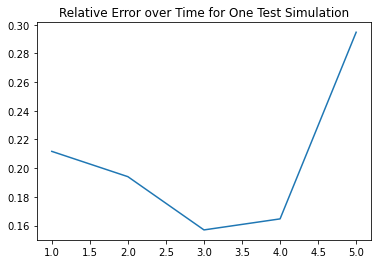

In [36]:
sample_sim, sample_GT, rel_error = relative_error_info(surrogate, trainDataLoader, 
                                                       None, None, quiet=True)

In [37]:
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.animation as manimati
from matplotlib import animation, rc
from IPython.display import Video
def create_1_channel_movie(im,outfile='sim.mp4',title='surrogate            simulation'):
    ti = 0
    u_mx = 255 #np.max(np.abs(Xrgb))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(title)
    #cmap = plt.cm.ocean
    img = ax.imshow(im[0].squeeze(), cmap=plt.cm.viridis, vmin=0, vmax=u_mx)
    #plt.show()
    
    # initialization function: plot the background of each frame
    def init():
        img = ax.imshow(im[0].squeeze(),  vmin=0, vmax=u_mx)
        return (fig,)

    # animation function. This is called sequentially
    def animate(i):
        img = ax.imshow(im[i].squeeze(), vmin=0, vmax=u_mx)
        return (fig,)


    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(im), interval=100, blit=True)
    anim.save(outfile, fps=1, extra_args=['-vcodec', 'libx264'])
    
def get_img(X):
    M = 255
    mx = X.max()
    mn = X.min()
    X = (X - mn)/(mx - mn)
    C = (M*X).type(torch.uint8)
    return C

def make_movie(sample_sim, sample_GT, ID = ''):
    # get sample_sim and sample_GT from the relative_error_info function above
    Xrgb = torch.cat([get_img(sample_sim), get_img(sample_GT)], dim=3)[:,0].detach().cpu().numpy()
    Xrgb.shape
    
    video_name = versionName + ID
    
    # to-do: dave says we should flip vertically before making the mp4
    outGif = '{}.mp4'.format(video_name)
    create_1_channel_movie(Xrgb,outfile=outGif)

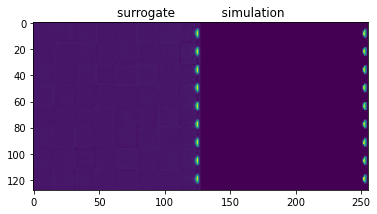

In [38]:
make_movie(sample_sim, sample_GT, ID='_train')
Video('{}.mp4'.format(versionName+'_train'))

In [39]:
surrogate.load_state_dict(torch.load(os.path.join(cps,versionName)))

<All keys matched successfully>

In [40]:
testDataset_fullSim = CCSI_2D(testSimFiles,doPreprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel,AE=AE,
                      w=simLen-1)
first_frame_testDataset = torch.utils.data.Subset(testDataset_fullSim, range(0, len(testDataset), simLen))
simulation_testDataLoader = DataLoader(dataset=first_frame_testDataset, batch_size=1)

In [41]:
X,Y, p_x, p_y = next(iter(simulation_testDataLoader))
X.shape,Y.shape, p_x.shape, p_y.shape

(torch.Size([1, 1, 128, 128]),
 torch.Size([1, 5, 1, 128, 128]),
 torch.Size([1, 2]),
 torch.Size([1, 5, 2]))

In [42]:
surrogate.eval()
U_hats = []
Us = []
for i, sampleBatch in enumerate(simulation_testDataLoader, start=1):

    # gpu
    U_x, U_y, p_x, p_y = sampleBatch
    U_x = U_x.to(device)
    p_x = p_x.to(device)
    U_y = U_y.to(device)
    p_y = p_y.to(device)
    with torch.no_grad():
        Us.append(U_y.detach().cpu())
        
        U_hat = surrogate(U_x, p_x, p_y, window=simLen-1)
                    
        U_hats.append(U_hat.detach().cpu())
        
        
Real_U = torch.stack(Us)
#Real_X_img = convertSimToImage(Real_X)

Surr_U = torch.stack(U_hats)
#Surr_X_img = convertSimToImage(Surr_X)

/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [43]:
for a,b in zip(Us,U_hats):
    rel_error = torch.norm(a - b)/torch.norm(a)
    writeMessage("Relative_Error: {:.4e}".format(rel_error),versionName)

Relative_Error: 2.9459e-01


In [44]:
rel_error = torch.norm(Real_U - Surr_U)/torch.norm(Real_U)
writeMessage("Relative_Error: {:.4e}".format(rel_error),versionName)
test_writer.add_scalar(tag="Relative_Error", scalar_value=rel_error, global_step=tensorboard_recorder_step)
test_writer.flush()

Relative_Error: 2.9459e-01
